<a href="https://colab.research.google.com/github/Lucifer2700/UCBerkley_Segmentation/blob/main/Driveable_Area_FP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

os.chdir("/content/drive/My Drive/UCBerkley_Segmentation_Project")
!ls

Mounted at /content/drive
dataset			       Driveable_Area_Starter.ipynb  videos
Driveable_Area_Solution.ipynb  output


In [ ]:
## USE GPU
import tensorflow as tf
print(tf.__version__)
#from tensorflow.python.client import device_lib
# LIST GPUS AVAILABLE
#print(device_lib.list_local_devices())
#import tensorflow.python.keras
#config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} )
#sess = tf.compat.v1.Session(config=config)
#tensorflow.python.keras.backend.set_session(sess)

2.12.0


# <a name="Data"></a>1. Data Collect, Visualization, Augmentation

This project will use the [BDD 100K Dataset](https://bdd-data.berkeley.edu/).<p>

It was downloaded from [this website](https://bdd-data.berkeley.edu/login.html) and then dumped into a pickle file.<p>-<p>

If you want to repeat the process, go to the [download page](https://bdd-data.berkeley.edu/portal.html#download) (once logged in) and click on the buttons **Images** and **Driverable Maps** under the BDD100K section.
It will download the necessary dataset. Then pick a subset of it.
Use Google Chrome and in case it doesn't work, hit the button again until it does.<p>-<p>


**Use the provided pickle file**<p>
I have downloaded the images and labels. It took a few hours.<p>
I selected **3,000 images** and **their associated labels** and put them into **2 separate pickle files**. <p>Each image has been resized to **160x80** for memory reasons. <p>
**Original 1280x720** images are also available in the course.

<p>-<p>In this part you will load the dataset and adapt it so it fits your neural network.

## Load the Dataset, Visualize Images & Labels

**Library Import**

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

**Load the Pickle Files**

In [ ]:
import pickle

with open("dataset/images_3000_160.p", 'rb') as f:
    images = pickle.load(f)

with open("dataset/labels_3000_160.p","rb") as f:
    labels = pickle.load(f)

## NOTE : File has been pickle.dump() with Python 2 so this syntax is necessary to open it with Python 3. Otherwise the following would be enough :
#images = pickle.load(open("images.p","rb", encoding='latin1)) # Pickle Dump using Python 2
#images = pickle.load(open("images.p","rb")) ## Pickle Dump using Python 3

**Display a Random Image and its Labels**
<p>
Print Dataset information

Text(0.5, 1.0, 'Label')

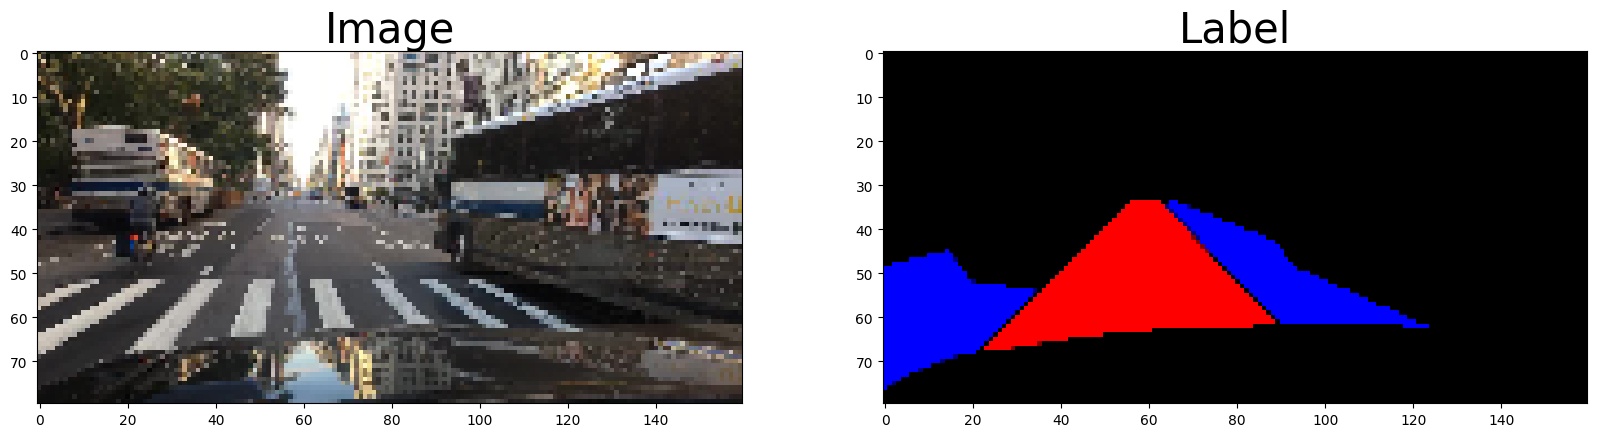

In [ ]:
import random
index = random.randint(0,len(labels))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(images[index].squeeze())
ax1.set_title('Image', fontsize=30)
ax2.imshow(labels[index].squeeze())
ax2.set_title('Label', fontsize=30)

In [ ]:
print("There are "+ str(len(images))+ " images and "+ str(len(labels)) +" labels in the dataset")
print("Shape of an image")
print(images[0].shape)
print("Shape of a Label")
print(labels[0].shape)
print("Images range from "+str(np.amin(images[0]))+" to "+str(np.amax(images[0])))
print("Labels range from "+str(np.amin(labels[0]))+" to "+str(np.amax(labels[0])))

There are 3000 images and 3000 labels in the dataset
Shape of an image
(80, 160, 3)
Shape of a Label
(80, 160, 3)
Images range from 0 to 255
Labels range from 0.0 to 1.0


## Labels & Output


To fit an Encoder-Decoder Neural Network; you will need to preprocess your labels. Currently, **your labels are RGB images of dimension 160x80x3.**

As you can see here, we have multiple options, and I will detail all 3 of them.<p>
![Texte alternatif…](http://ronny.rest/media/tutorials/segmentation/ZZZ_IMAGES_DIR/label_formats.jpeg)


*   **A- Class Labels**
Each Pixel is a number representing a class.<p>
In this case, the output is simply a matrix of 1 channel with these numbers.
*   **B- RGB Mappings**
This is what we currently have, the labels are in RGB format.<p>
As we are only working with 2 classes, and they all are colored either red or blue, it's quite easy to work with.
If you ever get more classes, let's say 7, some pixels will not be 0 or 255, they will have some intensity value and it will get more complicated.
Preprocessing is therefore necessary.
*   **C- One Hot Vectors**
Similar to format A, but one-hot encoded.

**Your Choice**

For this project, you have the choice to detect only the driveable area or the driveable area + the adjacent lanes. <p>

You will therefore
*   Remove every blue pixel and face a 1-channel problem (driveable area detection)
*   Keep the blue pixel, use 3 channels.<p>**One easy solution would be to convert every black pixel into a green one.**
Then, the network would have to label a pixel as either green (background), red (driveable), or blue (adjacent).


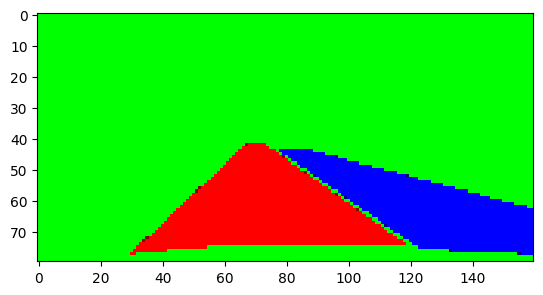

In [ ]:
new_labels = []
for lab in labels:
    for x in range(lab.shape[0]):
        for y in range(lab.shape[1]):
            if (np.all(lab[x][y]==[0,0,0])):
                lab[x][y]=[0,1,0]
    new_labels.append(lab)

plt.imshow(new_labels[0])

**Data Augmentation**

3,000 images can be enough, but in Deep Learning, **more is better**.
If you want a strong model performance, feel free to augment your dataset any way you want.

6000
6000


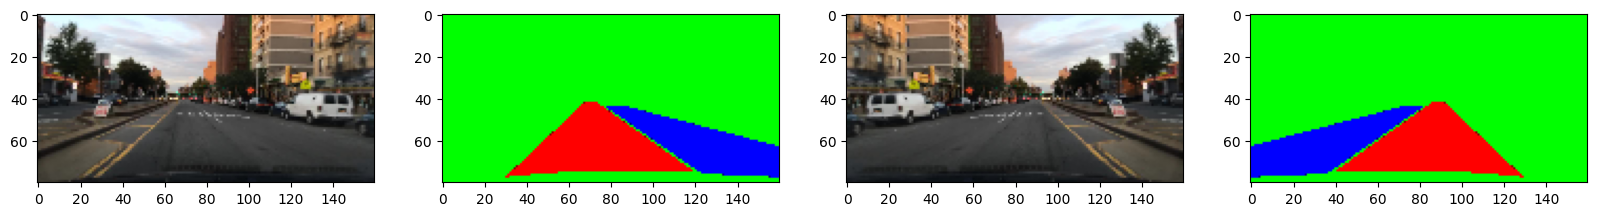

In [ ]:
def flip_image(img):
    return cv2.flip(img, 1)

flipped_images = []
flipped_labels = []

for i in images:
    flipped_images.append(flip_image(i))

for i in labels:
    flipped_labels.append(flip_image(i))

images.extend(flipped_images)
new_labels.extend(flipped_labels)
print(len(images))
print(len(new_labels))

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20,10))
ax1.imshow(images[0])
ax2.imshow(new_labels[0])
ax3.imshow(flipped_images[0])
ax4.imshow(flipped_labels[0])

**Train Test Split**<p>
As for every neural network, you will need **training** and **testing** data.

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
images = np.array(images)
labels = np.array(new_labels)

# Shuffle
images, labels = shuffle(images, labels)

# Test size may go from 10% to 30%
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.15)
n_train = len(X_train)
n_val = len(X_val)

print("Number of element in training set")
print(n_train)
print("Number of element in validation set")
print(n_val)

Number of element in training set
5100
Number of element in validation set
900


# <a name="Model"></a>2. Create A Deep Learning Model

## Model Definition

Here, we will define a Fully Convolutional Neural Network.<p>
It actually means a **neural networks that doesn't have any Dense layer** (or Fully Connected), but **only Convolutions**.

![Texte alternatif…](https://mi.eng.cam.ac.uk/projects/segnet/images/segnet.png)

We will use **Keras**.<p>
[Here is a way to use Keras for Deep Learning](https://keras.io/getting-started/functional-api-guide/).

**What should we implement?**


1.   Create an **encoder** that learns the features
2.   Create a **decoder** that upsamples to the original image size
3.   Implement advanced techniques such as **1x1 convolutions**, or **skip connections** to make the neural network better.

To avoid overfitting, we can use **Dropout**.
To make the network better, we can use **Batch Normalization** after the input. In semantic segmentation, Batch Normalization have proven amazing results.






**Imports**

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Conv2D, MaxPooling2D, Reshape, Input, add
from tensorflow.keras.layers import UpSampling2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

**Testing different Models**

In [ ]:
def simple_encoder_decoder(input_shape=(80,160,3), pool_size=(2,2)):


    model=Sequential()
    model.add(BatchNormalization(input_shape=input_shape))
    model.add(Conv2D(8, (5,5), padding='valid', strides=(1,1), activation='relu'))
    model.add(Conv2D(8, (5,5), padding='valid', strides=(1,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(UpSampling2D(size=pool_size))
    model.add(Conv2DTranspose(8, (5,5), padding='valid', strides=(1,1), activation='relu'))
    model.add(Conv2DTranspose(3, (5,5), padding='valid', strides=(1,1), activation='relu'))
    model.summary()

simple_encoder_decoder()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 80, 160, 3)       12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 76, 156, 8)        608       
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 152, 8)        1608      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 76, 8)        0         
 )                                                               
                                                                 
 up_sampling2d (UpSampling2D  (None, 72, 152, 8)       0         
 )                                                               
                                                        

In [ ]:
def other_model_dropout(pool_size=(2,2), input_shape=(80,160,3)):
    input_x = Input(shape=(80,160,3))
    x = BatchNormalization(input_shape=input_shape)(input_x)
    x = Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x1 = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=pool_size)(x1)
    x = Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x2 = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = MaxPooling2D(pool_size=pool_size)(x2)
    x = Conv2D(128, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x3 = Dropout(0.2)(x)
    x = add([x3, x])
    x = MaxPooling2D(pool_size=pool_size)(x3)
    x = UpSampling2D(size=pool_size, interpolation='bilinear')(x)
    x = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=pool_size, interpolation='bilinear')(x)
    x = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = add([x2, x])
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = UpSampling2D(size=pool_size, interpolation='bilinear')(x)
    x = Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(3, (1,1), padding='valid', strides=(1,1), activation='softmax')(x)
    return Model(input_x,x)
model = other_model_dropout()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 160, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 80, 160, 3)  12          ['input_1[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 conv2d_2 (Conv2D)              (None, 78, 158, 32)  896         ['batch_normalization_1[0][0]']  
                                                                                              

In [ ]:
def other_model(pool_size=(2,2), input_shape=(80,160,3)):
    input_x = Input(shape=(80,160,3))
    x = BatchNormalization(input_shape=input_shape)(input_x)
    x = Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x1 = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=pool_size)(x1)
    x = Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x2 = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=pool_size)(x2)
    x = Conv2D(128, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = UpSampling2D(size=pool_size, interpolation='bilinear')(x)
    x = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=pool_size, interpolation='bilinear')(x)
    x = Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=pool_size, interpolation='bilinear')(x)
    x = Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(8, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(3, (1,1), padding='valid', strides=(1,1), activation='softmax')(x)
    return Model(input_x,x)
model = other_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80, 160, 3)]      0         
                                                                 
 batch_normalization_16 (Bat  (None, 80, 160, 3)       12        
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 78, 158, 32)       896       
                                                                 
 batch_normalization_17 (Bat  (None, 78, 158, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 76, 156, 32)       9248      
                                                                 
 batch_normalization_18 (Bat  (None, 76, 156, 32)      128 

In [ ]:
def encoder_decoder_skip_connections(input_shape= (160,80,3), pool_size=(2,2), dropout_rate=0.5):
    """
    Here, build your killer segmentation network.
    Use any technique that can be useful.
    Credits for the architecture: https://towardsdatascience.com/lane-detection-with-deep-learning-part-2-3ba559b5c5af
    """
    # ENCODER
    input_x = Input(shape=(80,160,3))
    x1 = BatchNormalization(input_shape=input_shape)(input_x)
    ## CONV 1
    x = Conv2D(8, (3, 3), strides = (1,1), activation='relu', padding='valid')(x1)
    ## CONV 2 + SKIP CONNECTION
    x = Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    ## CONV 3
    x = Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    ## CONV4 + SKIP CONNECTION
    x2 = Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x2)
    ## CONV5
    x = Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    ## CONV6
    x = Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)
    ## CONV7
    x = Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    # DECODER
    ## UPSAMPLING 7
    x = UpSampling2D(size=pool_size, interpolation='nearest')(x)
    x = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)

    ## UPSAMPLING 6
    x = Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)

    ## UPSAMPLING 5
    x = UpSampling2D(size=pool_size, interpolation='nearest')(x)
    x = Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)

    ## UPSAMPLING 4
    x = add([x2, x])
    x = Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = Dropout(dropout_rate)(x)

    ## UPSAMPLING 3
    x = Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    ## UPSAMPLING 2
    x = UpSampling2D(size=pool_size, interpolation='nearest')(x)
    x = Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)

    ## UPSAMPLING 1
    x = Conv2DTranspose(3, (3, 3), padding='valid', strides=(1,1), activation = 'relu')(x)
    x = add([x1, x])
    x = Conv2D(3, (1,1), padding=('valid'), strides=(1,1), activation='softmax')(x)
    return Model(input_x,x)
model = encoder_decoder_skip_connections()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 80, 160, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 batch_normalization_31 (BatchN  (None, 80, 160, 3)  12          ['input_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 conv2d_16 (Conv2D)             (None, 78, 158, 8)   224         ['batch_normalization_31[0][0]'] 
                                                                                            

## MODEL TRAINING

Use any technique you know to improve model training or generalization.


*   If you want to detect **1 class (driveable area)**, you can use **binary cross-entropy or mean squared error** as a metric.
*  If you want to detect **2 or more classes** (driveable area + adjacent), you can use **categorical cross-entropy** as a metric. <p>

**Hyperparameters**

In [ ]:
batch_size = 32
epochs = 10
pool_size = (2, 2)
learning_rate= 0.001
steps_per_epoch=len(X_train)/batch_size
input_shape = X_train.shape[1:]

**Training**

In [ ]:
# Using a generator to help the model use less data
# Channel shifts help with shadows slightly
datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(X_train)

# Compiling and training the model
#model.compile(optimizer=tf.keras.optimizers.Adam(
#    learning_rate=learning_rate, amsgrad=False, name="Adam"), loss='categorical_crossentropy')

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=False, name="Adam")
model.compile(optimizer=optimizer, loss='categorical_crossentropy')

history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=steps_per_epoch,
          epochs=epochs, verbose=1, validation_data=(X_val, y_val))


# Save model architecture and weights
#model.save('model.h5')

Epoch 1/10
159/159 [==============================] - 30s 71ms/step - loss: 0.9637 - val_loss: 0.4554
Epoch 2/10
159/159 [==============================] - 8s 52ms/step - loss: 0.3563 - val_loss: 0.3586
Epoch 3/10
159/159 [==============================] - 9s 54ms/step - loss: 0.3046 - val_loss: 0.3116
Epoch 4/10
159/159 [==============================] - 9s 56ms/step - loss: 0.2858 - val_loss: 0.2867
Epoch 5/10
159/159 [==============================] - 8s 53ms/step - loss: 0.2737 - val_loss: 0.2673
Epoch 6/10
159/159 [==============================] - 9s 56ms/step - loss: 0.2642 - val_loss: 0.2760
Epoch 7/10
159/159 [==============================] - 9s 57ms/step - loss: 0.2558 - val_loss: 0.2488
Epoch 8/10
159/159 [==============================] - 9s 53ms/step - loss: 0.2499 - val_loss: 0.2547
Epoch 9/10
159/159 [==============================] - 9s 56ms/step - loss: 0.2435 - val_loss: 0.2419
Epoch 10/10
159/159 [==============================] - 9s 58ms/step - loss: 0.2380 - val_l

**Plot Training Results**

dict_keys(['loss', 'val_loss'])


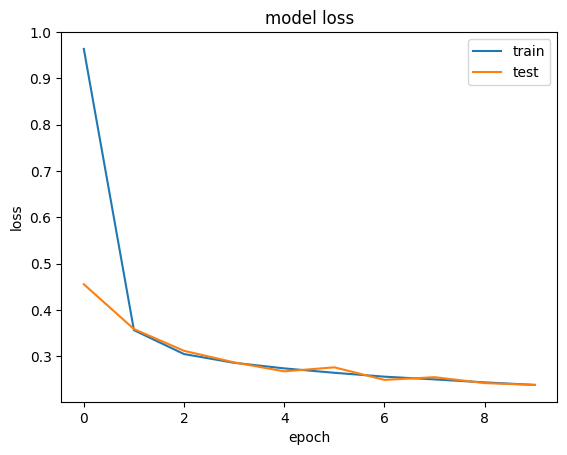

In [ ]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Test the model and Build a general pipeline

In [ ]:
def rgb_channel(img, thresholding=False, thresh=230):
    """Threshold the re-drawn images"""
    image = np.copy(img)
    if thresholding:
        ret, image = cv2.threshold(image, thresh, 255, cv2.THRESH_BINARY)
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    return R,G,B

**Build the Run Function**
The run function must:
* Take an image as input
* Resize the input to match the model size
* Call model.predict()
* Extract R,G,B channels from prediction
* Rescale to the original image size
* Draw on the input image
* Return the result

In [ ]:
def run(input_image):
    h,w,d = input_image.shape
    network_image = input_image.copy()
    network_image = cv2.resize(network_image, (160,80), interpolation=cv2.INTER_AREA)
    network_image = network_image[None,:,:,:]
    prediction = model.predict(network_image)[0]*255
    R,G,B = rgb_channel(prediction)
    blank = np.zeros_like(R).astype(np.uint8)
    lane_image = np.dstack((R,blank, B))
    lane_image = cv2.resize(lane_image, (w,h))
    result = cv2.addWeighted(input_image, 1, lane_image.astype(np.uint8), 1, 0)
    return result

**Test from the Dataset**

1/1 [==============================] - 1s 622ms/step


Text(0.5, 1.0, 'Drawn Prediction')

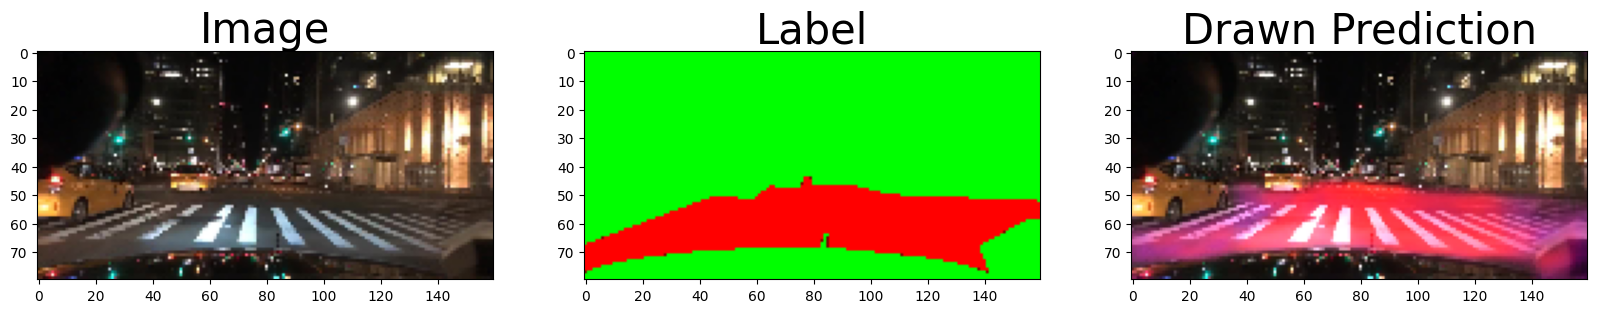

In [ ]:
index = random.randint(0,len(images))

img_test = run(images[index])

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(images[index].squeeze())
ax1.set_title('Image', fontsize=30)
ax2.imshow(labels[index].squeeze())
ax2.set_title('Label', fontsize=30)
ax3.imshow(img_test)
ax3.set_title("Drawn Prediction", fontsize=30)

**Test on a never seen image**

1/1 [==============================] - 0s 23ms/step


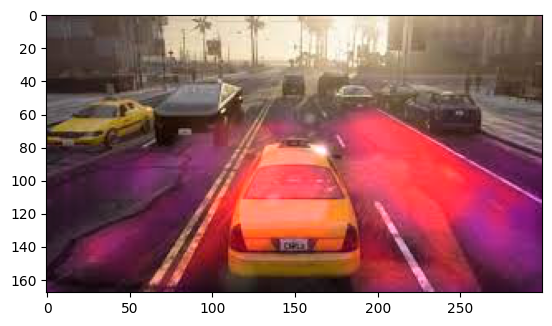

In [ ]:
predict_image = mpimg.imread("/content/drive/My Drive/UCBerkley_Segmentation_Project/dataset/Test Image.jpg")
plt.imshow(run(predict_image))
plt.show()


# <a name="Video"></a>3. Run on a Video

Here is the best part. FCN models generally are fast. They can run on CPU at 5 FPS and on GPU at a very high frame rate.<p>
Test your code on a video and see how it worked.

In [ ]:
import glob
img_array = []
for filename in sorted(glob.glob('data_2/*.png')):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('videos/project_2.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

NameError: ignored

In [ ]:
from moviepy.editor import VideoFileClip

video_file = "/content/drive/My Drive/UCBerkley_Segmentation_Project/videos/videos/paris_challenge.mov"
clip = VideoFileClip(video_file)
white_clip = clip.fl_image(run)
%time white_clip.write_videofile("output/test_project_parischallenge.mp4",audio=False)

1/1 [==============================] - 0s 31ms/step


t:   0%|          | 13/2902 [00:33<19:46,  2.44it/s, now=None]

Moviepy - Building video output/test_project_parischallenge.mp4.
Moviepy - Writing video output/test_project_parischallenge.mp4




t:   0%|          | 0/2902 [00:00<?, ?it/s, now=None]

1/1 [==============================] - 0s 23ms/step



t:   0%|          | 2/2902 [00:00<04:18, 11.23it/s, now=None]

1/1 [==============================] - 0s 31ms/step



t:   0%|          | 4/2902 [00:00<09:35,  5.04it/s, now=None]

1/1 [==============================] - 0s 37ms/step



t:   0%|          | 5/2902 [00:00<10:18,  4.69it/s, now=None]

1/1 [==============================] - 0s 35ms/step



t:   0%|          | 6/2902 [00:01<10:43,  4.50it/s, now=None]

1/1 [==============================] - 0s 38ms/step



t:   0%|          | 7/2902 [00:01<11:15,  4.29it/s, now=None]

1/1 [==============================] - 0s 36ms/step



t:   0%|          | 8/2902 [00:01<11:46,  4.10it/s, now=None]

1/1 [==============================] - 0s 32ms/step



t:   0%|          | 9/2902 [00:02<12:25,  3.88it/s, now=None]

1/1 [==============================] - 0s 38ms/step



t:   0%|          | 10/2902 [00:02<12:54,  3.73it/s, now=None]

1/1 [==============================] - 0s 35ms/step



t:   0%|          | 11/2902 [00:02<13:17,  3.63it/s, now=None]

1/1 [==============================] - 0s 23ms/step



t:   0%|          | 12/2902 [00:02<13:31,  3.56it/s, now=None]

1/1 [==============================] - 0s 33ms/step



t:   0%|          | 13/2902 [00:03<13:37,  3.53it/s, now=None]

1/1 [==============================] - 0s 29ms/step



t:   0%|          | 14/2902 [00:03<13:34,  3.55it/s, now=None]

1/1 [==============================] - 0s 32ms/step



t:   1%|          | 15/2902 [00:03<13:21,  3.60it/s, now=None]

1/1 [==============================] - 0s 39ms/step



t:   1%|          | 16/2902 [00:04<13:41,  3.52it/s, now=None]

1/1 [==============================] - 0s 34ms/step



t:   1%|          | 17/2902 [00:04<13:33,  3.55it/s, now=None]

1/1 [==============================] - 0s 36ms/step



t:   1%|          | 18/2902 [00:04<13:40,  3.52it/s, now=None]

1/1 [==============================] - 0s 62ms/step



t:   1%|          | 19/2902 [00:05<15:53,  3.02it/s, now=None]

1/1 [==============================] - 0s 85ms/step



t:   1%|          | 20/2902 [00:05<18:11,  2.64it/s, now=None]

1/1 [==============================] - 0s 44ms/step



t:   1%|          | 21/2902 [00:06<19:42,  2.44it/s, now=None]

1/1 [==============================] - 0s 48ms/step



t:   1%|          | 22/2902 [00:06<21:31,  2.23it/s, now=None]

1/1 [==============================] - 0s 36ms/step



t:   1%|          | 23/2902 [00:07<22:07,  2.17it/s, now=None]

1/1 [==============================] - 0s 27ms/step



t:   1%|          | 24/2902 [00:07<20:12,  2.37it/s, now=None]

1/1 [==============================] - 0s 59ms/step



t:   1%|          | 25/2902 [00:07<20:55,  2.29it/s, now=None]

1/1 [==============================] - 0s 26ms/step



t:   1%|          | 26/2902 [00:08<19:31,  2.45it/s, now=None]

1/1 [==============================] - 0s 70ms/step



t:   1%|          | 27/2902 [00:08<20:10,  2.38it/s, now=None]

1/1 [==============================] - 0s 36ms/step



t:   1%|          | 28/2902 [00:09<19:22,  2.47it/s, now=None]

1/1 [==============================] - 0s 74ms/step



t:   1%|          | 29/2902 [00:09<19:37,  2.44it/s, now=None]

1/1 [==============================] - 0s 48ms/step



t:   1%|          | 30/2902 [00:09<18:59,  2.52it/s, now=None]

1/1 [==============================] - 0s 66ms/step



t:   1%|          | 31/2902 [00:10<19:39,  2.43it/s, now=None]

1/1 [==============================] - 0s 72ms/step



t:   1%|          | 32/2902 [00:10<19:47,  2.42it/s, now=None]

1/1 [==============================] - 0s 70ms/step



t:   1%|          | 33/2902 [00:11<20:15,  2.36it/s, now=None]

1/1 [==============================] - 0s 73ms/step



t:   1%|          | 34/2902 [00:11<20:03,  2.38it/s, now=None]

1/1 [==============================] - 0s 61ms/step



t:   1%|          | 35/2902 [00:11<20:22,  2.34it/s, now=None]

1/1 [==============================] - 0s 34ms/step



t:   1%|          | 36/2902 [00:12<19:59,  2.39it/s, now=None]

1/1 [==============================] - 0s 44ms/step



t:   1%|▏         | 37/2902 [00:12<20:31,  2.33it/s, now=None]

1/1 [==============================] - 0s 59ms/step



t:   1%|▏         | 38/2902 [00:13<20:35,  2.32it/s, now=None]

1/1 [==============================] - 0s 64ms/step



t:   1%|▏         | 39/2902 [00:13<21:27,  2.22it/s, now=None]

1/1 [==============================] - 0s 69ms/step



t:   1%|▏         | 40/2902 [00:14<21:10,  2.25it/s, now=None]

1/1 [==============================] - 0s 76ms/step



t:   1%|▏         | 41/2902 [00:14<20:59,  2.27it/s, now=None]

1/1 [==============================] - 0s 55ms/step



t:   1%|▏         | 42/2902 [00:15<21:24,  2.23it/s, now=None]

1/1 [==============================] - 0s 51ms/step



t:   1%|▏         | 43/2902 [00:15<21:13,  2.25it/s, now=None]

1/1 [==============================] - 0s 75ms/step



t:   2%|▏         | 44/2902 [00:16<21:56,  2.17it/s, now=None]

1/1 [==============================] - 0s 57ms/step



t:   2%|▏         | 45/2902 [00:16<21:10,  2.25it/s, now=None]

1/1 [==============================] - 0s 33ms/step



t:   2%|▏         | 46/2902 [00:16<21:07,  2.25it/s, now=None]

1/1 [==============================] - 0s 79ms/step



t:   2%|▏         | 47/2902 [00:17<20:46,  2.29it/s, now=None]

1/1 [==============================] - 0s 32ms/step



t:   2%|▏         | 48/2902 [00:19<47:53,  1.01s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:   2%|▏         | 49/2902 [00:20<40:17,  1.18it/s, now=None]

1/1 [==============================] - 0s 64ms/step



t:   2%|▏         | 50/2902 [00:21<43:53,  1.08it/s, now=None]

1/1 [==============================] - 0s 53ms/step



t:   2%|▏         | 51/2902 [00:22<46:34,  1.02it/s, now=None]

1/1 [==============================] - 0s 50ms/step



t:   2%|▏         | 52/2902 [00:23<44:50,  1.06it/s, now=None]

1/1 [==============================] - 0s 77ms/step



t:   2%|▏         | 53/2902 [00:23<39:22,  1.21it/s, now=None]

1/1 [==============================] - 0s 64ms/step



t:   2%|▏         | 54/2902 [00:24<36:36,  1.30it/s, now=None]

1/1 [==============================] - 0s 87ms/step



t:   2%|▏         | 55/2902 [00:26<51:20,  1.08s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:   2%|▏         | 56/2902 [00:27<48:06,  1.01s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:   2%|▏         | 57/2902 [00:29<1:03:10,  1.33s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:   2%|▏         | 58/2902 [00:30<1:06:30,  1.40s/it, now=None]

1/1 [==============================] - 0s 128ms/step



t:   2%|▏         | 59/2902 [00:32<1:06:00,  1.39s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:   2%|▏         | 60/2902 [00:32<55:12,  1.17s/it, now=None]  

1/1 [==============================] - 0s 53ms/step



t:   2%|▏         | 61/2902 [00:34<1:09:30,  1.47s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:   2%|▏         | 62/2902 [00:35<59:49,  1.26s/it, now=None]  

1/1 [==============================] - 0s 60ms/step



t:   2%|▏         | 63/2902 [00:36<54:13,  1.15s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:   2%|▏         | 64/2902 [00:37<47:16,  1.00it/s, now=None]

1/1 [==============================] - 0s 51ms/step



t:   2%|▏         | 65/2902 [00:38<56:20,  1.19s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:   2%|▏         | 66/2902 [00:39<50:14,  1.06s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:   2%|▏         | 67/2902 [00:40<47:39,  1.01s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:   2%|▏         | 68/2902 [00:40<39:35,  1.19it/s, now=None]

1/1 [==============================] - 0s 54ms/step



t:   2%|▏         | 69/2902 [00:42<53:46,  1.14s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:   2%|▏         | 70/2902 [00:43<49:05,  1.04s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:   2%|▏         | 71/2902 [00:44<53:08,  1.13s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:   2%|▏         | 72/2902 [00:46<57:47,  1.23s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:   3%|▎         | 73/2902 [00:49<1:18:58,  1.68s/it, now=None]

1/1 [==============================] - 0s 91ms/step



t:   3%|▎         | 74/2902 [00:50<1:09:45,  1.48s/it, now=None]

1/1 [==============================] - 0s 95ms/step



t:   3%|▎         | 75/2902 [00:51<1:05:40,  1.39s/it, now=None]

1/1 [==============================] - 0s 38ms/step



t:   3%|▎         | 76/2902 [00:52<56:52,  1.21s/it, now=None]  

1/1 [==============================] - 0s 49ms/step



t:   3%|▎         | 77/2902 [00:53<1:01:12,  1.30s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:   3%|▎         | 78/2902 [00:54<52:33,  1.12s/it, now=None]  

1/1 [==============================] - 0s 68ms/step



t:   3%|▎         | 79/2902 [00:54<46:49,  1.00it/s, now=None]

1/1 [==============================] - 0s 33ms/step



t:   3%|▎         | 80/2902 [00:55<40:37,  1.16it/s, now=None]

1/1 [==============================] - 0s 56ms/step



t:   3%|▎         | 81/2902 [00:57<53:55,  1.15s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:   3%|▎         | 82/2902 [00:58<47:40,  1.01s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:   3%|▎         | 83/2902 [00:58<42:34,  1.10it/s, now=None]

1/1 [==============================] - 0s 44ms/step



t:   3%|▎         | 84/2902 [00:59<40:59,  1.15it/s, now=None]

1/1 [==============================] - 0s 37ms/step



t:   3%|▎         | 85/2902 [01:01<53:46,  1.15s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:   3%|▎         | 86/2902 [01:02<52:03,  1.11s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:   3%|▎         | 87/2902 [01:03<54:41,  1.17s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:   3%|▎         | 88/2902 [01:04<53:13,  1.13s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:   3%|▎         | 89/2902 [01:07<1:17:26,  1.65s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:   3%|▎         | 90/2902 [01:08<1:08:10,  1.45s/it, now=None]

1/1 [==============================] - 0s 115ms/step



t:   3%|▎         | 91/2902 [01:09<1:00:21,  1.29s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:   3%|▎         | 92/2902 [01:10<50:46,  1.08s/it, now=None]  

1/1 [==============================] - 0s 60ms/step



t:   3%|▎         | 93/2902 [01:11<1:01:10,  1.31s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:   3%|▎         | 94/2902 [01:12<51:25,  1.10s/it, now=None]  

1/1 [==============================] - 0s 43ms/step



t:   3%|▎         | 95/2902 [01:13<46:32,  1.01it/s, now=None]

1/1 [==============================] - 0s 44ms/step



t:   3%|▎         | 96/2902 [01:13<39:45,  1.18it/s, now=None]

1/1 [==============================] - 0s 48ms/step



t:   3%|▎         | 97/2902 [01:15<52:00,  1.11s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:   3%|▎         | 98/2902 [01:15<43:16,  1.08it/s, now=None]

1/1 [==============================] - 0s 78ms/step



t:   3%|▎         | 99/2902 [01:16<38:15,  1.22it/s, now=None]

1/1 [==============================] - 0s 81ms/step



t:   3%|▎         | 100/2902 [01:17<42:41,  1.09it/s, now=None]

1/1 [==============================] - 0s 45ms/step



t:   3%|▎         | 101/2902 [01:19<51:58,  1.11s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:   4%|▎         | 102/2902 [01:20<52:17,  1.12s/it, now=None]

1/1 [==============================] - 0s 98ms/step



t:   4%|▎         | 103/2902 [01:21<55:49,  1.20s/it, now=None]

1/1 [==============================] - 0s 102ms/step



t:   4%|▎         | 104/2902 [01:22<55:57,  1.20s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:   4%|▎         | 105/2902 [01:25<1:17:00,  1.65s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:   4%|▎         | 106/2902 [01:26<1:05:56,  1.42s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:   4%|▎         | 107/2902 [01:27<54:44,  1.18s/it, now=None]  

1/1 [==============================] - 0s 61ms/step



t:   4%|▎         | 108/2902 [01:28<50:47,  1.09s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:   4%|▍         | 109/2902 [01:29<1:02:47,  1.35s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:   4%|▍         | 110/2902 [01:30<52:13,  1.12s/it, now=None]  

1/1 [==============================] - 0s 70ms/step



t:   4%|▍         | 111/2902 [01:31<48:05,  1.03s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:   4%|▍         | 112/2902 [01:32<45:30,  1.02it/s, now=None]

1/1 [==============================] - 0s 43ms/step



t:   4%|▍         | 113/2902 [01:34<57:30,  1.24s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:   4%|▍         | 114/2902 [01:34<49:49,  1.07s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:   4%|▍         | 115/2902 [01:35<46:28,  1.00s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:   4%|▍         | 116/2902 [01:36<39:43,  1.17it/s, now=None]

1/1 [==============================] - 0s 51ms/step



t:   4%|▍         | 117/2902 [01:39<1:08:19,  1.47s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:   4%|▍         | 118/2902 [01:40<1:03:10,  1.36s/it, now=None]

1/1 [==============================] - 0s 100ms/step



t:   4%|▍         | 119/2902 [01:41<1:02:35,  1.35s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:   4%|▍         | 120/2902 [01:42<58:00,  1.25s/it, now=None]  

1/1 [==============================] - 0s 63ms/step



t:   4%|▍         | 121/2902 [01:44<1:09:38,  1.50s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:   4%|▍         | 122/2902 [01:45<59:06,  1.28s/it, now=None]  

1/1 [==============================] - 0s 92ms/step



t:   4%|▍         | 123/2902 [01:46<53:19,  1.15s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:   4%|▍         | 124/2902 [01:46<44:04,  1.05it/s, now=None]

1/1 [==============================] - 0s 49ms/step



t:   4%|▍         | 125/2902 [01:48<54:57,  1.19s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:   4%|▍         | 126/2902 [01:49<48:17,  1.04s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:   4%|▍         | 127/2902 [01:49<43:22,  1.07it/s, now=None]

1/1 [==============================] - 0s 35ms/step



t:   4%|▍         | 128/2902 [01:50<45:04,  1.03it/s, now=None]

1/1 [==============================] - 0s 76ms/step



t:   4%|▍         | 129/2902 [01:52<51:12,  1.11s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:   4%|▍         | 130/2902 [01:53<46:21,  1.00s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:   5%|▍         | 131/2902 [01:54<46:28,  1.01s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:   5%|▍         | 132/2902 [01:54<44:26,  1.04it/s, now=None]

1/1 [==============================] - 0s 60ms/step



t:   5%|▍         | 133/2902 [01:57<1:13:36,  1.59s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:   5%|▍         | 134/2902 [01:58<1:05:09,  1.41s/it, now=None]

1/1 [==============================] - 0s 112ms/step



t:   5%|▍         | 135/2902 [02:00<1:04:33,  1.40s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:   5%|▍         | 136/2902 [02:01<1:00:10,  1.31s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:   5%|▍         | 137/2902 [02:02<1:02:19,  1.35s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:   5%|▍         | 138/2902 [02:03<52:46,  1.15s/it, now=None]  

1/1 [==============================] - 0s 76ms/step



t:   5%|▍         | 139/2902 [02:04<45:49,  1.00it/s, now=None]

1/1 [==============================] - 0s 51ms/step



t:   5%|▍         | 140/2902 [02:04<42:08,  1.09it/s, now=None]

1/1 [==============================] - 0s 40ms/step



t:   5%|▍         | 141/2902 [02:06<52:54,  1.15s/it, now=None]

1/1 [==============================] - 0s 33ms/step



t:   5%|▍         | 142/2902 [02:07<44:04,  1.04it/s, now=None]

1/1 [==============================] - 0s 73ms/step



t:   5%|▍         | 143/2902 [02:07<40:56,  1.12it/s, now=None]

1/1 [==============================] - 0s 42ms/step



t:   5%|▍         | 144/2902 [02:08<41:21,  1.11it/s, now=None]

1/1 [==============================] - 0s 52ms/step



t:   5%|▍         | 145/2902 [02:10<48:54,  1.06s/it, now=None]

1/1 [==============================] - 0s 37ms/step



t:   5%|▌         | 146/2902 [02:11<45:10,  1.02it/s, now=None]

1/1 [==============================] - 0s 119ms/step



t:   5%|▌         | 147/2902 [02:12<48:52,  1.06s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:   5%|▌         | 148/2902 [02:13<44:50,  1.02it/s, now=None]

1/1 [==============================] - 0s 103ms/step



t:   5%|▌         | 149/2902 [02:16<1:18:10,  1.70s/it, now=None]

1/1 [==============================] - 0s 106ms/step



t:   5%|▌         | 150/2902 [02:17<1:07:03,  1.46s/it, now=None]

1/1 [==============================] - 0s 108ms/step



t:   5%|▌         | 151/2902 [02:18<1:00:33,  1.32s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:   5%|▌         | 152/2902 [02:19<54:15,  1.18s/it, now=None]  

1/1 [==============================] - 0s 53ms/step



t:   5%|▌         | 153/2902 [02:20<1:00:20,  1.32s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:   5%|▌         | 154/2902 [02:21<50:36,  1.11s/it, now=None]  

1/1 [==============================] - 0s 70ms/step



t:   5%|▌         | 155/2902 [02:21<41:42,  1.10it/s, now=None]

1/1 [==============================] - 0s 58ms/step



t:   5%|▌         | 156/2902 [02:22<43:57,  1.04it/s, now=None]

1/1 [==============================] - 0s 74ms/step



t:   5%|▌         | 157/2902 [02:24<50:58,  1.11s/it, now=None]

1/1 [==============================] - 0s 33ms/step



t:   5%|▌         | 158/2902 [02:25<48:59,  1.07s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:   5%|▌         | 159/2902 [02:26<43:16,  1.06it/s, now=None]

1/1 [==============================] - 0s 69ms/step



t:   6%|▌         | 160/2902 [02:26<37:13,  1.23it/s, now=None]

1/1 [==============================] - 0s 53ms/step



t:   6%|▌         | 161/2902 [02:28<51:43,  1.13s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:   6%|▌         | 162/2902 [02:29<49:30,  1.08s/it, now=None]

1/1 [==============================] - 0s 111ms/step



t:   6%|▌         | 163/2902 [02:30<52:33,  1.15s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:   6%|▌         | 164/2902 [02:31<52:15,  1.15s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:   6%|▌         | 165/2902 [02:34<1:17:06,  1.69s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:   6%|▌         | 166/2902 [02:35<1:08:14,  1.50s/it, now=None]

1/1 [==============================] - 0s 122ms/step



t:   6%|▌         | 167/2902 [02:36<58:08,  1.28s/it, now=None]  

1/1 [==============================] - 0s 53ms/step



t:   6%|▌         | 168/2902 [02:37<52:04,  1.14s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:   6%|▌         | 169/2902 [02:39<1:01:47,  1.36s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:   6%|▌         | 170/2902 [02:39<51:03,  1.12s/it, now=None]  

1/1 [==============================] - 0s 53ms/step



t:   6%|▌         | 171/2902 [02:40<45:45,  1.01s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:   6%|▌         | 172/2902 [02:41<41:25,  1.10it/s, now=None]

1/1 [==============================] - 0s 44ms/step



t:   6%|▌         | 173/2902 [02:42<51:26,  1.13s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:   6%|▌         | 174/2902 [02:43<42:14,  1.08it/s, now=None]

1/1 [==============================] - 0s 56ms/step



t:   6%|▌         | 175/2902 [02:44<39:31,  1.15it/s, now=None]

1/1 [==============================] - 0s 58ms/step



t:   6%|▌         | 176/2902 [02:45<43:05,  1.05it/s, now=None]

1/1 [==============================] - 0s 54ms/step



t:   6%|▌         | 177/2902 [02:46<51:14,  1.13s/it, now=None]

1/1 [==============================] - 0s 40ms/step



t:   6%|▌         | 178/2902 [02:48<53:19,  1.17s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:   6%|▌         | 179/2902 [02:49<55:41,  1.23s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:   6%|▌         | 180/2902 [02:50<52:21,  1.15s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:   6%|▌         | 181/2902 [02:53<1:20:24,  1.77s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:   6%|▋         | 182/2902 [02:54<1:05:27,  1.44s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:   6%|▋         | 183/2902 [02:55<55:50,  1.23s/it, now=None]  

1/1 [==============================] - 0s 38ms/step



t:   6%|▋         | 184/2902 [02:55<50:56,  1.12s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:   6%|▋         | 185/2902 [02:57<1:00:28,  1.34s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:   6%|▋         | 186/2902 [02:58<51:50,  1.15s/it, now=None]  

1/1 [==============================] - 0s 75ms/step



t:   6%|▋         | 187/2902 [02:59<47:12,  1.04s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:   6%|▋         | 188/2902 [02:59<38:41,  1.17it/s, now=None]

1/1 [==============================] - 0s 75ms/step



t:   7%|▋         | 189/2902 [03:01<52:29,  1.16s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:   7%|▋         | 190/2902 [03:02<46:43,  1.03s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:   7%|▋         | 191/2902 [03:02<40:59,  1.10it/s, now=None]

1/1 [==============================] - 0s 30ms/step



t:   7%|▋         | 192/2902 [03:03<37:06,  1.22it/s, now=None]

1/1 [==============================] - 0s 55ms/step



t:   7%|▋         | 193/2902 [03:06<1:08:12,  1.51s/it, now=None]

1/1 [==============================] - 0s 127ms/step



t:   7%|▋         | 194/2902 [03:07<1:03:03,  1.40s/it, now=None]

1/1 [==============================] - 0s 94ms/step



t:   7%|▋         | 195/2902 [03:09<1:02:20,  1.38s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:   7%|▋         | 196/2902 [03:10<56:51,  1.26s/it, now=None]  

1/1 [==============================] - 0s 92ms/step



t:   7%|▋         | 197/2902 [03:12<1:08:45,  1.52s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:   7%|▋         | 198/2902 [03:13<58:31,  1.30s/it, now=None]  

1/1 [==============================] - 0s 75ms/step



t:   7%|▋         | 199/2902 [03:13<50:38,  1.12s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:   7%|▋         | 200/2902 [03:14<41:34,  1.08it/s, now=None]

1/1 [==============================] - 0s 73ms/step



t:   7%|▋         | 201/2902 [03:16<55:31,  1.23s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:   7%|▋         | 202/2902 [03:17<50:18,  1.12s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:   7%|▋         | 203/2902 [03:17<45:43,  1.02s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:   7%|▋         | 204/2902 [03:18<40:29,  1.11it/s, now=None]

1/1 [==============================] - 0s 46ms/step



t:   7%|▋         | 205/2902 [03:20<52:08,  1.16s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:   7%|▋         | 206/2902 [03:20<45:39,  1.02s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:   7%|▋         | 207/2902 [03:22<47:50,  1.07s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:   7%|▋         | 208/2902 [03:23<51:20,  1.14s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:   7%|▋         | 209/2902 [03:26<1:13:07,  1.63s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:   7%|▋         | 210/2902 [03:27<1:03:46,  1.42s/it, now=None]

1/1 [==============================] - 0s 105ms/step



t:   7%|▋         | 211/2902 [03:28<1:00:51,  1.36s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:   7%|▋         | 212/2902 [03:29<56:22,  1.26s/it, now=None]  

1/1 [==============================] - 0s 52ms/step



t:   7%|▋         | 213/2902 [03:30<1:00:10,  1.34s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:   7%|▋         | 214/2902 [03:31<52:09,  1.16s/it, now=None]  

1/1 [==============================] - 0s 78ms/step



t:   7%|▋         | 215/2902 [03:32<47:09,  1.05s/it, now=None]

1/1 [==============================] - 0s 38ms/step



t:   7%|▋         | 216/2902 [03:32<41:16,  1.08it/s, now=None]

1/1 [==============================] - 0s 71ms/step



t:   7%|▋         | 217/2902 [03:34<52:13,  1.17s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:   8%|▊         | 218/2902 [03:35<45:00,  1.01s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:   8%|▊         | 219/2902 [03:36<43:08,  1.04it/s, now=None]

1/1 [==============================] - 0s 58ms/step



t:   8%|▊         | 220/2902 [03:37<42:06,  1.06it/s, now=None]

1/1 [==============================] - 0s 49ms/step



t:   8%|▊         | 221/2902 [03:38<51:44,  1.16s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:   8%|▊         | 222/2902 [03:39<51:47,  1.16s/it, now=None]

1/1 [==============================] - 0s 110ms/step



t:   8%|▊         | 223/2902 [03:41<53:02,  1.19s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:   8%|▊         | 224/2902 [03:42<50:28,  1.13s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:   8%|▊         | 225/2902 [03:45<1:23:51,  1.88s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:   8%|▊         | 226/2902 [03:46<1:05:34,  1.47s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:   8%|▊         | 227/2902 [03:47<56:00,  1.26s/it, now=None]  

1/1 [==============================] - 0s 39ms/step



t:   8%|▊         | 228/2902 [03:48<52:04,  1.17s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:   8%|▊         | 229/2902 [03:49<57:49,  1.30s/it, now=None]

1/1 [==============================] - 0s 32ms/step



t:   8%|▊         | 230/2902 [03:50<50:38,  1.14s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:   8%|▊         | 231/2902 [03:51<47:06,  1.06s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:   8%|▊         | 232/2902 [03:51<38:49,  1.15it/s, now=None]

1/1 [==============================] - 0s 78ms/step



t:   8%|▊         | 233/2902 [03:53<50:15,  1.13s/it, now=None]

1/1 [==============================] - 0s 40ms/step



t:   8%|▊         | 234/2902 [03:54<44:43,  1.01s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:   8%|▊         | 235/2902 [03:54<40:47,  1.09it/s, now=None]

1/1 [==============================] - 0s 42ms/step



t:   8%|▊         | 236/2902 [03:55<36:32,  1.22it/s, now=None]

1/1 [==============================] - 0s 72ms/step



t:   8%|▊         | 237/2902 [03:58<59:37,  1.34s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:   8%|▊         | 238/2902 [03:59<56:05,  1.26s/it, now=None]

1/1 [==============================] - 0s 116ms/step



t:   8%|▊         | 239/2902 [04:00<57:25,  1.29s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:   8%|▊         | 240/2902 [04:01<54:31,  1.23s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:   8%|▊         | 241/2902 [04:04<1:10:55,  1.60s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:   8%|▊         | 242/2902 [04:04<59:25,  1.34s/it, now=None]  

1/1 [==============================] - 0s 82ms/step



t:   8%|▊         | 243/2902 [04:05<52:24,  1.18s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:   8%|▊         | 244/2902 [04:06<47:19,  1.07s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:   8%|▊         | 245/2902 [04:07<53:38,  1.21s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:   8%|▊         | 246/2902 [04:08<46:59,  1.06s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:   9%|▊         | 247/2902 [04:09<42:20,  1.05it/s, now=None]

1/1 [==============================] - 0s 38ms/step



t:   9%|▊         | 248/2902 [04:10<40:21,  1.10it/s, now=None]

1/1 [==============================] - 0s 42ms/step



t:   9%|▊         | 249/2902 [04:11<48:16,  1.09s/it, now=None]

1/1 [==============================] - 0s 38ms/step



t:   9%|▊         | 250/2902 [04:12<45:04,  1.02s/it, now=None]

1/1 [==============================] - 0s 114ms/step



t:   9%|▊         | 251/2902 [04:13<42:20,  1.04it/s, now=None]

1/1 [==============================] - 0s 78ms/step



t:   9%|▊         | 252/2902 [04:13<35:27,  1.25it/s, now=None]

1/1 [==============================] - 0s 67ms/step



t:   9%|▊         | 253/2902 [04:16<1:06:09,  1.50s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:   9%|▉         | 254/2902 [04:18<1:00:45,  1.38s/it, now=None]

1/1 [==============================] - 0s 126ms/step



t:   9%|▉         | 255/2902 [04:19<58:52,  1.33s/it, now=None]  

1/1 [==============================] - 0s 49ms/step



t:   9%|▉         | 256/2902 [04:20<53:17,  1.21s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:   9%|▉         | 257/2902 [04:22<1:06:05,  1.50s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:   9%|▉         | 258/2902 [04:22<54:41,  1.24s/it, now=None]  

1/1 [==============================] - 0s 77ms/step



t:   9%|▉         | 259/2902 [04:23<47:58,  1.09s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:   9%|▉         | 260/2902 [04:24<46:39,  1.06s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:   9%|▉         | 261/2902 [04:26<51:14,  1.16s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:   9%|▉         | 262/2902 [04:26<44:44,  1.02s/it, now=None]

1/1 [==============================] - 0s 34ms/step



t:   9%|▉         | 263/2902 [04:27<39:25,  1.12it/s, now=None]

1/1 [==============================] - 0s 35ms/step



t:   9%|▉         | 264/2902 [04:28<39:28,  1.11it/s, now=None]

1/1 [==============================] - 0s 80ms/step



t:   9%|▉         | 265/2902 [04:29<47:36,  1.08s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:   9%|▉         | 266/2902 [04:30<44:51,  1.02s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:   9%|▉         | 267/2902 [04:31<38:58,  1.13it/s, now=None]

1/1 [==============================] - 0s 46ms/step



t:   9%|▉         | 268/2902 [04:32<38:11,  1.15it/s, now=None]

1/1 [==============================] - 0s 72ms/step



t:   9%|▉         | 269/2902 [04:35<1:05:56,  1.50s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:   9%|▉         | 270/2902 [04:36<1:01:44,  1.41s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:   9%|▉         | 271/2902 [04:37<58:38,  1.34s/it, now=None]  

1/1 [==============================] - 0s 64ms/step



t:   9%|▉         | 272/2902 [04:38<52:40,  1.20s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:   9%|▉         | 273/2902 [04:40<1:09:10,  1.58s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:   9%|▉         | 274/2902 [04:41<56:59,  1.30s/it, now=None]  

1/1 [==============================] - 0s 40ms/step



t:   9%|▉         | 275/2902 [04:42<49:38,  1.13s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  10%|▉         | 276/2902 [04:42<43:48,  1.00s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  10%|▉         | 277/2902 [04:44<54:18,  1.24s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  10%|▉         | 278/2902 [04:45<45:36,  1.04s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  10%|▉         | 279/2902 [04:46<42:06,  1.04it/s, now=None]

1/1 [==============================] - 0s 67ms/step



t:  10%|▉         | 280/2902 [04:46<40:41,  1.07it/s, now=None]

1/1 [==============================] - 0s 71ms/step



t:  10%|▉         | 281/2902 [04:48<50:19,  1.15s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  10%|▉         | 282/2902 [04:49<43:35,  1.00it/s, now=None]

1/1 [==============================] - 0s 55ms/step



t:  10%|▉         | 283/2902 [04:49<40:54,  1.07it/s, now=None]

1/1 [==============================] - 0s 124ms/step



t:  10%|▉         | 284/2902 [04:51<53:26,  1.22s/it, now=None]

1/1 [==============================] - 0s 110ms/step



t:  10%|▉         | 285/2902 [04:54<1:16:54,  1.76s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  10%|▉         | 286/2902 [04:56<1:09:20,  1.59s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  10%|▉         | 287/2902 [04:56<58:21,  1.34s/it, now=None]  

1/1 [==============================] - 0s 67ms/step



t:  10%|▉         | 288/2902 [04:57<51:24,  1.18s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  10%|▉         | 289/2902 [04:58<53:21,  1.23s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  10%|▉         | 290/2902 [04:59<41:16,  1.05it/s, now=None]

1/1 [==============================] - 0s 52ms/step



t:  10%|█         | 291/2902 [04:59<36:43,  1.18it/s, now=None]

1/1 [==============================] - 0s 40ms/step



t:  10%|█         | 292/2902 [05:01<41:49,  1.04it/s, now=None]

1/1 [==============================] - 0s 74ms/step



t:  10%|█         | 293/2902 [05:01<39:06,  1.11it/s, now=None]

1/1 [==============================] - 0s 48ms/step



t:  10%|█         | 294/2902 [05:02<31:12,  1.39it/s, now=None]

1/1 [==============================] - 0s 48ms/step



t:  10%|█         | 295/2902 [05:04<48:01,  1.11s/it, now=None]

1/1 [==============================] - 0s 35ms/step



t:  10%|█         | 296/2902 [05:04<41:34,  1.04it/s, now=None]

1/1 [==============================] - 0s 41ms/step



t:  10%|█         | 297/2902 [05:05<39:37,  1.10it/s, now=None]

1/1 [==============================] - 0s 80ms/step



t:  10%|█         | 298/2902 [05:06<36:51,  1.18it/s, now=None]

1/1 [==============================] - 0s 52ms/step



t:  10%|█         | 299/2902 [05:09<1:03:36,  1.47s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  10%|█         | 300/2902 [05:10<55:27,  1.28s/it, now=None]  

1/1 [==============================] - 0s 83ms/step



t:  10%|█         | 301/2902 [05:11<57:47,  1.33s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  10%|█         | 302/2902 [05:12<59:21,  1.37s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  10%|█         | 303/2902 [05:15<1:13:18,  1.69s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  10%|█         | 304/2902 [05:16<1:00:36,  1.40s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  11%|█         | 305/2902 [05:16<51:43,  1.19s/it, now=None]  

1/1 [==============================] - 0s 49ms/step



t:  11%|█         | 306/2902 [05:17<48:18,  1.12s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  11%|█         | 307/2902 [05:19<52:44,  1.22s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  11%|█         | 308/2902 [05:19<46:58,  1.09s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  11%|█         | 309/2902 [05:20<41:16,  1.05it/s, now=None]

1/1 [==============================] - 0s 54ms/step



t:  11%|█         | 310/2902 [05:21<41:02,  1.05it/s, now=None]

1/1 [==============================] - 0s 77ms/step



t:  11%|█         | 311/2902 [05:23<48:58,  1.13s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  11%|█         | 312/2902 [05:23<42:51,  1.01it/s, now=None]

1/1 [==============================] - 0s 100ms/step



t:  11%|█         | 313/2902 [05:24<39:23,  1.10it/s, now=None]

1/1 [==============================] - 0s 77ms/step



t:  11%|█         | 314/2902 [05:25<43:52,  1.02s/it, now=None]

1/1 [==============================] - 0s 125ms/step



t:  11%|█         | 315/2902 [05:28<1:06:12,  1.54s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  11%|█         | 316/2902 [05:29<1:01:33,  1.43s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  11%|█         | 317/2902 [05:30<54:45,  1.27s/it, now=None]  

1/1 [==============================] - 0s 87ms/step



t:  11%|█         | 318/2902 [05:32<56:58,  1.32s/it, now=None]

1/1 [==============================] - 0s 113ms/step



t:  11%|█         | 319/2902 [05:33<59:53,  1.39s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  11%|█         | 320/2902 [05:34<50:00,  1.16s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  11%|█         | 321/2902 [05:35<50:45,  1.18s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  11%|█         | 322/2902 [05:36<46:29,  1.08s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  11%|█         | 323/2902 [05:37<44:50,  1.04s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  11%|█         | 324/2902 [05:37<37:30,  1.15it/s, now=None]

1/1 [==============================] - 0s 52ms/step



t:  11%|█         | 325/2902 [05:39<48:05,  1.12s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  11%|█         | 326/2902 [05:40<45:21,  1.06s/it, now=None]

1/1 [==============================] - 0s 111ms/step



t:  11%|█▏        | 327/2902 [05:41<40:49,  1.05it/s, now=None]

1/1 [==============================] - 0s 60ms/step



t:  11%|█▏        | 328/2902 [05:41<35:41,  1.20it/s, now=None]

1/1 [==============================] - 0s 45ms/step



t:  11%|█▏        | 329/2902 [05:44<57:32,  1.34s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:  11%|█▏        | 330/2902 [05:45<53:12,  1.24s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:  11%|█▏        | 331/2902 [05:46<53:36,  1.25s/it, now=None]

1/1 [==============================] - 0s 93ms/step



t:  11%|█▏        | 332/2902 [05:47<55:35,  1.30s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  11%|█▏        | 333/2902 [05:50<1:12:55,  1.70s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  12%|█▏        | 334/2902 [05:51<59:35,  1.39s/it, now=None]  

1/1 [==============================] - 0s 73ms/step



t:  12%|█▏        | 335/2902 [05:51<50:13,  1.17s/it, now=None]

1/1 [==============================] - 0s 96ms/step



t:  12%|█▏        | 336/2902 [05:52<47:23,  1.11s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:  12%|█▏        | 337/2902 [05:54<51:37,  1.21s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  12%|█▏        | 338/2902 [05:55<46:36,  1.09s/it, now=None]

1/1 [==============================] - 0s 92ms/step



t:  12%|█▏        | 339/2902 [05:55<42:49,  1.00s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  12%|█▏        | 340/2902 [05:56<35:20,  1.21it/s, now=None]

1/1 [==============================] - 0s 44ms/step



t:  12%|█▏        | 341/2902 [05:57<46:33,  1.09s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  12%|█▏        | 342/2902 [05:58<40:35,  1.05it/s, now=None]

1/1 [==============================] - 0s 81ms/step



t:  12%|█▏        | 343/2902 [05:59<39:34,  1.08it/s, now=None]

1/1 [==============================] - 0s 52ms/step



t:  12%|█▏        | 344/2902 [06:00<36:27,  1.17it/s, now=None]

1/1 [==============================] - 0s 45ms/step



t:  12%|█▏        | 345/2902 [06:02<53:38,  1.26s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  12%|█▏        | 346/2902 [06:03<49:34,  1.16s/it, now=None]

1/1 [==============================] - 0s 118ms/step



t:  12%|█▏        | 347/2902 [06:04<50:39,  1.19s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  12%|█▏        | 348/2902 [06:05<50:35,  1.19s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  12%|█▏        | 349/2902 [06:08<1:10:49,  1.66s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  12%|█▏        | 350/2902 [06:09<56:57,  1.34s/it, now=None]  

1/1 [==============================] - 0s 52ms/step



t:  12%|█▏        | 351/2902 [06:09<50:00,  1.18s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  12%|█▏        | 352/2902 [06:10<43:09,  1.02s/it, now=None]

1/1 [==============================] - 0s 32ms/step



t:  12%|█▏        | 353/2902 [06:11<45:57,  1.08s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  12%|█▏        | 354/2902 [06:12<39:36,  1.07it/s, now=None]

1/1 [==============================] - 0s 51ms/step



t:  12%|█▏        | 355/2902 [06:13<42:43,  1.01s/it, now=None]

1/1 [==============================] - 0s 38ms/step



t:  12%|█▏        | 356/2902 [06:14<37:53,  1.12it/s, now=None]

1/1 [==============================] - 0s 45ms/step



t:  12%|█▏        | 357/2902 [06:15<40:04,  1.06it/s, now=None]

1/1 [==============================] - 0s 38ms/step



t:  12%|█▏        | 358/2902 [06:16<41:25,  1.02it/s, now=None]

1/1 [==============================] - 0s 54ms/step



t:  12%|█▏        | 359/2902 [06:16<36:59,  1.15it/s, now=None]

1/1 [==============================] - 0s 73ms/step



t:  12%|█▏        | 360/2902 [06:17<32:00,  1.32it/s, now=None]

1/1 [==============================] - 0s 43ms/step



t:  12%|█▏        | 361/2902 [06:20<57:52,  1.37s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  12%|█▏        | 362/2902 [06:21<53:07,  1.25s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  13%|█▎        | 363/2902 [06:21<46:11,  1.09s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  13%|█▎        | 364/2902 [06:23<48:47,  1.15s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  13%|█▎        | 365/2902 [06:25<1:09:58,  1.66s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  13%|█▎        | 366/2902 [06:26<56:09,  1.33s/it, now=None]  

1/1 [==============================] - 0s 44ms/step



t:  13%|█▎        | 367/2902 [06:27<56:32,  1.34s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  13%|█▎        | 368/2902 [06:28<50:03,  1.19s/it, now=None]

1/1 [==============================] - 0s 36ms/step



t:  13%|█▎        | 369/2902 [06:29<42:46,  1.01s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  13%|█▎        | 370/2902 [06:30<39:52,  1.06it/s, now=None]

1/1 [==============================] - 0s 61ms/step



t:  13%|█▎        | 371/2902 [06:31<47:54,  1.14s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  13%|█▎        | 372/2902 [06:32<40:11,  1.05it/s, now=None]

1/1 [==============================] - 0s 39ms/step



t:  13%|█▎        | 373/2902 [06:33<41:02,  1.03it/s, now=None]

1/1 [==============================] - 0s 48ms/step



t:  13%|█▎        | 374/2902 [06:34<43:33,  1.03s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  13%|█▎        | 375/2902 [06:35<40:57,  1.03it/s, now=None]

1/1 [==============================] - 0s 68ms/step



t:  13%|█▎        | 376/2902 [06:35<34:13,  1.23it/s, now=None]

1/1 [==============================] - 0s 59ms/step



t:  13%|█▎        | 377/2902 [06:38<57:00,  1.35s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  13%|█▎        | 378/2902 [06:39<52:00,  1.24s/it, now=None]

1/1 [==============================] - 0s 110ms/step



t:  13%|█▎        | 379/2902 [06:40<54:01,  1.28s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:  13%|█▎        | 380/2902 [06:41<54:20,  1.29s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:  13%|█▎        | 381/2902 [06:44<1:07:20,  1.60s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  13%|█▎        | 382/2902 [06:45<55:39,  1.33s/it, now=None]  

1/1 [==============================] - 0s 77ms/step



t:  13%|█▎        | 383/2902 [06:45<48:46,  1.16s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  13%|█▎        | 384/2902 [06:46<43:35,  1.04s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  13%|█▎        | 385/2902 [06:48<51:35,  1.23s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  13%|█▎        | 386/2902 [06:48<44:02,  1.05s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  13%|█▎        | 387/2902 [06:49<35:52,  1.17it/s, now=None]

1/1 [==============================] - 0s 78ms/step



t:  13%|█▎        | 388/2902 [06:50<40:23,  1.04it/s, now=None]

1/1 [==============================] - 0s 77ms/step



t:  13%|█▎        | 389/2902 [06:51<46:45,  1.12s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  13%|█▎        | 390/2902 [06:52<42:28,  1.01s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  13%|█▎        | 391/2902 [06:53<38:22,  1.09it/s, now=None]

1/1 [==============================] - 0s 54ms/step



t:  14%|█▎        | 392/2902 [06:54<40:36,  1.03it/s, now=None]

1/1 [==============================] - 0s 69ms/step



t:  14%|█▎        | 393/2902 [06:57<1:01:56,  1.48s/it, now=None]

1/1 [==============================] - 0s 119ms/step



t:  14%|█▎        | 394/2902 [06:58<57:53,  1.39s/it, now=None]  

1/1 [==============================] - 0s 113ms/step



t:  14%|█▎        | 395/2902 [06:59<59:12,  1.42s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  14%|█▎        | 396/2902 [07:01<1:00:12,  1.44s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  14%|█▎        | 397/2902 [07:02<1:02:03,  1.49s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  14%|█▎        | 398/2902 [07:03<54:21,  1.30s/it, now=None]  

1/1 [==============================] - 0s 52ms/step



t:  14%|█▎        | 399/2902 [07:04<47:27,  1.14s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  14%|█▍        | 400/2902 [07:05<40:30,  1.03it/s, now=None]

1/1 [==============================] - 0s 79ms/step



t:  14%|█▍        | 401/2902 [07:06<49:46,  1.19s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  14%|█▍        | 402/2902 [07:07<41:17,  1.01it/s, now=None]

1/1 [==============================] - 0s 66ms/step



t:  14%|█▍        | 403/2902 [07:08<42:47,  1.03s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  14%|█▍        | 404/2902 [07:09<40:39,  1.02it/s, now=None]

1/1 [==============================] - 0s 50ms/step



t:  14%|█▍        | 405/2902 [07:10<44:32,  1.07s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  14%|█▍        | 406/2902 [07:11<36:55,  1.13it/s, now=None]

1/1 [==============================] - 0s 60ms/step



t:  14%|█▍        | 407/2902 [07:12<40:32,  1.03it/s, now=None]

1/1 [==============================] - 0s 66ms/step



t:  14%|█▍        | 408/2902 [07:13<45:43,  1.10s/it, now=None]

1/1 [==============================] - 0s 120ms/step



t:  14%|█▍        | 409/2902 [07:15<54:00,  1.30s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  14%|█▍        | 410/2902 [07:17<1:05:48,  1.58s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  14%|█▍        | 411/2902 [07:18<57:56,  1.40s/it, now=None]  

1/1 [==============================] - 0s 109ms/step



t:  14%|█▍        | 412/2902 [07:19<47:42,  1.15s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  14%|█▍        | 413/2902 [07:21<59:27,  1.43s/it, now=None]

1/1 [==============================] - 0s 35ms/step



t:  14%|█▍        | 414/2902 [07:21<47:11,  1.14s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  14%|█▍        | 415/2902 [07:22<43:35,  1.05s/it, now=None]

1/1 [==============================] - 0s 38ms/step



t:  14%|█▍        | 416/2902 [07:23<48:06,  1.16s/it, now=None]

1/1 [==============================] - 0s 37ms/step



t:  14%|█▍        | 417/2902 [07:24<39:55,  1.04it/s, now=None]

1/1 [==============================] - 0s 47ms/step



t:  14%|█▍        | 418/2902 [07:25<37:35,  1.10it/s, now=None]

1/1 [==============================] - 0s 78ms/step



t:  14%|█▍        | 419/2902 [07:27<48:10,  1.16s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  14%|█▍        | 420/2902 [07:27<39:22,  1.05it/s, now=None]

1/1 [==============================] - 0s 52ms/step



t:  15%|█▍        | 421/2902 [07:28<39:40,  1.04it/s, now=None]

1/1 [==============================] - 0s 63ms/step



t:  15%|█▍        | 422/2902 [07:30<47:50,  1.16s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  15%|█▍        | 423/2902 [07:31<48:55,  1.18s/it, now=None]

1/1 [==============================] - 0s 98ms/step



t:  15%|█▍        | 424/2902 [07:31<40:15,  1.03it/s, now=None]

1/1 [==============================] - 0s 72ms/step



t:  15%|█▍        | 425/2902 [07:34<1:05:34,  1.59s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:  15%|█▍        | 426/2902 [07:35<59:53,  1.45s/it, now=None]  

1/1 [==============================] - 0s 145ms/step



t:  15%|█▍        | 427/2902 [07:37<56:39,  1.37s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  15%|█▍        | 428/2902 [07:37<46:39,  1.13s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  15%|█▍        | 429/2902 [07:39<52:58,  1.29s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  15%|█▍        | 430/2902 [07:40<46:09,  1.12s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  15%|█▍        | 431/2902 [07:40<42:55,  1.04s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  15%|█▍        | 432/2902 [07:41<36:49,  1.12it/s, now=None]

1/1 [==============================] - 0s 94ms/step



t:  15%|█▍        | 433/2902 [07:43<47:46,  1.16s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  15%|█▍        | 434/2902 [07:44<43:42,  1.06s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:  15%|█▍        | 435/2902 [07:44<38:21,  1.07it/s, now=None]

1/1 [==============================] - 0s 56ms/step



t:  15%|█▌        | 436/2902 [07:45<35:08,  1.17it/s, now=None]

1/1 [==============================] - 0s 82ms/step



t:  15%|█▌        | 437/2902 [07:47<44:41,  1.09s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  15%|█▌        | 438/2902 [07:48<42:43,  1.04s/it, now=None]

1/1 [==============================] - 0s 108ms/step



t:  15%|█▌        | 439/2902 [07:49<44:55,  1.09s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  15%|█▌        | 440/2902 [07:50<50:31,  1.23s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  15%|█▌        | 441/2902 [07:53<1:03:16,  1.54s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  15%|█▌        | 442/2902 [07:54<56:42,  1.38s/it, now=None]  

1/1 [==============================] - 0s 70ms/step



t:  15%|█▌        | 443/2902 [07:55<52:42,  1.29s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  15%|█▌        | 444/2902 [07:55<43:26,  1.06s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  15%|█▌        | 445/2902 [07:57<49:35,  1.21s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  15%|█▌        | 446/2902 [07:57<41:53,  1.02s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  15%|█▌        | 447/2902 [07:58<39:40,  1.03it/s, now=None]

1/1 [==============================] - 0s 49ms/step



t:  15%|█▌        | 448/2902 [07:59<38:20,  1.07it/s, now=None]

1/1 [==============================] - 0s 40ms/step



t:  15%|█▌        | 449/2902 [08:00<44:33,  1.09s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  16%|█▌        | 450/2902 [08:01<43:36,  1.07s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  16%|█▌        | 451/2902 [08:02<37:43,  1.08it/s, now=None]

1/1 [==============================] - 0s 50ms/step



t:  16%|█▌        | 452/2902 [08:02<31:09,  1.31it/s, now=None]

1/1 [==============================] - 0s 36ms/step



t:  16%|█▌        | 453/2902 [08:04<44:35,  1.09s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  16%|█▌        | 454/2902 [08:05<43:50,  1.07s/it, now=None]

1/1 [==============================] - 0s 113ms/step



t:  16%|█▌        | 455/2902 [08:06<43:42,  1.07s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  16%|█▌        | 456/2902 [08:07<36:08,  1.13it/s, now=None]

1/1 [==============================] - 0s 86ms/step



t:  16%|█▌        | 457/2902 [08:09<48:17,  1.19s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  16%|█▌        | 458/2902 [08:09<42:37,  1.05s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  16%|█▌        | 459/2902 [08:12<1:00:09,  1.48s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  16%|█▌        | 460/2902 [08:13<50:42,  1.25s/it, now=None]  

1/1 [==============================] - 0s 63ms/step



t:  16%|█▌        | 461/2902 [08:14<51:48,  1.27s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  16%|█▌        | 462/2902 [08:15<44:25,  1.09s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  16%|█▌        | 463/2902 [08:16<41:52,  1.03s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  16%|█▌        | 464/2902 [08:16<39:26,  1.03it/s, now=None]

1/1 [==============================] - 0s 55ms/step



t:  16%|█▌        | 465/2902 [08:18<43:34,  1.07s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  16%|█▌        | 466/2902 [08:19<40:49,  1.01s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  16%|█▌        | 467/2902 [08:19<38:31,  1.05it/s, now=None]

1/1 [==============================] - 0s 65ms/step



t:  16%|█▌        | 468/2902 [08:20<31:25,  1.29it/s, now=None]

1/1 [==============================] - 0s 87ms/step



t:  16%|█▌        | 469/2902 [08:22<44:57,  1.11s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  16%|█▌        | 470/2902 [08:22<40:41,  1.00s/it, now=None]

1/1 [==============================] - 0s 119ms/step



t:  16%|█▌        | 471/2902 [08:23<39:25,  1.03it/s, now=None]

1/1 [==============================] - 0s 92ms/step



t:  16%|█▋        | 472/2902 [08:24<40:51,  1.01s/it, now=None]

1/1 [==============================] - 0s 103ms/step



t:  16%|█▋        | 473/2902 [08:27<1:04:14,  1.59s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:  16%|█▋        | 474/2902 [08:28<55:27,  1.37s/it, now=None]  

1/1 [==============================] - 0s 118ms/step



t:  16%|█▋        | 475/2902 [08:30<55:10,  1.36s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  16%|█▋        | 476/2902 [08:31<54:41,  1.35s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:  16%|█▋        | 477/2902 [08:32<46:23,  1.15s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  16%|█▋        | 478/2902 [08:32<36:54,  1.09it/s, now=None]

1/1 [==============================] - 0s 63ms/step



t:  17%|█▋        | 479/2902 [08:34<47:34,  1.18s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  17%|█▋        | 480/2902 [08:34<39:27,  1.02it/s, now=None]

1/1 [==============================] - 0s 62ms/step



t:  17%|█▋        | 481/2902 [08:35<37:22,  1.08it/s, now=None]

1/1 [==============================] - 0s 49ms/step



t:  17%|█▋        | 482/2902 [08:36<35:44,  1.13it/s, now=None]

1/1 [==============================] - 0s 65ms/step



t:  17%|█▋        | 483/2902 [08:37<38:33,  1.05it/s, now=None]

1/1 [==============================] - 0s 50ms/step



t:  17%|█▋        | 484/2902 [08:38<38:32,  1.05it/s, now=None]

1/1 [==============================] - 0s 61ms/step



t:  17%|█▋        | 485/2902 [08:39<37:22,  1.08it/s, now=None]

1/1 [==============================] - 0s 37ms/step



t:  17%|█▋        | 486/2902 [08:39<33:36,  1.20it/s, now=None]

1/1 [==============================] - 0s 78ms/step



t:  17%|█▋        | 487/2902 [08:41<42:47,  1.06s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  17%|█▋        | 488/2902 [08:42<40:40,  1.01s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  17%|█▋        | 489/2902 [08:44<59:06,  1.47s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  17%|█▋        | 490/2902 [08:45<54:22,  1.35s/it, now=None]

1/1 [==============================] - 0s 114ms/step



t:  17%|█▋        | 491/2902 [08:47<56:14,  1.40s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  17%|█▋        | 492/2902 [08:48<49:27,  1.23s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  17%|█▋        | 493/2902 [08:49<52:52,  1.32s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  17%|█▋        | 494/2902 [08:50<46:41,  1.16s/it, now=None]

1/1 [==============================] - 0s 108ms/step



t:  17%|█▋        | 495/2902 [08:51<41:04,  1.02s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  17%|█▋        | 496/2902 [08:51<33:48,  1.19it/s, now=None]

1/1 [==============================] - 0s 52ms/step



t:  17%|█▋        | 497/2902 [08:53<43:49,  1.09s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  17%|█▋        | 498/2902 [08:54<38:46,  1.03it/s, now=None]

1/1 [==============================] - 0s 75ms/step



t:  17%|█▋        | 499/2902 [08:54<32:38,  1.23it/s, now=None]

1/1 [==============================] - 0s 62ms/step



t:  17%|█▋        | 500/2902 [08:55<33:36,  1.19it/s, now=None]

1/1 [==============================] - 0s 89ms/step



t:  17%|█▋        | 501/2902 [08:57<44:16,  1.11s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  17%|█▋        | 502/2902 [08:57<40:13,  1.01s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  17%|█▋        | 503/2902 [08:58<37:21,  1.07it/s, now=None]

1/1 [==============================] - 0s 74ms/step



t:  17%|█▋        | 504/2902 [08:59<32:59,  1.21it/s, now=None]

1/1 [==============================] - 0s 60ms/step



t:  17%|█▋        | 505/2902 [09:01<54:12,  1.36s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  17%|█▋        | 506/2902 [09:02<47:59,  1.20s/it, now=None]

1/1 [==============================] - 0s 105ms/step



t:  17%|█▋        | 507/2902 [09:03<45:42,  1.15s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  18%|█▊        | 508/2902 [09:06<1:00:39,  1.52s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  18%|█▊        | 509/2902 [09:07<56:04,  1.41s/it, now=None]  

1/1 [==============================] - 0s 47ms/step



t:  18%|█▊        | 510/2902 [09:07<47:49,  1.20s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  18%|█▊        | 511/2902 [09:08<43:39,  1.10s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  18%|█▊        | 512/2902 [09:09<39:53,  1.00s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  18%|█▊        | 513/2902 [09:11<46:25,  1.17s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  18%|█▊        | 514/2902 [09:11<41:35,  1.04s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  18%|█▊        | 515/2902 [09:12<37:14,  1.07it/s, now=None]

1/1 [==============================] - 0s 52ms/step



t:  18%|█▊        | 516/2902 [09:13<32:30,  1.22it/s, now=None]

1/1 [==============================] - 0s 77ms/step



t:  18%|█▊        | 517/2902 [09:14<44:26,  1.12s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  18%|█▊        | 518/2902 [09:15<39:45,  1.00s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  18%|█▊        | 519/2902 [09:16<34:35,  1.15it/s, now=None]

1/1 [==============================] - 0s 52ms/step



t:  18%|█▊        | 520/2902 [09:17<35:22,  1.12it/s, now=None]

1/1 [==============================] - 0s 91ms/step



t:  18%|█▊        | 521/2902 [09:20<1:03:11,  1.59s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  18%|█▊        | 522/2902 [09:21<55:01,  1.39s/it, now=None]  

1/1 [==============================] - 0s 115ms/step



t:  18%|█▊        | 523/2902 [09:22<49:34,  1.25s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  18%|█▊        | 524/2902 [09:24<59:32,  1.50s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  18%|█▊        | 525/2902 [09:24<48:29,  1.22s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  18%|█▊        | 526/2902 [09:25<38:07,  1.04it/s, now=None]

1/1 [==============================] - 0s 72ms/step



t:  18%|█▊        | 527/2902 [09:27<48:27,  1.22s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  18%|█▊        | 528/2902 [09:27<40:44,  1.03s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  18%|█▊        | 529/2902 [09:28<36:46,  1.08it/s, now=None]

1/1 [==============================] - 0s 54ms/step



t:  18%|█▊        | 530/2902 [09:29<40:08,  1.02s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  18%|█▊        | 531/2902 [09:30<38:09,  1.04it/s, now=None]

1/1 [==============================] - 0s 34ms/step



t:  18%|█▊        | 532/2902 [09:30<31:08,  1.27it/s, now=None]

1/1 [==============================] - 0s 34ms/step



t:  18%|█▊        | 533/2902 [09:32<41:07,  1.04s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  18%|█▊        | 534/2902 [09:33<36:52,  1.07it/s, now=None]

1/1 [==============================] - 0s 70ms/step



t:  18%|█▊        | 535/2902 [09:33<32:52,  1.20it/s, now=None]

1/1 [==============================] - 0s 37ms/step



t:  18%|█▊        | 536/2902 [09:34<32:53,  1.20it/s, now=None]

1/1 [==============================] - 0s 93ms/step



t:  19%|█▊        | 537/2902 [09:36<48:56,  1.24s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  19%|█▊        | 538/2902 [09:37<44:01,  1.12s/it, now=None]

1/1 [==============================] - 0s 116ms/step



t:  19%|█▊        | 539/2902 [09:38<46:53,  1.19s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  19%|█▊        | 540/2902 [09:40<46:32,  1.18s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  19%|█▊        | 541/2902 [09:42<58:20,  1.48s/it, now=None]

1/1 [==============================] - 0s 38ms/step



t:  19%|█▊        | 542/2902 [09:43<49:46,  1.27s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  19%|█▊        | 543/2902 [09:43<43:00,  1.09s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  19%|█▊        | 544/2902 [09:44<36:30,  1.08it/s, now=None]

1/1 [==============================] - 0s 71ms/step



t:  19%|█▉        | 545/2902 [09:45<44:48,  1.14s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  19%|█▉        | 546/2902 [09:46<39:24,  1.00s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  19%|█▉        | 547/2902 [09:47<36:44,  1.07it/s, now=None]

1/1 [==============================] - 0s 55ms/step



t:  19%|█▉        | 548/2902 [09:48<33:09,  1.18it/s, now=None]

1/1 [==============================] - 0s 46ms/step



t:  19%|█▉        | 549/2902 [09:49<40:54,  1.04s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  19%|█▉        | 550/2902 [09:50<38:50,  1.01it/s, now=None]

1/1 [==============================] - 0s 69ms/step



t:  19%|█▉        | 551/2902 [09:51<36:13,  1.08it/s, now=None]

1/1 [==============================] - 0s 42ms/step



t:  19%|█▉        | 552/2902 [09:51<30:02,  1.30it/s, now=None]

1/1 [==============================] - 0s 44ms/step



t:  19%|█▉        | 553/2902 [09:53<49:11,  1.26s/it, now=None]

1/1 [==============================] - 0s 95ms/step



t:  19%|█▉        | 554/2902 [09:55<46:38,  1.19s/it, now=None]

1/1 [==============================] - 0s 110ms/step



t:  19%|█▉        | 555/2902 [09:56<49:02,  1.25s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  19%|█▉        | 556/2902 [09:57<43:08,  1.10s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  19%|█▉        | 557/2902 [09:59<1:00:32,  1.55s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  19%|█▉        | 558/2902 [10:00<49:33,  1.27s/it, now=None]  

1/1 [==============================] - 0s 35ms/step



t:  19%|█▉        | 559/2902 [10:01<43:38,  1.12s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  19%|█▉        | 560/2902 [10:01<38:42,  1.01it/s, now=None]

1/1 [==============================] - 0s 39ms/step



t:  19%|█▉        | 561/2902 [10:03<46:22,  1.19s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  19%|█▉        | 562/2902 [10:04<41:08,  1.05s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  19%|█▉        | 563/2902 [10:04<36:16,  1.07it/s, now=None]

1/1 [==============================] - 0s 43ms/step



t:  19%|█▉        | 564/2902 [10:05<29:34,  1.32it/s, now=None]

1/1 [==============================] - 0s 62ms/step



t:  19%|█▉        | 565/2902 [10:07<44:06,  1.13s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  20%|█▉        | 566/2902 [10:07<37:05,  1.05it/s, now=None]

1/1 [==============================] - 0s 58ms/step



t:  20%|█▉        | 567/2902 [10:08<31:10,  1.25it/s, now=None]

1/1 [==============================] - 0s 91ms/step



t:  20%|█▉        | 568/2902 [10:09<36:30,  1.07it/s, now=None]

1/1 [==============================] - 0s 67ms/step



t:  20%|█▉        | 569/2902 [10:10<38:30,  1.01it/s, now=None]

1/1 [==============================] - 0s 80ms/step



t:  20%|█▉        | 570/2902 [10:11<32:03,  1.21it/s, now=None]

1/1 [==============================] - 0s 73ms/step



t:  20%|█▉        | 571/2902 [10:13<54:00,  1.39s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  20%|█▉        | 572/2902 [10:14<49:26,  1.27s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:  20%|█▉        | 573/2902 [10:16<51:20,  1.32s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  20%|█▉        | 574/2902 [10:17<45:48,  1.18s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  20%|█▉        | 575/2902 [10:18<50:01,  1.29s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  20%|█▉        | 576/2902 [10:19<41:31,  1.07s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  20%|█▉        | 577/2902 [10:19<38:23,  1.01it/s, now=None]

1/1 [==============================] - 0s 55ms/step



t:  20%|█▉        | 578/2902 [10:20<35:18,  1.10it/s, now=None]

1/1 [==============================] - 0s 67ms/step



t:  20%|█▉        | 579/2902 [10:22<41:53,  1.08s/it, now=None]

1/1 [==============================] - 0s 37ms/step



t:  20%|█▉        | 580/2902 [10:22<37:36,  1.03it/s, now=None]

1/1 [==============================] - 0s 82ms/step



t:  20%|██        | 581/2902 [10:23<31:57,  1.21it/s, now=None]

1/1 [==============================] - 0s 46ms/step



t:  20%|██        | 582/2902 [10:23<28:08,  1.37it/s, now=None]

1/1 [==============================] - 0s 54ms/step



t:  20%|██        | 583/2902 [10:25<41:11,  1.07s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  20%|██        | 584/2902 [10:26<34:43,  1.11it/s, now=None]

1/1 [==============================] - 0s 40ms/step



t:  20%|██        | 585/2902 [10:26<31:53,  1.21it/s, now=None]

1/1 [==============================] - 0s 44ms/step



t:  20%|██        | 586/2902 [10:28<43:34,  1.13s/it, now=None]

1/1 [==============================] - 0s 134ms/step



t:  20%|██        | 587/2902 [10:29<41:57,  1.09s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  20%|██        | 588/2902 [10:30<38:01,  1.01it/s, now=None]

1/1 [==============================] - 0s 75ms/step



t:  20%|██        | 589/2902 [10:33<1:00:21,  1.57s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  20%|██        | 590/2902 [10:34<53:57,  1.40s/it, now=None]  

1/1 [==============================] - 0s 96ms/step



t:  20%|██        | 591/2902 [10:35<49:17,  1.28s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  20%|██        | 592/2902 [10:36<42:24,  1.10s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  20%|██        | 593/2902 [10:37<46:36,  1.21s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  20%|██        | 594/2902 [10:38<40:57,  1.06s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  21%|██        | 595/2902 [10:39<37:50,  1.02it/s, now=None]

1/1 [==============================] - 0s 45ms/step



t:  21%|██        | 596/2902 [10:40<38:11,  1.01it/s, now=None]

1/1 [==============================] - 0s 31ms/step



t:  21%|██        | 597/2902 [10:41<39:40,  1.03s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  21%|██        | 598/2902 [10:41<33:47,  1.14it/s, now=None]

1/1 [==============================] - 0s 48ms/step



t:  21%|██        | 599/2902 [10:42<32:33,  1.18it/s, now=None]

1/1 [==============================] - 0s 41ms/step



t:  21%|██        | 600/2902 [10:43<32:53,  1.17it/s, now=None]

1/1 [==============================] - 0s 60ms/step



t:  21%|██        | 601/2902 [10:44<38:47,  1.01s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:  21%|██        | 602/2902 [10:45<38:04,  1.01it/s, now=None]

1/1 [==============================] - 0s 88ms/step



t:  21%|██        | 603/2902 [10:46<40:17,  1.05s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  21%|██        | 604/2902 [10:47<38:50,  1.01s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  21%|██        | 605/2902 [10:50<56:53,  1.49s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:  21%|██        | 606/2902 [10:51<50:54,  1.33s/it, now=None]

1/1 [==============================] - 0s 106ms/step



t:  21%|██        | 607/2902 [10:52<49:06,  1.28s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  21%|██        | 608/2902 [10:53<44:33,  1.17s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  21%|██        | 609/2902 [10:54<48:39,  1.27s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  21%|██        | 610/2902 [10:55<43:14,  1.13s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  21%|██        | 611/2902 [10:56<37:46,  1.01it/s, now=None]

1/1 [==============================] - 0s 39ms/step



t:  21%|██        | 612/2902 [10:57<34:36,  1.10it/s, now=None]

1/1 [==============================] - 0s 33ms/step



t:  21%|██        | 613/2902 [10:58<40:58,  1.07s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  21%|██        | 614/2902 [10:59<34:15,  1.11it/s, now=None]

1/1 [==============================] - 0s 73ms/step



t:  21%|██        | 615/2902 [10:59<34:01,  1.12it/s, now=None]

1/1 [==============================] - 0s 56ms/step



t:  21%|██        | 616/2902 [11:00<33:49,  1.13it/s, now=None]

1/1 [==============================] - 0s 79ms/step



t:  21%|██▏       | 617/2902 [11:02<41:03,  1.08s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  21%|██▏       | 618/2902 [11:02<36:03,  1.06it/s, now=None]

1/1 [==============================] - 0s 115ms/step



t:  21%|██▏       | 619/2902 [11:04<41:42,  1.10s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  21%|██▏       | 620/2902 [11:05<45:42,  1.20s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  21%|██▏       | 621/2902 [11:08<56:28,  1.49s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  21%|██▏       | 622/2902 [11:08<49:40,  1.31s/it, now=None]

1/1 [==============================] - 0s 112ms/step



t:  21%|██▏       | 623/2902 [11:10<49:17,  1.30s/it, now=None]

1/1 [==============================] - 0s 40ms/step



t:  22%|██▏       | 624/2902 [11:11<45:34,  1.20s/it, now=None]

1/1 [==============================] - 0s 36ms/step



t:  22%|██▏       | 625/2902 [11:12<48:33,  1.28s/it, now=None]

1/1 [==============================] - 0s 40ms/step



t:  22%|██▏       | 626/2902 [11:13<40:38,  1.07s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  22%|██▏       | 627/2902 [11:14<37:52,  1.00it/s, now=None]

1/1 [==============================] - 0s 39ms/step



t:  22%|██▏       | 628/2902 [11:14<34:03,  1.11it/s, now=None]

1/1 [==============================] - 0s 32ms/step



t:  22%|██▏       | 629/2902 [11:16<41:42,  1.10s/it, now=None]

1/1 [==============================] - 0s 36ms/step



t:  22%|██▏       | 630/2902 [11:16<35:01,  1.08it/s, now=None]

1/1 [==============================] - 0s 72ms/step



t:  22%|██▏       | 631/2902 [11:17<33:59,  1.11it/s, now=None]

1/1 [==============================] - 0s 47ms/step



t:  22%|██▏       | 632/2902 [11:18<33:16,  1.14it/s, now=None]

1/1 [==============================] - 0s 38ms/step



t:  22%|██▏       | 633/2902 [11:19<38:32,  1.02s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  22%|██▏       | 634/2902 [11:20<36:29,  1.04it/s, now=None]

1/1 [==============================] - 0s 73ms/step



t:  22%|██▏       | 635/2902 [11:21<37:51,  1.00s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  22%|██▏       | 636/2902 [11:22<33:30,  1.13it/s, now=None]

1/1 [==============================] - 0s 114ms/step



t:  22%|██▏       | 637/2902 [11:25<54:48,  1.45s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  22%|██▏       | 638/2902 [11:26<51:58,  1.38s/it, now=None]

1/1 [==============================] - 0s 129ms/step



t:  22%|██▏       | 639/2902 [11:27<47:37,  1.26s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  22%|██▏       | 640/2902 [11:28<43:58,  1.17s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  22%|██▏       | 641/2902 [11:30<52:04,  1.38s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  22%|██▏       | 642/2902 [11:30<42:28,  1.13s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  22%|██▏       | 643/2902 [11:31<34:57,  1.08it/s, now=None]

1/1 [==============================] - 0s 75ms/step



t:  22%|██▏       | 644/2902 [11:32<36:05,  1.04it/s, now=None]

1/1 [==============================] - 0s 35ms/step



t:  22%|██▏       | 645/2902 [11:33<40:06,  1.07s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  22%|██▏       | 646/2902 [11:34<35:25,  1.06it/s, now=None]

1/1 [==============================] - 0s 57ms/step



t:  22%|██▏       | 647/2902 [11:34<34:01,  1.10it/s, now=None]

1/1 [==============================] - 0s 65ms/step



t:  22%|██▏       | 648/2902 [11:35<29:57,  1.25it/s, now=None]

1/1 [==============================] - 0s 48ms/step



t:  22%|██▏       | 649/2902 [11:36<30:08,  1.25it/s, now=None]

1/1 [==============================] - 0s 47ms/step



t:  22%|██▏       | 650/2902 [11:37<35:45,  1.05it/s, now=None]

1/1 [==============================] - 0s 79ms/step



t:  22%|██▏       | 651/2902 [11:38<34:54,  1.07it/s, now=None]

1/1 [==============================] - 0s 42ms/step



t:  22%|██▏       | 652/2902 [11:38<30:03,  1.25it/s, now=None]

1/1 [==============================] - 0s 63ms/step



t:  23%|██▎       | 653/2902 [11:41<47:50,  1.28s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  23%|██▎       | 654/2902 [11:42<46:04,  1.23s/it, now=None]

1/1 [==============================] - 0s 129ms/step



t:  23%|██▎       | 655/2902 [11:43<46:38,  1.25s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  23%|██▎       | 656/2902 [11:44<44:53,  1.20s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  23%|██▎       | 657/2902 [11:47<56:39,  1.51s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  23%|██▎       | 658/2902 [11:48<50:07,  1.34s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  23%|██▎       | 659/2902 [11:48<41:41,  1.12s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  23%|██▎       | 660/2902 [11:49<34:24,  1.09it/s, now=None]

1/1 [==============================] - 0s 50ms/step



t:  23%|██▎       | 661/2902 [11:50<42:36,  1.14s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  23%|██▎       | 662/2902 [11:51<38:49,  1.04s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  23%|██▎       | 663/2902 [11:52<35:56,  1.04it/s, now=None]

1/1 [==============================] - 0s 52ms/step



t:  23%|██▎       | 664/2902 [11:52<28:47,  1.30it/s, now=None]

1/1 [==============================] - 0s 38ms/step



t:  23%|██▎       | 665/2902 [11:54<40:45,  1.09s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  23%|██▎       | 666/2902 [11:55<34:22,  1.08it/s, now=None]

1/1 [==============================] - 0s 53ms/step



t:  23%|██▎       | 667/2902 [11:55<30:39,  1.21it/s, now=None]

1/1 [==============================] - 0s 57ms/step



t:  23%|██▎       | 668/2902 [11:56<35:17,  1.06it/s, now=None]

1/1 [==============================] - 0s 118ms/step



t:  23%|██▎       | 669/2902 [11:59<55:57,  1.50s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:  23%|██▎       | 670/2902 [12:00<49:15,  1.32s/it, now=None]

1/1 [==============================] - 0s 133ms/step



t:  23%|██▎       | 671/2902 [12:01<44:58,  1.21s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  23%|██▎       | 672/2902 [12:03<48:10,  1.30s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  23%|██▎       | 673/2902 [12:04<46:27,  1.25s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  23%|██▎       | 674/2902 [12:04<37:15,  1.00s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  23%|██▎       | 675/2902 [12:05<38:44,  1.04s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  23%|██▎       | 676/2902 [12:06<32:36,  1.14it/s, now=None]

1/1 [==============================] - 0s 44ms/step



t:  23%|██▎       | 677/2902 [12:07<36:33,  1.01it/s, now=None]

1/1 [==============================] - 0s 61ms/step



t:  23%|██▎       | 678/2902 [12:08<35:09,  1.05it/s, now=None]

1/1 [==============================] - 0s 72ms/step



t:  23%|██▎       | 679/2902 [12:09<32:55,  1.13it/s, now=None]

1/1 [==============================] - 0s 47ms/step



t:  23%|██▎       | 680/2902 [12:09<27:34,  1.34it/s, now=None]

1/1 [==============================] - 0s 41ms/step



t:  23%|██▎       | 681/2902 [12:11<40:32,  1.10s/it, now=None]

1/1 [==============================] - 0s 40ms/step



t:  24%|██▎       | 682/2902 [12:12<35:46,  1.03it/s, now=None]

1/1 [==============================] - 0s 83ms/step



t:  24%|██▎       | 683/2902 [12:12<33:47,  1.09it/s, now=None]

1/1 [==============================] - 0s 71ms/step



t:  24%|██▎       | 684/2902 [12:13<31:23,  1.18it/s, now=None]

1/1 [==============================] - 0s 52ms/step



t:  24%|██▎       | 685/2902 [12:15<43:55,  1.19s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  24%|██▎       | 686/2902 [12:16<42:47,  1.16s/it, now=None]

1/1 [==============================] - 0s 119ms/step



t:  24%|██▎       | 687/2902 [12:18<45:36,  1.24s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  24%|██▎       | 688/2902 [12:19<42:49,  1.16s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  24%|██▎       | 689/2902 [12:21<1:00:14,  1.63s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  24%|██▍       | 690/2902 [12:22<48:27,  1.31s/it, now=None]  

1/1 [==============================] - 0s 34ms/step



t:  24%|██▍       | 691/2902 [12:23<43:47,  1.19s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  24%|██▍       | 692/2902 [12:23<38:27,  1.04s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  24%|██▍       | 693/2902 [12:25<44:27,  1.21s/it, now=None]

1/1 [==============================] - 0s 38ms/step



t:  24%|██▍       | 694/2902 [12:26<39:52,  1.08s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  24%|██▍       | 695/2902 [12:27<36:43,  1.00it/s, now=None]

1/1 [==============================] - 0s 38ms/step



t:  24%|██▍       | 696/2902 [12:27<32:20,  1.14it/s, now=None]

1/1 [==============================] - 0s 53ms/step



t:  24%|██▍       | 697/2902 [12:29<40:36,  1.10s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  24%|██▍       | 698/2902 [12:30<37:08,  1.01s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  24%|██▍       | 699/2902 [12:30<34:56,  1.05it/s, now=None]

1/1 [==============================] - 0s 34ms/step



t:  24%|██▍       | 700/2902 [12:31<30:02,  1.22it/s, now=None]

1/1 [==============================] - 0s 40ms/step



t:  24%|██▍       | 701/2902 [12:34<49:38,  1.35s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  24%|██▍       | 702/2902 [12:35<45:45,  1.25s/it, now=None]

1/1 [==============================] - 0s 127ms/step



t:  24%|██▍       | 703/2902 [12:36<48:17,  1.32s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  24%|██▍       | 704/2902 [12:37<47:15,  1.29s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  24%|██▍       | 705/2902 [12:39<57:04,  1.56s/it, now=None]

1/1 [==============================] - 0s 38ms/step



t:  24%|██▍       | 706/2902 [12:40<46:33,  1.27s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  24%|██▍       | 707/2902 [12:41<42:58,  1.17s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  24%|██▍       | 708/2902 [12:42<35:34,  1.03it/s, now=None]

1/1 [==============================] - 0s 44ms/step



t:  24%|██▍       | 709/2902 [12:43<44:12,  1.21s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  24%|██▍       | 710/2902 [12:44<37:28,  1.03s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  25%|██▍       | 711/2902 [12:45<36:17,  1.01it/s, now=None]

1/1 [==============================] - 0s 86ms/step



t:  25%|██▍       | 712/2902 [12:46<34:29,  1.06it/s, now=None]

1/1 [==============================] - 0s 50ms/step



t:  25%|██▍       | 713/2902 [12:47<37:57,  1.04s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  25%|██▍       | 714/2902 [12:48<33:44,  1.08it/s, now=None]

1/1 [==============================] - 0s 46ms/step



t:  25%|██▍       | 715/2902 [12:48<32:34,  1.12it/s, now=None]

1/1 [==============================] - 0s 42ms/step



t:  25%|██▍       | 716/2902 [12:49<29:29,  1.24it/s, now=None]

1/1 [==============================] - 0s 60ms/step



t:  25%|██▍       | 717/2902 [12:51<46:36,  1.28s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  25%|██▍       | 718/2902 [12:52<41:22,  1.14s/it, now=None]

1/1 [==============================] - 0s 96ms/step



t:  25%|██▍       | 719/2902 [12:54<45:44,  1.26s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  25%|██▍       | 720/2902 [12:55<43:52,  1.21s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  25%|██▍       | 721/2902 [12:57<54:08,  1.49s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  25%|██▍       | 722/2902 [12:58<45:54,  1.26s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  25%|██▍       | 723/2902 [12:58<38:40,  1.07s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  25%|██▍       | 724/2902 [12:59<35:33,  1.02it/s, now=None]

1/1 [==============================] - 0s 51ms/step



t:  25%|██▍       | 725/2902 [13:01<41:23,  1.14s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  25%|██▌       | 726/2902 [13:01<37:47,  1.04s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  25%|██▌       | 727/2902 [13:02<33:25,  1.08it/s, now=None]

1/1 [==============================] - 0s 84ms/step



t:  25%|██▌       | 728/2902 [13:02<28:16,  1.28it/s, now=None]

1/1 [==============================] - 0s 48ms/step



t:  25%|██▌       | 729/2902 [13:04<38:19,  1.06s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  25%|██▌       | 730/2902 [13:05<35:48,  1.01it/s, now=None]

1/1 [==============================] - 0s 69ms/step



t:  25%|██▌       | 731/2902 [13:06<33:06,  1.09it/s, now=None]

1/1 [==============================] - 0s 52ms/step



t:  25%|██▌       | 732/2902 [13:06<27:41,  1.31it/s, now=None]

1/1 [==============================] - 0s 55ms/step



t:  25%|██▌       | 733/2902 [13:08<44:28,  1.23s/it, now=None]

1/1 [==============================] - 0s 40ms/step



t:  25%|██▌       | 734/2902 [13:09<41:07,  1.14s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  25%|██▌       | 735/2902 [13:11<41:16,  1.14s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  25%|██▌       | 736/2902 [13:12<40:52,  1.13s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  25%|██▌       | 737/2902 [13:14<57:45,  1.60s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  25%|██▌       | 738/2902 [13:15<48:31,  1.35s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  25%|██▌       | 739/2902 [13:16<42:23,  1.18s/it, now=None]

1/1 [==============================] - 0s 33ms/step



t:  25%|██▌       | 740/2902 [13:16<35:53,  1.00it/s, now=None]

1/1 [==============================] - 0s 32ms/step



t:  26%|██▌       | 741/2902 [13:18<44:16,  1.23s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  26%|██▌       | 742/2902 [13:19<38:07,  1.06s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  26%|██▌       | 743/2902 [13:20<34:03,  1.06it/s, now=None]

1/1 [==============================] - 0s 49ms/step



t:  26%|██▌       | 744/2902 [13:20<33:03,  1.09it/s, now=None]

1/1 [==============================] - 0s 80ms/step



t:  26%|██▌       | 745/2902 [13:22<38:05,  1.06s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  26%|██▌       | 746/2902 [13:22<31:51,  1.13it/s, now=None]

1/1 [==============================] - 0s 81ms/step



t:  26%|██▌       | 747/2902 [13:23<30:30,  1.18it/s, now=None]

1/1 [==============================] - 0s 83ms/step



t:  26%|██▌       | 748/2902 [13:24<31:15,  1.15it/s, now=None]

1/1 [==============================] - 0s 52ms/step



t:  26%|██▌       | 749/2902 [13:26<47:49,  1.33s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  26%|██▌       | 750/2902 [13:27<43:51,  1.22s/it, now=None]

1/1 [==============================] - 0s 111ms/step



t:  26%|██▌       | 751/2902 [13:29<45:09,  1.26s/it, now=None]

1/1 [==============================] - 0s 112ms/step



t:  26%|██▌       | 752/2902 [13:30<45:01,  1.26s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  26%|██▌       | 753/2902 [13:32<57:24,  1.60s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  26%|██▌       | 754/2902 [13:33<49:24,  1.38s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  26%|██▌       | 755/2902 [13:34<42:40,  1.19s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  26%|██▌       | 756/2902 [13:34<33:38,  1.06it/s, now=None]

1/1 [==============================] - 0s 46ms/step



t:  26%|██▌       | 757/2902 [13:36<42:33,  1.19s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  26%|██▌       | 758/2902 [13:37<37:33,  1.05s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  26%|██▌       | 759/2902 [13:38<34:47,  1.03it/s, now=None]

1/1 [==============================] - 0s 69ms/step



t:  26%|██▌       | 760/2902 [13:38<32:26,  1.10it/s, now=None]

1/1 [==============================] - 0s 45ms/step



t:  26%|██▌       | 761/2902 [13:40<38:51,  1.09s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  26%|██▋       | 762/2902 [13:41<34:50,  1.02it/s, now=None]

1/1 [==============================] - 0s 57ms/step



t:  26%|██▋       | 763/2902 [13:41<31:08,  1.15it/s, now=None]

1/1 [==============================] - 0s 73ms/step



t:  26%|██▋       | 764/2902 [13:42<29:51,  1.19it/s, now=None]

1/1 [==============================] - 0s 64ms/step



t:  26%|██▋       | 765/2902 [13:45<49:33,  1.39s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  26%|██▋       | 766/2902 [13:46<46:24,  1.30s/it, now=None]

1/1 [==============================] - 0s 103ms/step



t:  26%|██▋       | 767/2902 [13:47<47:38,  1.34s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  26%|██▋       | 768/2902 [13:48<44:06,  1.24s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  26%|██▋       | 769/2902 [13:51<57:18,  1.61s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  27%|██▋       | 770/2902 [13:51<47:51,  1.35s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  27%|██▋       | 771/2902 [13:52<42:14,  1.19s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  27%|██▋       | 772/2902 [13:53<34:35,  1.03it/s, now=None]

1/1 [==============================] - 0s 32ms/step



t:  27%|██▋       | 773/2902 [13:55<43:23,  1.22s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  27%|██▋       | 774/2902 [13:55<38:03,  1.07s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  27%|██▋       | 775/2902 [13:56<36:10,  1.02s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  27%|██▋       | 776/2902 [13:57<29:58,  1.18it/s, now=None]

1/1 [==============================] - 0s 73ms/step



t:  27%|██▋       | 777/2902 [13:59<41:37,  1.18s/it, now=None]

1/1 [==============================] - 0s 33ms/step



t:  27%|██▋       | 778/2902 [13:59<36:18,  1.03s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  27%|██▋       | 779/2902 [14:00<34:03,  1.04it/s, now=None]

1/1 [==============================] - 0s 68ms/step



t:  27%|██▋       | 780/2902 [14:01<34:16,  1.03it/s, now=None]

1/1 [==============================] - 0s 38ms/step



t:  27%|██▋       | 781/2902 [14:04<56:21,  1.59s/it, now=None]

1/1 [==============================] - 0s 97ms/step



t:  27%|██▋       | 782/2902 [14:05<50:11,  1.42s/it, now=None]

1/1 [==============================] - 0s 118ms/step



t:  27%|██▋       | 783/2902 [14:07<50:28,  1.43s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:  27%|██▋       | 784/2902 [14:08<46:22,  1.31s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  27%|██▋       | 785/2902 [14:09<49:23,  1.40s/it, now=None]

1/1 [==============================] - 0s 37ms/step



t:  27%|██▋       | 786/2902 [14:10<41:34,  1.18s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  27%|██▋       | 787/2902 [14:11<37:53,  1.07s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  27%|██▋       | 788/2902 [14:11<34:11,  1.03it/s, now=None]

1/1 [==============================] - 0s 44ms/step



t:  27%|██▋       | 789/2902 [14:13<40:15,  1.14s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  27%|██▋       | 790/2902 [14:14<36:02,  1.02s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  27%|██▋       | 791/2902 [14:14<33:50,  1.04it/s, now=None]

1/1 [==============================] - 0s 47ms/step



t:  27%|██▋       | 792/2902 [14:15<29:40,  1.19it/s, now=None]

1/1 [==============================] - 0s 69ms/step



t:  27%|██▋       | 793/2902 [14:17<40:46,  1.16s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  27%|██▋       | 794/2902 [14:18<37:13,  1.06s/it, now=None]

1/1 [==============================] - 0s 106ms/step



t:  27%|██▋       | 795/2902 [14:19<40:25,  1.15s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  27%|██▋       | 796/2902 [14:20<38:33,  1.10s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  27%|██▋       | 797/2902 [14:23<56:13,  1.60s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  27%|██▋       | 798/2902 [14:24<51:49,  1.48s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  28%|██▊       | 799/2902 [14:25<47:47,  1.36s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  28%|██▊       | 800/2902 [14:26<40:37,  1.16s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  28%|██▊       | 801/2902 [14:28<46:47,  1.34s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  28%|██▊       | 802/2902 [14:28<39:07,  1.12s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  28%|██▊       | 803/2902 [14:29<36:20,  1.04s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  28%|██▊       | 804/2902 [14:30<32:07,  1.09it/s, now=None]

1/1 [==============================] - 0s 37ms/step



t:  28%|██▊       | 805/2902 [14:32<42:58,  1.23s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  28%|██▊       | 806/2902 [14:32<38:02,  1.09s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  28%|██▊       | 807/2902 [14:33<35:36,  1.02s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  28%|██▊       | 808/2902 [14:34<29:16,  1.19it/s, now=None]

1/1 [==============================] - 0s 64ms/step



t:  28%|██▊       | 809/2902 [14:36<43:26,  1.25s/it, now=None]

1/1 [==============================] - 0s 109ms/step



t:  28%|██▊       | 810/2902 [14:37<41:08,  1.18s/it, now=None]

1/1 [==============================] - 0s 128ms/step



t:  28%|██▊       | 811/2902 [14:38<43:33,  1.25s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  28%|██▊       | 812/2902 [14:39<40:34,  1.17s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:  28%|██▊       | 813/2902 [14:42<56:49,  1.63s/it, now=None]

1/1 [==============================] - 0s 37ms/step



t:  28%|██▊       | 814/2902 [14:43<49:41,  1.43s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  28%|██▊       | 815/2902 [14:44<42:48,  1.23s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  28%|██▊       | 816/2902 [14:44<36:10,  1.04s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  28%|██▊       | 817/2902 [14:46<43:27,  1.25s/it, now=None]

1/1 [==============================] - 0s 40ms/step



t:  28%|██▊       | 818/2902 [14:47<37:07,  1.07s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  28%|██▊       | 819/2902 [14:48<34:55,  1.01s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  28%|██▊       | 820/2902 [14:49<34:05,  1.02it/s, now=None]

1/1 [==============================] - 0s 54ms/step



t:  28%|██▊       | 821/2902 [14:50<38:55,  1.12s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  28%|██▊       | 822/2902 [14:51<35:32,  1.03s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  28%|██▊       | 823/2902 [14:51<32:25,  1.07it/s, now=None]

1/1 [==============================] - 0s 69ms/step



t:  28%|██▊       | 824/2902 [14:52<29:50,  1.16it/s, now=None]

1/1 [==============================] - 0s 49ms/step



t:  28%|██▊       | 825/2902 [14:55<47:02,  1.36s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  28%|██▊       | 826/2902 [14:56<45:03,  1.30s/it, now=None]

1/1 [==============================] - 0s 111ms/step



t:  28%|██▊       | 827/2902 [14:57<45:40,  1.32s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  29%|██▊       | 828/2902 [14:58<41:43,  1.21s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  29%|██▊       | 829/2902 [15:01<56:23,  1.63s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  29%|██▊       | 830/2902 [15:01<46:37,  1.35s/it, now=None]

1/1 [==============================] - 0s 32ms/step



t:  29%|██▊       | 831/2902 [15:02<41:15,  1.20s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  29%|██▊       | 832/2902 [15:03<34:13,  1.01it/s, now=None]

1/1 [==============================] - 0s 48ms/step



t:  29%|██▊       | 833/2902 [15:05<42:21,  1.23s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  29%|██▊       | 834/2902 [15:05<37:32,  1.09s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  29%|██▉       | 835/2902 [15:06<33:51,  1.02it/s, now=None]

1/1 [==============================] - 0s 42ms/step



t:  29%|██▉       | 836/2902 [15:07<32:22,  1.06it/s, now=None]

1/1 [==============================] - 0s 50ms/step



t:  29%|██▉       | 837/2902 [15:09<40:13,  1.17s/it, now=None]

1/1 [==============================] - 0s 32ms/step



t:  29%|██▉       | 838/2902 [15:09<36:34,  1.06s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  29%|██▉       | 839/2902 [15:10<33:42,  1.02it/s, now=None]

1/1 [==============================] - 0s 76ms/step



t:  29%|██▉       | 840/2902 [15:11<32:54,  1.04it/s, now=None]

1/1 [==============================] - 0s 84ms/step



t:  29%|██▉       | 841/2902 [15:14<48:25,  1.41s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  29%|██▉       | 842/2902 [15:15<44:51,  1.31s/it, now=None]

1/1 [==============================] - 0s 108ms/step



t:  29%|██▉       | 843/2902 [15:16<46:16,  1.35s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  29%|██▉       | 844/2902 [15:17<43:09,  1.26s/it, now=None]

1/1 [==============================] - 0s 106ms/step



t:  29%|██▉       | 845/2902 [15:19<52:06,  1.52s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  29%|██▉       | 846/2902 [15:20<44:54,  1.31s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  29%|██▉       | 847/2902 [15:21<38:48,  1.13s/it, now=None]

1/1 [==============================] - 0s 34ms/step



t:  29%|██▉       | 848/2902 [15:21<33:01,  1.04it/s, now=None]

1/1 [==============================] - 0s 53ms/step



t:  29%|██▉       | 849/2902 [15:23<42:06,  1.23s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  29%|██▉       | 850/2902 [15:24<37:33,  1.10s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  29%|██▉       | 851/2902 [15:25<35:44,  1.05s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  29%|██▉       | 852/2902 [15:26<30:33,  1.12it/s, now=None]

1/1 [==============================] - 0s 62ms/step



t:  29%|██▉       | 853/2902 [15:27<38:09,  1.12s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  29%|██▉       | 854/2902 [15:28<33:04,  1.03it/s, now=None]

1/1 [==============================] - 0s 71ms/step



t:  29%|██▉       | 855/2902 [15:29<32:17,  1.06it/s, now=None]

1/1 [==============================] - 0s 81ms/step



t:  29%|██▉       | 856/2902 [15:30<35:42,  1.05s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  30%|██▉       | 857/2902 [15:33<52:20,  1.54s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  30%|██▉       | 858/2902 [15:34<45:59,  1.35s/it, now=None]

1/1 [==============================] - 0s 113ms/step



t:  30%|██▉       | 859/2902 [15:35<46:01,  1.35s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  30%|██▉       | 860/2902 [15:36<46:11,  1.36s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  30%|██▉       | 861/2902 [15:38<48:21,  1.42s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  30%|██▉       | 862/2902 [15:39<41:30,  1.22s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  30%|██▉       | 863/2902 [15:39<37:00,  1.09s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  30%|██▉       | 864/2902 [15:40<32:18,  1.05it/s, now=None]

1/1 [==============================] - 0s 77ms/step



t:  30%|██▉       | 865/2902 [15:42<40:28,  1.19s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  30%|██▉       | 866/2902 [15:42<34:24,  1.01s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  30%|██▉       | 867/2902 [15:43<32:24,  1.05it/s, now=None]

1/1 [==============================] - 0s 42ms/step



t:  30%|██▉       | 868/2902 [15:44<32:24,  1.05it/s, now=None]

1/1 [==============================] - 0s 74ms/step



t:  30%|██▉       | 869/2902 [15:46<38:09,  1.13s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  30%|██▉       | 870/2902 [15:47<35:07,  1.04s/it, now=None]

1/1 [==============================] - 0s 104ms/step



t:  30%|███       | 871/2902 [15:48<38:08,  1.13s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  30%|███       | 872/2902 [15:49<39:03,  1.15s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:  30%|███       | 873/2902 [15:52<55:18,  1.64s/it, now=None]

1/1 [==============================] - 0s 94ms/step



t:  30%|███       | 874/2902 [15:53<49:31,  1.47s/it, now=None]

1/1 [==============================] - 0s 108ms/step



t:  30%|███       | 875/2902 [15:54<48:33,  1.44s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  30%|███       | 876/2902 [15:55<41:38,  1.23s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  30%|███       | 877/2902 [15:57<45:14,  1.34s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  30%|███       | 878/2902 [15:57<37:57,  1.13s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  30%|███       | 879/2902 [15:58<34:48,  1.03s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  30%|███       | 880/2902 [15:59<30:57,  1.09it/s, now=None]

1/1 [==============================] - 0s 48ms/step



t:  30%|███       | 881/2902 [16:00<39:12,  1.16s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  30%|███       | 882/2902 [16:01<33:31,  1.00it/s, now=None]

1/1 [==============================] - 0s 52ms/step



t:  30%|███       | 883/2902 [16:02<31:42,  1.06it/s, now=None]

1/1 [==============================] - 0s 85ms/step



t:  30%|███       | 884/2902 [16:03<30:40,  1.10it/s, now=None]

1/1 [==============================] - 0s 48ms/step



t:  30%|███       | 885/2902 [16:04<37:25,  1.11s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  31%|███       | 886/2902 [16:06<38:36,  1.15s/it, now=None]

1/1 [==============================] - 0s 93ms/step



t:  31%|███       | 887/2902 [16:07<40:10,  1.20s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  31%|███       | 888/2902 [16:08<37:36,  1.12s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  31%|███       | 889/2902 [16:11<54:44,  1.63s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  31%|███       | 890/2902 [16:12<48:44,  1.45s/it, now=None]

1/1 [==============================] - 0s 97ms/step



t:  31%|███       | 891/2902 [16:13<43:07,  1.29s/it, now=None]

1/1 [==============================] - 0s 35ms/step



t:  31%|███       | 892/2902 [16:13<35:50,  1.07s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:  31%|███       | 893/2902 [16:15<42:28,  1.27s/it, now=None]

1/1 [==============================] - 0s 37ms/step



t:  31%|███       | 894/2902 [16:15<36:16,  1.08s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:  31%|███       | 895/2902 [16:16<34:06,  1.02s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  31%|███       | 896/2902 [16:17<30:17,  1.10it/s, now=None]

1/1 [==============================] - 0s 45ms/step



t:  31%|███       | 897/2902 [16:19<38:13,  1.14s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  31%|███       | 898/2902 [16:19<33:33,  1.00s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  31%|███       | 899/2902 [16:20<32:07,  1.04it/s, now=None]

1/1 [==============================] - 0s 54ms/step



t:  31%|███       | 900/2902 [16:21<29:51,  1.12it/s, now=None]

1/1 [==============================] - 0s 52ms/step



t:  31%|███       | 901/2902 [16:23<42:48,  1.28s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  31%|███       | 902/2902 [16:24<40:27,  1.21s/it, now=None]

1/1 [==============================] - 0s 134ms/step



t:  31%|███       | 903/2902 [16:26<42:44,  1.28s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  31%|███       | 904/2902 [16:27<40:10,  1.21s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  31%|███       | 905/2902 [16:29<55:01,  1.65s/it, now=None]

1/1 [==============================] - 0s 104ms/step



t:  31%|███       | 906/2902 [16:30<46:54,  1.41s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  31%|███▏      | 907/2902 [16:31<40:30,  1.22s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  31%|███▏      | 908/2902 [16:32<36:32,  1.10s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  31%|███▏      | 909/2902 [16:33<39:47,  1.20s/it, now=None]

1/1 [==============================] - 0s 96ms/step



t:  31%|███▏      | 910/2902 [16:34<35:12,  1.06s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  31%|███▏      | 911/2902 [16:35<32:37,  1.02it/s, now=None]

1/1 [==============================] - 0s 42ms/step



t:  31%|███▏      | 912/2902 [16:35<27:45,  1.19it/s, now=None]

1/1 [==============================] - 0s 73ms/step



t:  31%|███▏      | 913/2902 [16:37<36:46,  1.11s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  31%|███▏      | 914/2902 [16:38<32:13,  1.03it/s, now=None]

1/1 [==============================] - 0s 78ms/step



t:  32%|███▏      | 915/2902 [16:38<30:01,  1.10it/s, now=None]

1/1 [==============================] - 0s 81ms/step



t:  32%|███▏      | 916/2902 [16:39<30:40,  1.08it/s, now=None]

1/1 [==============================] - 0s 77ms/step



t:  32%|███▏      | 917/2902 [16:42<46:11,  1.40s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  32%|███▏      | 918/2902 [16:43<41:16,  1.25s/it, now=None]

1/1 [==============================] - 0s 128ms/step



t:  32%|███▏      | 919/2902 [16:44<39:27,  1.19s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:  32%|███▏      | 920/2902 [16:45<41:45,  1.26s/it, now=None]

1/1 [==============================] - 0s 93ms/step



t:  32%|███▏      | 921/2902 [16:47<42:24,  1.28s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  32%|███▏      | 922/2902 [16:47<33:52,  1.03s/it, now=None]

1/1 [==============================] - 0s 114ms/step



t:  32%|███▏      | 923/2902 [16:49<39:26,  1.20s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  32%|███▏      | 924/2902 [16:49<35:04,  1.06s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  32%|███▏      | 925/2902 [16:51<36:44,  1.12s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  32%|███▏      | 926/2902 [16:51<33:43,  1.02s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  32%|███▏      | 927/2902 [16:52<31:34,  1.04it/s, now=None]

1/1 [==============================] - 0s 92ms/step



t:  32%|███▏      | 928/2902 [16:53<28:27,  1.16it/s, now=None]

1/1 [==============================] - 0s 41ms/step



t:  32%|███▏      | 929/2902 [16:55<37:10,  1.13s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  32%|███▏      | 930/2902 [16:56<34:52,  1.06s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  32%|███▏      | 931/2902 [16:56<32:34,  1.01it/s, now=None]

1/1 [==============================] - 0s 42ms/step



t:  32%|███▏      | 932/2902 [16:57<26:24,  1.24it/s, now=None]

1/1 [==============================] - 0s 38ms/step



t:  32%|███▏      | 933/2902 [16:59<36:54,  1.12s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  32%|███▏      | 934/2902 [17:00<36:08,  1.10s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  32%|███▏      | 935/2902 [17:01<38:58,  1.19s/it, now=None]

1/1 [==============================] - 0s 91ms/step



t:  32%|███▏      | 936/2902 [17:02<38:17,  1.17s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  32%|███▏      | 937/2902 [17:05<54:53,  1.68s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:  32%|███▏      | 938/2902 [17:06<48:14,  1.47s/it, now=None]

1/1 [==============================] - 0s 94ms/step



t:  32%|███▏      | 939/2902 [17:07<43:12,  1.32s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  32%|███▏      | 940/2902 [17:08<37:32,  1.15s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  32%|███▏      | 941/2902 [17:09<41:20,  1.26s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  32%|███▏      | 942/2902 [17:10<37:26,  1.15s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  32%|███▏      | 943/2902 [17:11<33:58,  1.04s/it, now=None]

1/1 [==============================] - 0s 31ms/step



t:  33%|███▎      | 944/2902 [17:11<28:27,  1.15it/s, now=None]

1/1 [==============================] - 0s 45ms/step



t:  33%|███▎      | 945/2902 [17:13<37:39,  1.15s/it, now=None]

1/1 [==============================] - 0s 37ms/step



t:  33%|███▎      | 946/2902 [17:14<32:34,  1.00it/s, now=None]

1/1 [==============================] - 0s 43ms/step



t:  33%|███▎      | 947/2902 [17:15<30:10,  1.08it/s, now=None]

1/1 [==============================] - 0s 52ms/step



t:  33%|███▎      | 948/2902 [17:15<29:08,  1.12it/s, now=None]

1/1 [==============================] - 0s 50ms/step



t:  33%|███▎      | 949/2902 [17:18<40:45,  1.25s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  33%|███▎      | 950/2902 [17:19<40:23,  1.24s/it, now=None]

1/1 [==============================] - 0s 115ms/step



t:  33%|███▎      | 951/2902 [17:20<40:51,  1.26s/it, now=None]

1/1 [==============================] - 0s 97ms/step



t:  33%|███▎      | 952/2902 [17:21<35:49,  1.10s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  33%|███▎      | 953/2902 [17:24<56:01,  1.72s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  33%|███▎      | 954/2902 [17:25<46:51,  1.44s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  33%|███▎      | 955/2902 [17:26<41:27,  1.28s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  33%|███▎      | 956/2902 [17:26<34:42,  1.07s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  33%|███▎      | 957/2902 [17:28<41:52,  1.29s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  33%|███▎      | 958/2902 [17:29<37:38,  1.16s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  33%|███▎      | 959/2902 [17:30<33:23,  1.03s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  33%|███▎      | 960/2902 [17:30<31:08,  1.04it/s, now=None]

1/1 [==============================] - 0s 45ms/step



t:  33%|███▎      | 961/2902 [17:32<37:08,  1.15s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  33%|███▎      | 962/2902 [17:33<34:10,  1.06s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  33%|███▎      | 963/2902 [17:34<30:48,  1.05it/s, now=None]

1/1 [==============================] - 0s 69ms/step



t:  33%|███▎      | 964/2902 [17:34<28:30,  1.13it/s, now=None]

1/1 [==============================] - 0s 68ms/step



t:  33%|███▎      | 965/2902 [17:37<50:45,  1.57s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  33%|███▎      | 966/2902 [17:39<47:10,  1.46s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:  33%|███▎      | 967/2902 [17:40<46:16,  1.43s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  33%|███▎      | 968/2902 [17:41<42:47,  1.33s/it, now=None]

1/1 [==============================] - 0s 111ms/step



t:  33%|███▎      | 969/2902 [17:43<50:06,  1.56s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  33%|███▎      | 970/2902 [17:44<42:33,  1.32s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  33%|███▎      | 971/2902 [17:45<37:25,  1.16s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  33%|███▎      | 972/2902 [17:45<32:29,  1.01s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  34%|███▎      | 973/2902 [17:47<39:55,  1.24s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  34%|███▎      | 974/2902 [17:48<36:37,  1.14s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  34%|███▎      | 975/2902 [17:49<33:44,  1.05s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  34%|███▎      | 976/2902 [17:49<27:05,  1.18it/s, now=None]

1/1 [==============================] - 0s 46ms/step



t:  34%|███▎      | 977/2902 [17:51<36:50,  1.15s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  34%|███▎      | 978/2902 [17:52<34:18,  1.07s/it, now=None]

1/1 [==============================] - 0s 104ms/step



t:  34%|███▎      | 979/2902 [17:53<36:45,  1.15s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  34%|███▍      | 980/2902 [17:54<34:39,  1.08s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  34%|███▍      | 981/2902 [17:57<52:26,  1.64s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  34%|███▍      | 982/2902 [17:58<46:26,  1.45s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  34%|███▍      | 983/2902 [18:00<46:21,  1.45s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  34%|███▍      | 984/2902 [18:00<39:30,  1.24s/it, now=None]

1/1 [==============================] - 0s 34ms/step



t:  34%|███▍      | 985/2902 [18:02<44:09,  1.38s/it, now=None]

1/1 [==============================] - 0s 36ms/step



t:  34%|███▍      | 986/2902 [18:03<36:49,  1.15s/it, now=None]

1/1 [==============================] - 0s 38ms/step



t:  34%|███▍      | 987/2902 [18:03<32:13,  1.01s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  34%|███▍      | 988/2902 [18:04<30:06,  1.06it/s, now=None]

1/1 [==============================] - 0s 38ms/step



t:  34%|███▍      | 989/2902 [18:06<37:58,  1.19s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  34%|███▍      | 990/2902 [18:07<32:33,  1.02s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  34%|███▍      | 991/2902 [18:07<30:21,  1.05it/s, now=None]

1/1 [==============================] - 0s 74ms/step



t:  34%|███▍      | 992/2902 [18:08<28:09,  1.13it/s, now=None]

1/1 [==============================] - 0s 51ms/step



t:  34%|███▍      | 993/2902 [18:10<35:58,  1.13s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  34%|███▍      | 994/2902 [18:11<35:27,  1.12s/it, now=None]

1/1 [==============================] - 0s 109ms/step



t:  34%|███▍      | 995/2902 [18:12<37:43,  1.19s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  34%|███▍      | 996/2902 [18:13<36:53,  1.16s/it, now=None]

1/1 [==============================] - 0s 102ms/step



t:  34%|███▍      | 997/2902 [18:16<50:30,  1.59s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  34%|███▍      | 998/2902 [18:17<45:48,  1.44s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  34%|███▍      | 999/2902 [18:18<43:07,  1.36s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  34%|███▍      | 1000/2902 [18:19<35:50,  1.13s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  34%|███▍      | 1001/2902 [18:21<41:50,  1.32s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  35%|███▍      | 1002/2902 [18:21<36:42,  1.16s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  35%|███▍      | 1003/2902 [18:22<33:22,  1.05s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  35%|███▍      | 1004/2902 [18:23<28:35,  1.11it/s, now=None]

1/1 [==============================] - 0s 54ms/step



t:  35%|███▍      | 1005/2902 [18:25<39:14,  1.24s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  35%|███▍      | 1006/2902 [18:26<34:32,  1.09s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  35%|███▍      | 1007/2902 [18:26<31:34,  1.00it/s, now=None]

1/1 [==============================] - 0s 39ms/step



t:  35%|███▍      | 1008/2902 [18:27<27:48,  1.14it/s, now=None]

1/1 [==============================] - 0s 39ms/step



t:  35%|███▍      | 1009/2902 [18:29<39:05,  1.24s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  35%|███▍      | 1010/2902 [18:30<37:46,  1.20s/it, now=None]

1/1 [==============================] - 0s 122ms/step



t:  35%|███▍      | 1011/2902 [18:32<39:51,  1.26s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  35%|███▍      | 1012/2902 [18:33<38:04,  1.21s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  35%|███▍      | 1013/2902 [18:35<51:22,  1.63s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:  35%|███▍      | 1014/2902 [18:36<46:17,  1.47s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  35%|███▍      | 1015/2902 [18:37<39:37,  1.26s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  35%|███▌      | 1016/2902 [18:38<32:25,  1.03s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  35%|███▌      | 1017/2902 [18:40<42:57,  1.37s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  35%|███▌      | 1018/2902 [18:41<37:30,  1.19s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  35%|███▌      | 1019/2902 [18:41<34:28,  1.10s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  35%|███▌      | 1020/2902 [18:42<29:32,  1.06it/s, now=None]

1/1 [==============================] - 0s 77ms/step



t:  35%|███▌      | 1021/2902 [18:44<38:00,  1.21s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  35%|███▌      | 1022/2902 [18:45<34:05,  1.09s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  35%|███▌      | 1023/2902 [18:45<31:09,  1.01it/s, now=None]

1/1 [==============================] - 0s 35ms/step



t:  35%|███▌      | 1024/2902 [18:46<26:56,  1.16it/s, now=None]

1/1 [==============================] - 0s 52ms/step



t:  35%|███▌      | 1025/2902 [18:49<46:07,  1.47s/it, now=None]

1/1 [==============================] - 0s 100ms/step



t:  35%|███▌      | 1026/2902 [18:50<42:30,  1.36s/it, now=None]

1/1 [==============================] - 0s 101ms/step



t:  35%|███▌      | 1027/2902 [18:51<43:17,  1.39s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  35%|███▌      | 1028/2902 [18:52<40:25,  1.29s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  35%|███▌      | 1029/2902 [18:55<51:58,  1.67s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  35%|███▌      | 1030/2902 [18:56<43:01,  1.38s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  36%|███▌      | 1031/2902 [18:57<39:17,  1.26s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  36%|███▌      | 1032/2902 [18:57<33:53,  1.09s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  36%|███▌      | 1033/2902 [18:59<38:53,  1.25s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  36%|███▌      | 1034/2902 [19:00<33:45,  1.08s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  36%|███▌      | 1035/2902 [19:00<30:19,  1.03it/s, now=None]

1/1 [==============================] - 0s 42ms/step



t:  36%|███▌      | 1036/2902 [19:01<30:59,  1.00it/s, now=None]

1/1 [==============================] - 0s 41ms/step



t:  36%|███▌      | 1037/2902 [19:03<36:08,  1.16s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  36%|███▌      | 1038/2902 [19:04<32:25,  1.04s/it, now=None]

1/1 [==============================] - 0s 95ms/step



t:  36%|███▌      | 1039/2902 [19:05<35:08,  1.13s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  36%|███▌      | 1040/2902 [19:06<35:07,  1.13s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  36%|███▌      | 1041/2902 [19:09<51:21,  1.66s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  36%|███▌      | 1042/2902 [19:10<46:56,  1.51s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  36%|███▌      | 1043/2902 [19:12<44:49,  1.45s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  36%|███▌      | 1044/2902 [19:12<38:21,  1.24s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  36%|███▌      | 1045/2902 [19:14<41:55,  1.35s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  36%|███▌      | 1046/2902 [19:15<37:03,  1.20s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  36%|███▌      | 1047/2902 [19:16<33:27,  1.08s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  36%|███▌      | 1048/2902 [19:16<27:50,  1.11it/s, now=None]

1/1 [==============================] - 0s 50ms/step



t:  36%|███▌      | 1049/2902 [19:18<37:13,  1.21s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  36%|███▌      | 1050/2902 [19:19<33:04,  1.07s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  36%|███▌      | 1051/2902 [19:20<31:23,  1.02s/it, now=None]

1/1 [==============================] - 0s 38ms/step



t:  36%|███▋      | 1052/2902 [19:20<27:10,  1.13it/s, now=None]

1/1 [==============================] - 0s 54ms/step



t:  36%|███▋      | 1053/2902 [19:23<40:41,  1.32s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  36%|███▋      | 1054/2902 [19:24<38:23,  1.25s/it, now=None]

1/1 [==============================] - 0s 133ms/step



t:  36%|███▋      | 1055/2902 [19:25<40:13,  1.31s/it, now=None]

1/1 [==============================] - 0s 95ms/step



t:  36%|███▋      | 1056/2902 [19:26<38:43,  1.26s/it, now=None]

1/1 [==============================] - 0s 93ms/step



t:  36%|███▋      | 1057/2902 [19:29<53:29,  1.74s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  36%|███▋      | 1058/2902 [19:30<44:29,  1.45s/it, now=None]

1/1 [==============================] - 0s 40ms/step



t:  36%|███▋      | 1059/2902 [19:31<39:28,  1.29s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  37%|███▋      | 1060/2902 [19:32<34:51,  1.14s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  37%|███▋      | 1061/2902 [19:33<40:48,  1.33s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  37%|███▋      | 1062/2902 [19:34<34:59,  1.14s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  37%|███▋      | 1063/2902 [19:35<31:38,  1.03s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:  37%|███▋      | 1064/2902 [19:36<31:13,  1.02s/it, now=None]

1/1 [==============================] - 0s 40ms/step



t:  37%|███▋      | 1065/2902 [19:37<28:02,  1.09it/s, now=None]

1/1 [==============================] - 0s 41ms/step



t:  37%|███▋      | 1066/2902 [19:37<23:18,  1.31it/s, now=None]

1/1 [==============================] - 0s 37ms/step



t:  37%|███▋      | 1067/2902 [19:38<23:02,  1.33it/s, now=None]

1/1 [==============================] - 0s 69ms/step



t:  37%|███▋      | 1068/2902 [19:39<25:44,  1.19it/s, now=None]

1/1 [==============================] - 0s 39ms/step



t:  37%|███▋      | 1069/2902 [19:39<25:12,  1.21it/s, now=None]

1/1 [==============================] - 0s 74ms/step



t:  37%|███▋      | 1070/2902 [19:42<40:10,  1.32s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  37%|███▋      | 1071/2902 [19:43<38:51,  1.27s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  37%|███▋      | 1072/2902 [19:45<40:40,  1.33s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  37%|███▋      | 1073/2902 [19:46<39:00,  1.28s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  37%|███▋      | 1074/2902 [19:48<47:37,  1.56s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  37%|███▋      | 1075/2902 [19:49<41:04,  1.35s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  37%|███▋      | 1076/2902 [19:50<36:41,  1.21s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  37%|███▋      | 1077/2902 [19:50<31:11,  1.03s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  37%|███▋      | 1078/2902 [19:52<36:37,  1.20s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  37%|███▋      | 1079/2902 [19:53<34:08,  1.12s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  37%|███▋      | 1080/2902 [19:54<30:45,  1.01s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  37%|███▋      | 1081/2902 [19:55<29:43,  1.02it/s, now=None]

1/1 [==============================] - 0s 84ms/step



t:  37%|███▋      | 1082/2902 [19:56<34:21,  1.13s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  37%|███▋      | 1083/2902 [19:57<32:51,  1.08s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  37%|███▋      | 1084/2902 [19:58<29:24,  1.03it/s, now=None]

1/1 [==============================] - 0s 39ms/step



t:  37%|███▋      | 1085/2902 [20:00<45:26,  1.50s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  37%|███▋      | 1086/2902 [20:01<40:30,  1.34s/it, now=None]

1/1 [==============================] - 0s 123ms/step



t:  37%|███▋      | 1087/2902 [20:03<40:29,  1.34s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  37%|███▋      | 1088/2902 [20:04<43:04,  1.42s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  38%|███▊      | 1089/2902 [20:06<46:03,  1.52s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  38%|███▊      | 1090/2902 [20:07<38:31,  1.28s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  38%|███▊      | 1091/2902 [20:08<34:45,  1.15s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  38%|███▊      | 1092/2902 [20:08<31:16,  1.04s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  38%|███▊      | 1093/2902 [20:10<35:42,  1.18s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  38%|███▊      | 1094/2902 [20:11<33:05,  1.10s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  38%|███▊      | 1095/2902 [20:12<30:25,  1.01s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  38%|███▊      | 1096/2902 [20:12<26:41,  1.13it/s, now=None]

1/1 [==============================] - 0s 55ms/step



t:  38%|███▊      | 1097/2902 [20:14<35:10,  1.17s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  38%|███▊      | 1098/2902 [20:15<32:09,  1.07s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  38%|███▊      | 1099/2902 [20:16<33:33,  1.12s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  38%|███▊      | 1100/2902 [20:17<30:52,  1.03s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  38%|███▊      | 1101/2902 [20:20<48:38,  1.62s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  38%|███▊      | 1102/2902 [20:21<43:09,  1.44s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  38%|███▊      | 1103/2902 [20:22<41:57,  1.40s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  38%|███▊      | 1104/2902 [20:23<39:58,  1.33s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  38%|███▊      | 1105/2902 [20:25<41:51,  1.40s/it, now=None]

1/1 [==============================] - 0s 99ms/step



t:  38%|███▊      | 1106/2902 [20:26<35:38,  1.19s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  38%|███▊      | 1107/2902 [20:27<32:19,  1.08s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  38%|███▊      | 1108/2902 [20:27<28:54,  1.03it/s, now=None]

1/1 [==============================] - 0s 38ms/step



t:  38%|███▊      | 1109/2902 [20:29<35:04,  1.17s/it, now=None]

1/1 [==============================] - 0s 34ms/step



t:  38%|███▊      | 1110/2902 [20:30<30:29,  1.02s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  38%|███▊      | 1111/2902 [20:30<28:52,  1.03it/s, now=None]

1/1 [==============================] - 0s 51ms/step



t:  38%|███▊      | 1112/2902 [20:31<27:41,  1.08it/s, now=None]

1/1 [==============================] - 0s 62ms/step



t:  38%|███▊      | 1113/2902 [20:33<33:18,  1.12s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:  38%|███▊      | 1114/2902 [20:34<31:46,  1.07s/it, now=None]

1/1 [==============================] - 0s 135ms/step



t:  38%|███▊      | 1115/2902 [20:35<35:09,  1.18s/it, now=None]

1/1 [==============================] - 0s 113ms/step



t:  38%|███▊      | 1116/2902 [20:36<34:13,  1.15s/it, now=None]

1/1 [==============================] - 0s 99ms/step



t:  38%|███▊      | 1117/2902 [20:39<48:24,  1.63s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  39%|███▊      | 1118/2902 [20:40<43:08,  1.45s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  39%|███▊      | 1119/2902 [20:41<41:15,  1.39s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  39%|███▊      | 1120/2902 [20:42<36:12,  1.22s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  39%|███▊      | 1121/2902 [20:44<39:03,  1.32s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  39%|███▊      | 1122/2902 [20:45<34:51,  1.18s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  39%|███▊      | 1123/2902 [20:45<31:13,  1.05s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  39%|███▊      | 1124/2902 [20:46<26:17,  1.13it/s, now=None]

1/1 [==============================] - 0s 42ms/step



t:  39%|███▉      | 1125/2902 [20:48<35:31,  1.20s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  39%|███▉      | 1126/2902 [20:48<31:20,  1.06s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  39%|███▉      | 1127/2902 [20:49<29:50,  1.01s/it, now=None]

1/1 [==============================] - 0s 34ms/step



t:  39%|███▉      | 1128/2902 [20:50<25:50,  1.14it/s, now=None]

1/1 [==============================] - 0s 39ms/step



t:  39%|███▉      | 1129/2902 [20:52<37:34,  1.27s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  39%|███▉      | 1130/2902 [20:53<36:44,  1.24s/it, now=None]

1/1 [==============================] - 0s 132ms/step



t:  39%|███▉      | 1131/2902 [20:55<39:38,  1.34s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  39%|███▉      | 1132/2902 [20:56<35:47,  1.21s/it, now=None]

1/1 [==============================] - 0s 37ms/step



t:  39%|███▉      | 1133/2902 [20:59<51:06,  1.73s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  39%|███▉      | 1134/2902 [21:00<43:44,  1.48s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  39%|███▉      | 1135/2902 [21:00<38:11,  1.30s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  39%|███▉      | 1136/2902 [21:01<32:51,  1.12s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  39%|███▉      | 1137/2902 [21:03<38:24,  1.31s/it, now=None]

1/1 [==============================] - 0s 35ms/step



t:  39%|███▉      | 1138/2902 [21:04<34:06,  1.16s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  39%|███▉      | 1139/2902 [21:05<31:49,  1.08s/it, now=None]

1/1 [==============================] - 0s 37ms/step



t:  39%|███▉      | 1140/2902 [21:05<26:46,  1.10it/s, now=None]

1/1 [==============================] - 0s 46ms/step



t:  39%|███▉      | 1141/2902 [21:07<34:10,  1.16s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  39%|███▉      | 1142/2902 [21:08<31:29,  1.07s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  39%|███▉      | 1143/2902 [21:09<29:23,  1.00s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  39%|███▉      | 1144/2902 [21:09<24:59,  1.17it/s, now=None]

1/1 [==============================] - 0s 50ms/step



t:  39%|███▉      | 1145/2902 [21:12<42:58,  1.47s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  39%|███▉      | 1146/2902 [21:13<40:17,  1.38s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  40%|███▉      | 1147/2902 [21:15<41:18,  1.41s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  40%|███▉      | 1148/2902 [21:16<39:55,  1.37s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  40%|███▉      | 1149/2902 [21:18<45:42,  1.56s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  40%|███▉      | 1150/2902 [21:19<40:02,  1.37s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  40%|███▉      | 1151/2902 [21:20<35:53,  1.23s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  40%|███▉      | 1152/2902 [21:20<28:18,  1.03it/s, now=None]

1/1 [==============================] - 0s 49ms/step



t:  40%|███▉      | 1153/2902 [21:22<36:12,  1.24s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  40%|███▉      | 1154/2902 [21:23<32:11,  1.10s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  40%|███▉      | 1155/2902 [21:24<29:14,  1.00s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  40%|███▉      | 1156/2902 [21:24<27:51,  1.04it/s, now=None]

1/1 [==============================] - 0s 77ms/step



t:  40%|███▉      | 1157/2902 [21:26<35:09,  1.21s/it, now=None]

1/1 [==============================] - 0s 38ms/step



t:  40%|███▉      | 1158/2902 [21:27<30:21,  1.04s/it, now=None]

1/1 [==============================] - 0s 106ms/step



t:  40%|███▉      | 1159/2902 [21:28<33:12,  1.14s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  40%|███▉      | 1160/2902 [21:30<34:37,  1.19s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  40%|████      | 1161/2902 [21:32<47:23,  1.63s/it, now=None]

1/1 [==============================] - 0s 122ms/step



t:  40%|████      | 1162/2902 [21:33<41:10,  1.42s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:  40%|████      | 1163/2902 [21:34<39:58,  1.38s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  40%|████      | 1164/2902 [21:35<37:01,  1.28s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  40%|████      | 1165/2902 [21:37<39:26,  1.36s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  40%|████      | 1166/2902 [21:38<34:56,  1.21s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  40%|████      | 1167/2902 [21:39<32:15,  1.12s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  40%|████      | 1168/2902 [21:39<25:53,  1.12it/s, now=None]

1/1 [==============================] - 0s 74ms/step



t:  40%|████      | 1169/2902 [21:41<34:32,  1.20s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  40%|████      | 1170/2902 [21:42<30:23,  1.05s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  40%|████      | 1171/2902 [21:42<25:26,  1.13it/s, now=None]

1/1 [==============================] - 0s 73ms/step



t:  40%|████      | 1172/2902 [21:43<22:56,  1.26it/s, now=None]

1/1 [==============================] - 0s 55ms/step



t:  40%|████      | 1173/2902 [21:45<33:41,  1.17s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  40%|████      | 1174/2902 [21:46<30:54,  1.07s/it, now=None]

1/1 [==============================] - 0s 128ms/step



t:  40%|████      | 1175/2902 [21:47<32:41,  1.14s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  41%|████      | 1176/2902 [21:49<40:28,  1.41s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  41%|████      | 1177/2902 [21:50<35:30,  1.24s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  41%|████      | 1178/2902 [21:50<29:41,  1.03s/it, now=None]

1/1 [==============================] - 0s 112ms/step



t:  41%|████      | 1179/2902 [21:53<45:47,  1.59s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  41%|████      | 1180/2902 [21:54<38:22,  1.34s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  41%|████      | 1181/2902 [21:55<36:55,  1.29s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  41%|████      | 1182/2902 [21:56<35:09,  1.23s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  41%|████      | 1183/2902 [21:57<31:30,  1.10s/it, now=None]

1/1 [==============================] - 0s 36ms/step



t:  41%|████      | 1184/2902 [21:58<25:32,  1.12it/s, now=None]

1/1 [==============================] - 0s 33ms/step



t:  41%|████      | 1185/2902 [21:59<34:05,  1.19s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  41%|████      | 1186/2902 [22:00<30:27,  1.07s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  41%|████      | 1187/2902 [22:01<28:27,  1.00it/s, now=None]

1/1 [==============================] - 0s 46ms/step



t:  41%|████      | 1188/2902 [22:02<25:03,  1.14it/s, now=None]

1/1 [==============================] - 0s 48ms/step



t:  41%|████      | 1189/2902 [22:04<35:20,  1.24s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  41%|████      | 1190/2902 [22:05<34:04,  1.19s/it, now=None]

1/1 [==============================] - 0s 134ms/step



t:  41%|████      | 1191/2902 [22:06<35:09,  1.23s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  41%|████      | 1192/2902 [22:07<31:32,  1.11s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  41%|████      | 1193/2902 [22:10<49:41,  1.74s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  41%|████      | 1194/2902 [22:11<43:44,  1.54s/it, now=None]

1/1 [==============================] - 0s 120ms/step



t:  41%|████      | 1195/2902 [22:12<39:37,  1.39s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  41%|████      | 1196/2902 [22:13<36:11,  1.27s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  41%|████      | 1197/2902 [22:15<37:58,  1.34s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  41%|████▏     | 1198/2902 [22:16<33:59,  1.20s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  41%|████▏     | 1199/2902 [22:16<30:04,  1.06s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  41%|████▏     | 1200/2902 [22:17<26:50,  1.06it/s, now=None]

1/1 [==============================] - 0s 60ms/step



t:  41%|████▏     | 1201/2902 [22:19<34:01,  1.20s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  41%|████▏     | 1202/2902 [22:20<31:09,  1.10s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  41%|████▏     | 1203/2902 [22:21<28:50,  1.02s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  41%|████▏     | 1204/2902 [22:21<24:43,  1.14it/s, now=None]

1/1 [==============================] - 0s 46ms/step



t:  42%|████▏     | 1205/2902 [22:24<40:30,  1.43s/it, now=None]

1/1 [==============================] - 0s 110ms/step



t:  42%|████▏     | 1206/2902 [22:25<36:49,  1.30s/it, now=None]

1/1 [==============================] - 0s 119ms/step



t:  42%|████▏     | 1207/2902 [22:26<38:14,  1.35s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  42%|████▏     | 1208/2902 [22:28<38:34,  1.37s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  42%|████▏     | 1209/2902 [22:30<45:10,  1.60s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  42%|████▏     | 1210/2902 [22:31<38:53,  1.38s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  42%|████▏     | 1211/2902 [22:31<33:39,  1.19s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  42%|████▏     | 1212/2902 [22:32<28:39,  1.02s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  42%|████▏     | 1213/2902 [22:34<34:24,  1.22s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  42%|████▏     | 1214/2902 [22:35<32:21,  1.15s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  42%|████▏     | 1215/2902 [22:36<30:14,  1.08s/it, now=None]

1/1 [==============================] - 0s 35ms/step



t:  42%|████▏     | 1216/2902 [22:36<24:27,  1.15it/s, now=None]

1/1 [==============================] - 0s 39ms/step



t:  42%|████▏     | 1217/2902 [22:38<32:40,  1.16s/it, now=None]

1/1 [==============================] - 0s 34ms/step



t:  42%|████▏     | 1218/2902 [22:39<29:46,  1.06s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  42%|████▏     | 1219/2902 [22:40<28:42,  1.02s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:  42%|████▏     | 1220/2902 [22:40<26:55,  1.04it/s, now=None]

1/1 [==============================] - 0s 75ms/step



t:  42%|████▏     | 1221/2902 [22:43<43:58,  1.57s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  42%|████▏     | 1222/2902 [22:45<40:19,  1.44s/it, now=None]

1/1 [==============================] - 0s 146ms/step



t:  42%|████▏     | 1223/2902 [22:46<40:31,  1.45s/it, now=None]

1/1 [==============================] - 0s 110ms/step



t:  42%|████▏     | 1224/2902 [22:48<43:54,  1.57s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  42%|████▏     | 1225/2902 [22:50<44:44,  1.60s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  42%|████▏     | 1226/2902 [22:51<39:29,  1.41s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  42%|████▏     | 1227/2902 [22:51<33:01,  1.18s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  42%|████▏     | 1228/2902 [22:52<26:12,  1.06it/s, now=None]

1/1 [==============================] - 0s 48ms/step



t:  42%|████▏     | 1229/2902 [22:53<32:25,  1.16s/it, now=None]

1/1 [==============================] - 0s 34ms/step



t:  42%|████▏     | 1230/2902 [22:54<25:30,  1.09it/s, now=None]

1/1 [==============================] - 0s 37ms/step



t:  42%|████▏     | 1231/2902 [22:54<20:54,  1.33it/s, now=None]

1/1 [==============================] - 0s 47ms/step



t:  42%|████▏     | 1232/2902 [22:55<25:59,  1.07it/s, now=None]

1/1 [==============================] - 0s 59ms/step



t:  42%|████▏     | 1233/2902 [22:56<25:58,  1.07it/s, now=None]

1/1 [==============================] - 0s 57ms/step



t:  43%|████▎     | 1234/2902 [22:57<21:39,  1.28it/s, now=None]

1/1 [==============================] - 0s 79ms/step



t:  43%|████▎     | 1235/2902 [22:59<35:11,  1.27s/it, now=None]

1/1 [==============================] - 0s 100ms/step



t:  43%|████▎     | 1236/2902 [23:00<33:34,  1.21s/it, now=None]

1/1 [==============================] - 0s 93ms/step



t:  43%|████▎     | 1237/2902 [23:02<35:18,  1.27s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  43%|████▎     | 1238/2902 [23:03<35:45,  1.29s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  43%|████▎     | 1239/2902 [23:06<46:39,  1.68s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  43%|████▎     | 1240/2902 [23:06<39:06,  1.41s/it, now=None]

1/1 [==============================] - 0s 38ms/step



t:  43%|████▎     | 1241/2902 [23:07<34:29,  1.25s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  43%|████▎     | 1242/2902 [23:08<30:09,  1.09s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  43%|████▎     | 1243/2902 [23:10<36:12,  1.31s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  43%|████▎     | 1244/2902 [23:10<30:59,  1.12s/it, now=None]

1/1 [==============================] - 0s 38ms/step



t:  43%|████▎     | 1245/2902 [23:11<25:43,  1.07it/s, now=None]

1/1 [==============================] - 0s 67ms/step



t:  43%|████▎     | 1246/2902 [23:12<25:27,  1.08it/s, now=None]

1/1 [==============================] - 0s 69ms/step



t:  43%|████▎     | 1247/2902 [23:13<30:23,  1.10s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  43%|████▎     | 1248/2902 [23:14<25:30,  1.08it/s, now=None]

1/1 [==============================] - 0s 35ms/step



t:  43%|████▎     | 1249/2902 [23:16<31:59,  1.16s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  43%|████▎     | 1250/2902 [23:17<30:25,  1.11s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  43%|████▎     | 1251/2902 [23:18<33:03,  1.20s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  43%|████▎     | 1252/2902 [23:19<32:13,  1.17s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  43%|████▎     | 1253/2902 [23:22<45:22,  1.65s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:  43%|████▎     | 1254/2902 [23:23<42:11,  1.54s/it, now=None]

1/1 [==============================] - 0s 118ms/step



t:  43%|████▎     | 1255/2902 [23:24<38:26,  1.40s/it, now=None]

1/1 [==============================] - 0s 38ms/step



t:  43%|████▎     | 1256/2902 [23:25<30:59,  1.13s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  43%|████▎     | 1257/2902 [23:27<37:11,  1.36s/it, now=None]

1/1 [==============================] - 0s 37ms/step



t:  43%|████▎     | 1258/2902 [23:27<32:45,  1.20s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  43%|████▎     | 1259/2902 [23:28<29:41,  1.08s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  43%|████▎     | 1260/2902 [23:29<24:29,  1.12it/s, now=None]

1/1 [==============================] - 0s 42ms/step



t:  43%|████▎     | 1261/2902 [23:31<32:29,  1.19s/it, now=None]

1/1 [==============================] - 0s 38ms/step



t:  43%|████▎     | 1262/2902 [23:31<28:18,  1.04s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  44%|████▎     | 1263/2902 [23:32<26:07,  1.05it/s, now=None]

1/1 [==============================] - 0s 39ms/step



t:  44%|████▎     | 1264/2902 [23:33<25:11,  1.08it/s, now=None]

1/1 [==============================] - 0s 34ms/step



t:  44%|████▎     | 1265/2902 [23:35<35:10,  1.29s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  44%|████▎     | 1266/2902 [23:36<34:56,  1.28s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:  44%|████▎     | 1267/2902 [23:38<35:30,  1.30s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  44%|████▎     | 1268/2902 [23:38<32:18,  1.19s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  44%|████▎     | 1269/2902 [23:41<47:13,  1.74s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  44%|████▍     | 1270/2902 [23:42<38:53,  1.43s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  44%|████▍     | 1271/2902 [23:43<33:58,  1.25s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  44%|████▍     | 1272/2902 [23:44<30:26,  1.12s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  44%|████▍     | 1273/2902 [23:46<34:57,  1.29s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  44%|████▍     | 1274/2902 [23:46<30:32,  1.13s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  44%|████▍     | 1275/2902 [23:47<28:13,  1.04s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  44%|████▍     | 1276/2902 [23:48<25:41,  1.05it/s, now=None]

1/1 [==============================] - 0s 87ms/step



t:  44%|████▍     | 1277/2902 [23:50<31:45,  1.17s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  44%|████▍     | 1278/2902 [23:51<30:55,  1.14s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  44%|████▍     | 1279/2902 [23:52<28:50,  1.07s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  44%|████▍     | 1280/2902 [23:52<23:41,  1.14it/s, now=None]

1/1 [==============================] - 0s 44ms/step



t:  44%|████▍     | 1281/2902 [23:55<42:13,  1.56s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  44%|████▍     | 1282/2902 [23:56<38:03,  1.41s/it, now=None]

1/1 [==============================] - 0s 108ms/step



t:  44%|████▍     | 1283/2902 [23:58<37:35,  1.39s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  44%|████▍     | 1284/2902 [23:59<37:58,  1.41s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  44%|████▍     | 1285/2902 [24:01<41:31,  1.54s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  44%|████▍     | 1286/2902 [24:02<36:14,  1.35s/it, now=None]

1/1 [==============================] - 0s 36ms/step



t:  44%|████▍     | 1287/2902 [24:03<32:22,  1.20s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  44%|████▍     | 1288/2902 [24:03<26:54,  1.00s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  44%|████▍     | 1289/2902 [24:05<33:49,  1.26s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  44%|████▍     | 1290/2902 [24:06<31:54,  1.19s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  44%|████▍     | 1291/2902 [24:07<29:23,  1.09s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  45%|████▍     | 1292/2902 [24:07<23:50,  1.13it/s, now=None]

1/1 [==============================] - 0s 73ms/step



t:  45%|████▍     | 1293/2902 [24:09<30:54,  1.15s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  45%|████▍     | 1294/2902 [24:10<30:58,  1.16s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  45%|████▍     | 1295/2902 [24:11<31:51,  1.19s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  45%|████▍     | 1296/2902 [24:12<26:55,  1.01s/it, now=None]

1/1 [==============================] - 0s 103ms/step



t:  45%|████▍     | 1297/2902 [24:15<44:09,  1.65s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  45%|████▍     | 1298/2902 [24:16<39:21,  1.47s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  45%|████▍     | 1299/2902 [24:18<39:40,  1.49s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  45%|████▍     | 1300/2902 [24:18<33:02,  1.24s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  45%|████▍     | 1301/2902 [24:20<35:43,  1.34s/it, now=None]

1/1 [==============================] - 0s 38ms/step



t:  45%|████▍     | 1302/2902 [24:21<31:47,  1.19s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  45%|████▍     | 1303/2902 [24:22<28:53,  1.08s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  45%|████▍     | 1304/2902 [24:22<23:12,  1.15it/s, now=None]

1/1 [==============================] - 0s 58ms/step



t:  45%|████▍     | 1305/2902 [24:24<31:07,  1.17s/it, now=None]

1/1 [==============================] - 0s 40ms/step



t:  45%|████▌     | 1306/2902 [24:25<28:13,  1.06s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  45%|████▌     | 1307/2902 [24:26<26:16,  1.01it/s, now=None]

1/1 [==============================] - 0s 41ms/step



t:  45%|████▌     | 1308/2902 [24:26<22:15,  1.19it/s, now=None]

1/1 [==============================] - 0s 41ms/step



t:  45%|████▌     | 1309/2902 [24:28<29:52,  1.13s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  45%|████▌     | 1310/2902 [24:29<29:23,  1.11s/it, now=None]

1/1 [==============================] - 0s 94ms/step



t:  45%|████▌     | 1311/2902 [24:30<31:16,  1.18s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  45%|████▌     | 1312/2902 [24:31<29:05,  1.10s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  45%|████▌     | 1313/2902 [24:34<43:50,  1.66s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  45%|████▌     | 1314/2902 [24:35<39:48,  1.50s/it, now=None]

1/1 [==============================] - 0s 116ms/step



t:  45%|████▌     | 1315/2902 [24:36<36:01,  1.36s/it, now=None]

1/1 [==============================] - 0s 35ms/step



t:  45%|████▌     | 1316/2902 [24:37<30:12,  1.14s/it, now=None]

1/1 [==============================] - 0s 37ms/step



t:  45%|████▌     | 1317/2902 [24:39<35:12,  1.33s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  45%|████▌     | 1318/2902 [24:40<31:12,  1.18s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  45%|████▌     | 1319/2902 [24:40<28:55,  1.10s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  45%|████▌     | 1320/2902 [24:41<23:28,  1.12it/s, now=None]

1/1 [==============================] - 0s 49ms/step



t:  46%|████▌     | 1321/2902 [24:43<31:20,  1.19s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  46%|████▌     | 1322/2902 [24:44<28:16,  1.07s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  46%|████▌     | 1323/2902 [24:44<26:17,  1.00it/s, now=None]

1/1 [==============================] - 0s 52ms/step



t:  46%|████▌     | 1324/2902 [24:45<21:51,  1.20it/s, now=None]

1/1 [==============================] - 0s 49ms/step



t:  46%|████▌     | 1325/2902 [24:47<34:46,  1.32s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  46%|████▌     | 1326/2902 [24:48<33:32,  1.28s/it, now=None]

1/1 [==============================] - 0s 95ms/step



t:  46%|████▌     | 1327/2902 [24:50<33:33,  1.28s/it, now=None]

1/1 [==============================] - 0s 106ms/step



t:  46%|████▌     | 1328/2902 [24:51<33:11,  1.27s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  46%|████▌     | 1329/2902 [24:54<45:10,  1.72s/it, now=None]

1/1 [==============================] - 0s 40ms/step



t:  46%|████▌     | 1330/2902 [24:55<38:01,  1.45s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  46%|████▌     | 1331/2902 [24:55<33:19,  1.27s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  46%|████▌     | 1332/2902 [24:56<28:43,  1.10s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  46%|████▌     | 1333/2902 [24:58<33:53,  1.30s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  46%|████▌     | 1334/2902 [24:59<30:32,  1.17s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  46%|████▌     | 1335/2902 [24:59<27:13,  1.04s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  46%|████▌     | 1336/2902 [25:00<23:34,  1.11it/s, now=None]

1/1 [==============================] - 0s 49ms/step



t:  46%|████▌     | 1337/2902 [25:02<30:34,  1.17s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  46%|████▌     | 1338/2902 [25:03<27:31,  1.06s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  46%|████▌     | 1339/2902 [25:03<25:47,  1.01it/s, now=None]

1/1 [==============================] - 0s 80ms/step



t:  46%|████▌     | 1340/2902 [25:05<26:26,  1.02s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  46%|████▌     | 1341/2902 [25:07<39:31,  1.52s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  46%|████▌     | 1342/2902 [25:08<36:22,  1.40s/it, now=None]

1/1 [==============================] - 0s 114ms/step



t:  46%|████▋     | 1343/2902 [25:10<34:39,  1.33s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  46%|████▋     | 1344/2902 [25:11<36:11,  1.39s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  46%|████▋     | 1345/2902 [25:13<37:46,  1.46s/it, now=None]

1/1 [==============================] - 0s 40ms/step



t:  46%|████▋     | 1346/2902 [25:13<31:41,  1.22s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  46%|████▋     | 1347/2902 [25:14<29:01,  1.12s/it, now=None]

1/1 [==============================] - 0s 37ms/step



t:  46%|████▋     | 1348/2902 [25:15<26:15,  1.01s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  46%|████▋     | 1349/2902 [25:17<31:13,  1.21s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  47%|████▋     | 1350/2902 [25:17<27:14,  1.05s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  47%|████▋     | 1351/2902 [25:18<26:00,  1.01s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  47%|████▋     | 1352/2902 [25:19<22:51,  1.13it/s, now=None]

1/1 [==============================] - 0s 34ms/step



t:  47%|████▋     | 1353/2902 [25:21<29:45,  1.15s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  47%|████▋     | 1354/2902 [25:21<27:18,  1.06s/it, now=None]

1/1 [==============================] - 0s 97ms/step



t:  47%|████▋     | 1355/2902 [25:23<30:17,  1.17s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  47%|████▋     | 1356/2902 [25:24<29:30,  1.14s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  47%|████▋     | 1357/2902 [25:27<41:12,  1.60s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  47%|████▋     | 1358/2902 [25:28<37:24,  1.45s/it, now=None]

1/1 [==============================] - 0s 91ms/step



t:  47%|████▋     | 1359/2902 [25:29<36:16,  1.41s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  47%|████▋     | 1360/2902 [25:30<33:19,  1.30s/it, now=None]

1/1 [==============================] - 0s 40ms/step



t:  47%|████▋     | 1361/2902 [25:32<36:38,  1.43s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  47%|████▋     | 1362/2902 [25:33<31:41,  1.23s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  47%|████▋     | 1363/2902 [25:33<27:55,  1.09s/it, now=None]

1/1 [==============================] - 0s 37ms/step



t:  47%|████▋     | 1364/2902 [25:34<24:27,  1.05it/s, now=None]

1/1 [==============================] - 0s 83ms/step



t:  47%|████▋     | 1365/2902 [25:36<30:40,  1.20s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  47%|████▋     | 1366/2902 [25:37<27:30,  1.07s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  47%|████▋     | 1367/2902 [25:37<25:18,  1.01it/s, now=None]

1/1 [==============================] - 0s 39ms/step



t:  47%|████▋     | 1368/2902 [25:38<22:44,  1.12it/s, now=None]

1/1 [==============================] - 0s 54ms/step



t:  47%|████▋     | 1369/2902 [25:40<29:02,  1.14s/it, now=None]

1/1 [==============================] - 0s 94ms/step



t:  47%|████▋     | 1370/2902 [25:41<27:39,  1.08s/it, now=None]

1/1 [==============================] - 0s 127ms/step



t:  47%|████▋     | 1371/2902 [25:42<30:12,  1.18s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  47%|████▋     | 1372/2902 [25:43<26:00,  1.02s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  47%|████▋     | 1373/2902 [25:46<41:46,  1.64s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  47%|████▋     | 1374/2902 [25:47<37:07,  1.46s/it, now=None]

1/1 [==============================] - 0s 115ms/step



t:  47%|████▋     | 1375/2902 [25:48<35:36,  1.40s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  47%|████▋     | 1376/2902 [25:49<30:05,  1.18s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  47%|████▋     | 1377/2902 [25:51<34:46,  1.37s/it, now=None]

1/1 [==============================] - 0s 38ms/step



t:  47%|████▋     | 1378/2902 [25:51<29:43,  1.17s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  48%|████▊     | 1379/2902 [25:52<27:16,  1.07s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  48%|████▊     | 1380/2902 [25:53<24:53,  1.02it/s, now=None]

1/1 [==============================] - 0s 30ms/step



t:  48%|████▊     | 1381/2902 [25:55<29:51,  1.18s/it, now=None]

1/1 [==============================] - 0s 33ms/step



t:  48%|████▊     | 1382/2902 [25:55<25:39,  1.01s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  48%|████▊     | 1383/2902 [25:56<24:24,  1.04it/s, now=None]

1/1 [==============================] - 0s 86ms/step



t:  48%|████▊     | 1384/2902 [25:57<25:11,  1.00it/s, now=None]

1/1 [==============================] - 0s 49ms/step



t:  48%|████▊     | 1385/2902 [25:59<28:52,  1.14s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  48%|████▊     | 1386/2902 [26:00<28:02,  1.11s/it, now=None]

1/1 [==============================] - 0s 92ms/step



t:  48%|████▊     | 1387/2902 [26:01<28:33,  1.13s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  48%|████▊     | 1388/2902 [26:02<28:59,  1.15s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  48%|████▊     | 1389/2902 [26:05<40:29,  1.61s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  48%|████▊     | 1390/2902 [26:06<36:21,  1.44s/it, now=None]

1/1 [==============================] - 0s 126ms/step



t:  48%|████▊     | 1391/2902 [26:07<33:49,  1.34s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  48%|████▊     | 1392/2902 [26:07<27:15,  1.08s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  48%|████▊     | 1393/2902 [26:09<32:51,  1.31s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  48%|████▊     | 1394/2902 [26:10<28:58,  1.15s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  48%|████▊     | 1395/2902 [26:11<25:26,  1.01s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  48%|████▊     | 1396/2902 [26:11<22:54,  1.10it/s, now=None]

1/1 [==============================] - 0s 35ms/step



t:  48%|████▊     | 1397/2902 [26:13<29:45,  1.19s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  48%|████▊     | 1398/2902 [26:14<25:53,  1.03s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  48%|████▊     | 1399/2902 [26:15<24:30,  1.02it/s, now=None]

1/1 [==============================] - 0s 77ms/step



t:  48%|████▊     | 1400/2902 [26:16<23:43,  1.06it/s, now=None]

1/1 [==============================] - 0s 47ms/step



t:  48%|████▊     | 1401/2902 [26:17<31:09,  1.25s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  48%|████▊     | 1402/2902 [26:19<30:35,  1.22s/it, now=None]

1/1 [==============================] - 0s 106ms/step



t:  48%|████▊     | 1403/2902 [26:20<31:31,  1.26s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:  48%|████▊     | 1404/2902 [26:21<27:45,  1.11s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  48%|████▊     | 1405/2902 [26:24<47:12,  1.89s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  48%|████▊     | 1406/2902 [26:25<38:12,  1.53s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  48%|████▊     | 1407/2902 [26:26<32:39,  1.31s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  49%|████▊     | 1408/2902 [26:27<30:17,  1.22s/it, now=None]

1/1 [==============================] - 0s 40ms/step



t:  49%|████▊     | 1409/2902 [26:29<32:54,  1.32s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  49%|████▊     | 1410/2902 [26:29<29:32,  1.19s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:  49%|████▊     | 1411/2902 [26:30<26:07,  1.05s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  49%|████▊     | 1412/2902 [26:31<22:24,  1.11it/s, now=None]

1/1 [==============================] - 0s 71ms/step



t:  49%|████▊     | 1413/2902 [26:33<30:03,  1.21s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  49%|████▊     | 1414/2902 [26:33<26:34,  1.07s/it, now=None]

1/1 [==============================] - 0s 106ms/step



t:  49%|████▉     | 1415/2902 [26:34<24:15,  1.02it/s, now=None]

1/1 [==============================] - 0s 44ms/step



t:  49%|████▉     | 1416/2902 [26:35<24:14,  1.02it/s, now=None]

1/1 [==============================] - 0s 107ms/step



t:  49%|████▉     | 1417/2902 [26:38<38:46,  1.57s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  49%|████▉     | 1418/2902 [26:39<34:55,  1.41s/it, now=None]

1/1 [==============================] - 0s 94ms/step



t:  49%|████▉     | 1419/2902 [26:41<34:49,  1.41s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  49%|████▉     | 1420/2902 [26:42<34:26,  1.39s/it, now=None]

1/1 [==============================] - 0s 93ms/step



t:  49%|████▉     | 1421/2902 [26:44<37:08,  1.50s/it, now=None]

1/1 [==============================] - 0s 34ms/step



t:  49%|████▉     | 1422/2902 [26:44<30:13,  1.23s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  49%|████▉     | 1423/2902 [26:45<28:03,  1.14s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  49%|████▉     | 1424/2902 [26:46<27:58,  1.14s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:  49%|████▉     | 1425/2902 [26:48<32:00,  1.30s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  49%|████▉     | 1426/2902 [26:49<27:53,  1.13s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  49%|████▉     | 1427/2902 [26:49<24:05,  1.02it/s, now=None]

1/1 [==============================] - 0s 49ms/step



t:  49%|████▉     | 1428/2902 [26:50<21:21,  1.15it/s, now=None]

1/1 [==============================] - 0s 71ms/step



t:  49%|████▉     | 1429/2902 [26:51<25:49,  1.05s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  49%|████▉     | 1430/2902 [26:52<21:08,  1.16it/s, now=None]

1/1 [==============================] - 0s 52ms/step



t:  49%|████▉     | 1431/2902 [26:52<18:20,  1.34it/s, now=None]

1/1 [==============================] - 0s 36ms/step



t:  49%|████▉     | 1432/2902 [26:54<25:29,  1.04s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  49%|████▉     | 1433/2902 [26:55<24:11,  1.01it/s, now=None]

1/1 [==============================] - 0s 58ms/step



t:  49%|████▉     | 1434/2902 [26:55<20:36,  1.19it/s, now=None]

1/1 [==============================] - 0s 75ms/step



t:  49%|████▉     | 1435/2902 [26:59<39:12,  1.60s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  49%|████▉     | 1436/2902 [27:00<34:02,  1.39s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  50%|████▉     | 1437/2902 [27:01<32:08,  1.32s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  50%|████▉     | 1438/2902 [27:02<33:23,  1.37s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  50%|████▉     | 1439/2902 [27:03<29:22,  1.20s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  50%|████▉     | 1440/2902 [27:03<22:56,  1.06it/s, now=None]

1/1 [==============================] - 0s 32ms/step



t:  50%|████▉     | 1441/2902 [27:05<29:37,  1.22s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  50%|████▉     | 1442/2902 [27:06<26:49,  1.10s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  50%|████▉     | 1443/2902 [27:07<24:39,  1.01s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  50%|████▉     | 1444/2902 [27:08<22:04,  1.10it/s, now=None]

1/1 [==============================] - 0s 41ms/step



t:  50%|████▉     | 1445/2902 [27:09<28:15,  1.16s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  50%|████▉     | 1446/2902 [27:10<24:49,  1.02s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  50%|████▉     | 1447/2902 [27:11<23:13,  1.04it/s, now=None]

1/1 [==============================] - 0s 35ms/step



t:  50%|████▉     | 1448/2902 [27:12<23:12,  1.04it/s, now=None]

1/1 [==============================] - 0s 123ms/step



t:  50%|████▉     | 1449/2902 [27:15<36:06,  1.49s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  50%|████▉     | 1450/2902 [27:16<33:27,  1.38s/it, now=None]

1/1 [==============================] - 0s 111ms/step



t:  50%|█████     | 1451/2902 [27:17<33:33,  1.39s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  50%|█████     | 1452/2902 [27:18<33:20,  1.38s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  50%|█████     | 1453/2902 [27:20<37:37,  1.56s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  50%|█████     | 1454/2902 [27:21<32:14,  1.34s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  50%|█████     | 1455/2902 [27:22<28:27,  1.18s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  50%|█████     | 1456/2902 [27:23<23:25,  1.03it/s, now=None]

1/1 [==============================] - 0s 50ms/step



t:  50%|█████     | 1457/2902 [27:24<30:09,  1.25s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  50%|█████     | 1458/2902 [27:25<27:06,  1.13s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  50%|█████     | 1459/2902 [27:26<24:51,  1.03s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  50%|█████     | 1460/2902 [27:27<21:37,  1.11it/s, now=None]

1/1 [==============================] - 0s 43ms/step



t:  50%|█████     | 1461/2902 [27:29<29:04,  1.21s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  50%|█████     | 1462/2902 [27:29<25:20,  1.06s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:  50%|█████     | 1463/2902 [27:31<27:48,  1.16s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  50%|█████     | 1464/2902 [27:32<29:40,  1.24s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  50%|█████     | 1465/2902 [27:35<39:54,  1.67s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  51%|█████     | 1466/2902 [27:36<36:16,  1.52s/it, now=None]

1/1 [==============================] - 0s 94ms/step



t:  51%|█████     | 1467/2902 [27:37<35:19,  1.48s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  51%|█████     | 1468/2902 [27:38<30:34,  1.28s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  51%|█████     | 1469/2902 [27:40<33:23,  1.40s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  51%|█████     | 1470/2902 [27:41<29:13,  1.22s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  51%|█████     | 1471/2902 [27:42<26:46,  1.12s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  51%|█████     | 1472/2902 [27:42<21:49,  1.09it/s, now=None]

1/1 [==============================] - 0s 50ms/step



t:  51%|█████     | 1473/2902 [27:44<28:43,  1.21s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  51%|█████     | 1474/2902 [27:45<24:52,  1.04s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  51%|█████     | 1475/2902 [27:45<23:51,  1.00s/it, now=None]

1/1 [==============================] - 0s 32ms/step



t:  51%|█████     | 1476/2902 [27:47<24:43,  1.04s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  51%|█████     | 1477/2902 [27:48<28:06,  1.18s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  51%|█████     | 1478/2902 [27:49<27:31,  1.16s/it, now=None]

1/1 [==============================] - 0s 135ms/step



t:  51%|█████     | 1479/2902 [27:51<28:28,  1.20s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  51%|█████     | 1480/2902 [27:52<29:04,  1.23s/it, now=None]

1/1 [==============================] - 0s 92ms/step



t:  51%|█████     | 1481/2902 [27:55<40:26,  1.71s/it, now=None]

1/1 [==============================] - 0s 109ms/step



t:  51%|█████     | 1482/2902 [27:56<36:12,  1.53s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  51%|█████     | 1483/2902 [27:57<31:02,  1.31s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  51%|█████     | 1484/2902 [27:57<27:53,  1.18s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  51%|█████     | 1485/2902 [27:59<31:36,  1.34s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  51%|█████     | 1486/2902 [28:00<27:32,  1.17s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  51%|█████     | 1487/2902 [28:01<25:19,  1.07s/it, now=None]

1/1 [==============================] - 0s 40ms/step



t:  51%|█████▏    | 1488/2902 [28:01<21:28,  1.10it/s, now=None]

1/1 [==============================] - 0s 46ms/step



t:  51%|█████▏    | 1489/2902 [28:03<28:11,  1.20s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  51%|█████▏    | 1490/2902 [28:04<25:17,  1.07s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  51%|█████▏    | 1491/2902 [28:05<23:47,  1.01s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  51%|█████▏    | 1492/2902 [28:05<20:11,  1.16it/s, now=None]

1/1 [==============================] - 0s 72ms/step



t:  51%|█████▏    | 1493/2902 [28:08<31:43,  1.35s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  51%|█████▏    | 1494/2902 [28:09<29:30,  1.26s/it, now=None]

1/1 [==============================] - 0s 93ms/step



t:  52%|█████▏    | 1495/2902 [28:10<29:16,  1.25s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  52%|█████▏    | 1496/2902 [28:11<28:55,  1.23s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  52%|█████▏    | 1497/2902 [28:14<39:47,  1.70s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  52%|█████▏    | 1498/2902 [28:15<33:09,  1.42s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  52%|█████▏    | 1499/2902 [28:16<28:38,  1.22s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  52%|█████▏    | 1500/2902 [28:16<24:37,  1.05s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  52%|█████▏    | 1501/2902 [28:18<30:07,  1.29s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  52%|█████▏    | 1502/2902 [28:19<27:06,  1.16s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  52%|█████▏    | 1503/2902 [28:20<24:19,  1.04s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  52%|█████▏    | 1504/2902 [28:20<20:31,  1.13it/s, now=None]

1/1 [==============================] - 0s 41ms/step



t:  52%|█████▏    | 1505/2902 [28:22<27:22,  1.18s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  52%|█████▏    | 1506/2902 [28:23<24:28,  1.05s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  52%|█████▏    | 1507/2902 [28:24<22:18,  1.04it/s, now=None]

1/1 [==============================] - 0s 43ms/step



t:  52%|█████▏    | 1508/2902 [28:24<21:29,  1.08it/s, now=None]

1/1 [==============================] - 0s 67ms/step



t:  52%|█████▏    | 1509/2902 [28:27<35:04,  1.51s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  52%|█████▏    | 1510/2902 [28:28<29:58,  1.29s/it, now=None]

1/1 [==============================] - 0s 99ms/step



t:  52%|█████▏    | 1511/2902 [28:30<31:54,  1.38s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  52%|█████▏    | 1512/2902 [28:31<33:01,  1.43s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  52%|█████▏    | 1513/2902 [28:33<36:06,  1.56s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  52%|█████▏    | 1514/2902 [28:34<29:42,  1.28s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  52%|█████▏    | 1515/2902 [28:35<28:40,  1.24s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  52%|█████▏    | 1516/2902 [28:36<27:22,  1.18s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  52%|█████▏    | 1517/2902 [28:37<29:07,  1.26s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  52%|█████▏    | 1518/2902 [28:38<25:13,  1.09s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  52%|█████▏    | 1519/2902 [28:39<22:31,  1.02it/s, now=None]

1/1 [==============================] - 0s 42ms/step



t:  52%|█████▏    | 1520/2902 [28:40<22:30,  1.02it/s, now=None]

1/1 [==============================] - 0s 50ms/step



t:  52%|█████▏    | 1521/2902 [28:41<27:26,  1.19s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  52%|█████▏    | 1522/2902 [28:42<25:21,  1.10s/it, now=None]

1/1 [==============================] - 0s 108ms/step



t:  52%|█████▏    | 1523/2902 [28:43<25:35,  1.11s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  53%|█████▎    | 1524/2902 [28:44<24:31,  1.07s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  53%|█████▎    | 1525/2902 [28:47<36:52,  1.61s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  53%|█████▎    | 1526/2902 [28:48<32:02,  1.40s/it, now=None]

1/1 [==============================] - 0s 137ms/step



t:  53%|█████▎    | 1527/2902 [28:49<28:15,  1.23s/it, now=None]

1/1 [==============================] - 0s 132ms/step



t:  53%|█████▎    | 1528/2902 [28:51<32:58,  1.44s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  53%|█████▎    | 1529/2902 [28:53<33:43,  1.47s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  53%|█████▎    | 1530/2902 [28:53<29:26,  1.29s/it, now=None]

1/1 [==============================] - 0s 92ms/step



t:  53%|█████▎    | 1531/2902 [28:54<26:27,  1.16s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  53%|█████▎    | 1532/2902 [28:55<23:13,  1.02s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  53%|█████▎    | 1533/2902 [28:57<28:51,  1.26s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  53%|█████▎    | 1534/2902 [28:58<26:17,  1.15s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  53%|█████▎    | 1535/2902 [28:58<23:37,  1.04s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  53%|█████▎    | 1536/2902 [28:59<21:26,  1.06it/s, now=None]

1/1 [==============================] - 0s 55ms/step



t:  53%|█████▎    | 1537/2902 [29:01<26:57,  1.18s/it, now=None]

1/1 [==============================] - 0s 109ms/step



t:  53%|█████▎    | 1538/2902 [29:02<27:46,  1.22s/it, now=None]

1/1 [==============================] - 0s 91ms/step



t:  53%|█████▎    | 1539/2902 [29:04<28:44,  1.27s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  53%|█████▎    | 1540/2902 [29:05<28:18,  1.25s/it, now=None]

1/1 [==============================] - 0s 100ms/step



t:  53%|█████▎    | 1541/2902 [29:08<39:26,  1.74s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  53%|█████▎    | 1542/2902 [29:09<34:16,  1.51s/it, now=None]

1/1 [==============================] - 0s 92ms/step



t:  53%|█████▎    | 1543/2902 [29:10<30:50,  1.36s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  53%|█████▎    | 1544/2902 [29:10<27:03,  1.20s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  53%|█████▎    | 1545/2902 [29:12<31:07,  1.38s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  53%|█████▎    | 1546/2902 [29:13<26:12,  1.16s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  53%|█████▎    | 1547/2902 [29:14<23:09,  1.03s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  53%|█████▎    | 1548/2902 [29:15<23:23,  1.04s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  53%|█████▎    | 1549/2902 [29:16<28:11,  1.25s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  53%|█████▎    | 1550/2902 [29:17<24:22,  1.08s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  53%|█████▎    | 1551/2902 [29:18<23:16,  1.03s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  53%|█████▎    | 1552/2902 [29:19<23:39,  1.05s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  54%|█████▎    | 1553/2902 [29:21<32:23,  1.44s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  54%|█████▎    | 1554/2902 [29:23<30:55,  1.38s/it, now=None]

1/1 [==============================] - 0s 96ms/step



t:  54%|█████▎    | 1555/2902 [29:24<31:13,  1.39s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  54%|█████▎    | 1556/2902 [29:25<29:24,  1.31s/it, now=None]

1/1 [==============================] - 0s 93ms/step



t:  54%|█████▎    | 1557/2902 [29:28<37:36,  1.68s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  54%|█████▎    | 1558/2902 [29:29<31:56,  1.43s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:  54%|█████▎    | 1559/2902 [29:30<29:27,  1.32s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  54%|█████▍    | 1560/2902 [29:30<25:21,  1.13s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  54%|█████▍    | 1561/2902 [29:32<28:20,  1.27s/it, now=None]

1/1 [==============================] - 0s 93ms/step



t:  54%|█████▍    | 1562/2902 [29:33<26:45,  1.20s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  54%|█████▍    | 1563/2902 [29:34<25:17,  1.13s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  54%|█████▍    | 1564/2902 [29:34<20:21,  1.10it/s, now=None]

1/1 [==============================] - 0s 48ms/step



t:  54%|█████▍    | 1565/2902 [29:36<27:09,  1.22s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  54%|█████▍    | 1566/2902 [29:37<24:07,  1.08s/it, now=None]

1/1 [==============================] - 0s 134ms/step



t:  54%|█████▍    | 1567/2902 [29:39<26:16,  1.18s/it, now=None]

1/1 [==============================] - 0s 115ms/step



t:  54%|█████▍    | 1568/2902 [29:40<27:16,  1.23s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  54%|█████▍    | 1569/2902 [29:43<38:34,  1.74s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  54%|█████▍    | 1570/2902 [29:44<34:01,  1.53s/it, now=None]

1/1 [==============================] - 0s 140ms/step



t:  54%|█████▍    | 1571/2902 [29:45<33:18,  1.50s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  54%|█████▍    | 1572/2902 [29:46<29:48,  1.34s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  54%|█████▍    | 1573/2902 [29:48<31:04,  1.40s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  54%|█████▍    | 1574/2902 [29:49<28:13,  1.28s/it, now=None]

1/1 [==============================] - 0s 98ms/step



t:  54%|█████▍    | 1575/2902 [29:50<25:44,  1.16s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  54%|█████▍    | 1576/2902 [29:50<22:18,  1.01s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  54%|█████▍    | 1577/2902 [29:52<26:36,  1.20s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  54%|█████▍    | 1578/2902 [29:53<26:29,  1.20s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  54%|█████▍    | 1579/2902 [29:54<24:14,  1.10s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  54%|█████▍    | 1580/2902 [29:54<19:08,  1.15it/s, now=None]

1/1 [==============================] - 0s 47ms/step



t:  54%|█████▍    | 1581/2902 [29:57<32:53,  1.49s/it, now=None]

1/1 [==============================] - 0s 116ms/step



t:  55%|█████▍    | 1582/2902 [29:58<30:00,  1.36s/it, now=None]

1/1 [==============================] - 0s 100ms/step



t:  55%|█████▍    | 1583/2902 [30:00<30:03,  1.37s/it, now=None]

1/1 [==============================] - 0s 96ms/step



t:  55%|█████▍    | 1584/2902 [30:02<32:43,  1.49s/it, now=None]

1/1 [==============================] - 0s 98ms/step



t:  55%|█████▍    | 1585/2902 [30:04<37:15,  1.70s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  55%|█████▍    | 1586/2902 [30:05<31:36,  1.44s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:  55%|█████▍    | 1587/2902 [30:05<27:28,  1.25s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  55%|█████▍    | 1588/2902 [30:06<24:10,  1.10s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  55%|█████▍    | 1589/2902 [30:08<28:55,  1.32s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  55%|█████▍    | 1590/2902 [30:09<25:07,  1.15s/it, now=None]

1/1 [==============================] - 0s 95ms/step



t:  55%|█████▍    | 1591/2902 [30:10<23:02,  1.05s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:  55%|█████▍    | 1592/2902 [30:11<24:25,  1.12s/it, now=None]

1/1 [==============================] - 0s 100ms/step



t:  55%|█████▍    | 1593/2902 [30:12<26:46,  1.23s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  55%|█████▍    | 1594/2902 [30:13<23:12,  1.06s/it, now=None]

1/1 [==============================] - 0s 100ms/step



t:  55%|█████▍    | 1595/2902 [30:14<25:58,  1.19s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  55%|█████▍    | 1596/2902 [30:16<29:43,  1.37s/it, now=None]

1/1 [==============================] - 0s 115ms/step



t:  55%|█████▌    | 1597/2902 [30:19<37:57,  1.74s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  55%|█████▌    | 1598/2902 [30:20<33:49,  1.56s/it, now=None]

1/1 [==============================] - 0s 92ms/step



t:  55%|█████▌    | 1599/2902 [30:21<32:37,  1.50s/it, now=None]

1/1 [==============================] - 0s 118ms/step



t:  55%|█████▌    | 1600/2902 [30:23<33:03,  1.52s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  55%|█████▌    | 1601/2902 [30:25<35:08,  1.62s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  55%|█████▌    | 1602/2902 [30:26<29:50,  1.38s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  55%|█████▌    | 1603/2902 [30:26<25:47,  1.19s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  55%|█████▌    | 1604/2902 [30:27<22:57,  1.06s/it, now=None]

1/1 [==============================] - 0s 104ms/step



t:  55%|█████▌    | 1605/2902 [30:29<25:18,  1.17s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  55%|█████▌    | 1606/2902 [30:29<20:40,  1.04it/s, now=None]

1/1 [==============================] - 0s 57ms/step



t:  55%|█████▌    | 1607/2902 [30:29<17:28,  1.24it/s, now=None]

1/1 [==============================] - 0s 56ms/step



t:  55%|█████▌    | 1608/2902 [30:31<22:50,  1.06s/it, now=None]

1/1 [==============================] - 0s 99ms/step



t:  55%|█████▌    | 1609/2902 [30:33<26:42,  1.24s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  55%|█████▌    | 1610/2902 [30:33<21:24,  1.01it/s, now=None]

1/1 [==============================] - 0s 50ms/step



t:  56%|█████▌    | 1611/2902 [30:36<36:00,  1.67s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  56%|█████▌    | 1612/2902 [30:38<32:43,  1.52s/it, now=None]

1/1 [==============================] - 0s 112ms/step



t:  56%|█████▌    | 1613/2902 [30:39<31:58,  1.49s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  56%|█████▌    | 1614/2902 [30:40<29:00,  1.35s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  56%|█████▌    | 1615/2902 [30:41<28:53,  1.35s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  56%|█████▌    | 1616/2902 [30:42<25:40,  1.20s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  56%|█████▌    | 1617/2902 [30:43<23:19,  1.09s/it, now=None]

1/1 [==============================] - 0s 37ms/step



t:  56%|█████▌    | 1618/2902 [30:44<21:04,  1.02it/s, now=None]

1/1 [==============================] - 0s 45ms/step



t:  56%|█████▌    | 1619/2902 [30:46<25:54,  1.21s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  56%|█████▌    | 1620/2902 [30:46<22:38,  1.06s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  56%|█████▌    | 1621/2902 [30:47<21:37,  1.01s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:  56%|█████▌    | 1622/2902 [30:48<22:49,  1.07s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  56%|█████▌    | 1623/2902 [30:50<27:38,  1.30s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  56%|█████▌    | 1624/2902 [30:51<26:49,  1.26s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  56%|█████▌    | 1625/2902 [30:52<24:37,  1.16s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  56%|█████▌    | 1626/2902 [30:54<27:16,  1.28s/it, now=None]

1/1 [==============================] - 0s 125ms/step



t:  56%|█████▌    | 1627/2902 [30:56<35:50,  1.69s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  56%|█████▌    | 1628/2902 [30:57<31:23,  1.48s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  56%|█████▌    | 1629/2902 [30:58<28:16,  1.33s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  56%|█████▌    | 1630/2902 [31:00<29:13,  1.38s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  56%|█████▌    | 1631/2902 [31:01<26:20,  1.24s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  56%|█████▌    | 1632/2902 [31:01<20:57,  1.01it/s, now=None]

1/1 [==============================] - 0s 87ms/step



t:  56%|█████▋    | 1633/2902 [31:03<26:45,  1.26s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  56%|█████▋    | 1634/2902 [31:04<24:40,  1.17s/it, now=None]

1/1 [==============================] - 0s 93ms/step



t:  56%|█████▋    | 1635/2902 [31:05<22:57,  1.09s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  56%|█████▋    | 1636/2902 [31:05<18:53,  1.12it/s, now=None]

1/1 [==============================] - 0s 47ms/step



t:  56%|█████▋    | 1637/2902 [31:07<25:59,  1.23s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  56%|█████▋    | 1638/2902 [31:09<26:39,  1.27s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  56%|█████▋    | 1639/2902 [31:10<26:52,  1.28s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  57%|█████▋    | 1640/2902 [31:11<27:02,  1.29s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  57%|█████▋    | 1641/2902 [31:14<38:02,  1.81s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  57%|█████▋    | 1642/2902 [31:16<33:44,  1.61s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  57%|█████▋    | 1643/2902 [31:17<29:26,  1.40s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  57%|█████▋    | 1644/2902 [31:17<26:42,  1.27s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  57%|█████▋    | 1645/2902 [31:19<28:47,  1.37s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  57%|█████▋    | 1646/2902 [31:20<25:20,  1.21s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  57%|█████▋    | 1647/2902 [31:21<23:16,  1.11s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  57%|█████▋    | 1648/2902 [31:22<22:35,  1.08s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  57%|█████▋    | 1649/2902 [31:23<25:17,  1.21s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  57%|█████▋    | 1650/2902 [31:24<23:36,  1.13s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  57%|█████▋    | 1651/2902 [31:25<22:17,  1.07s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  57%|█████▋    | 1652/2902 [31:26<19:11,  1.09it/s, now=None]

1/1 [==============================] - 0s 79ms/step



t:  57%|█████▋    | 1653/2902 [31:29<32:38,  1.57s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  57%|█████▋    | 1654/2902 [31:30<30:18,  1.46s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  57%|█████▋    | 1655/2902 [31:32<30:42,  1.48s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  57%|█████▋    | 1656/2902 [31:33<29:49,  1.44s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  57%|█████▋    | 1657/2902 [31:35<33:00,  1.59s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:  57%|█████▋    | 1658/2902 [31:36<29:25,  1.42s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  57%|█████▋    | 1659/2902 [31:37<26:20,  1.27s/it, now=None]

1/1 [==============================] - 0s 36ms/step



t:  57%|█████▋    | 1660/2902 [31:37<21:08,  1.02s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  57%|█████▋    | 1661/2902 [31:39<26:21,  1.27s/it, now=None]

1/1 [==============================] - 0s 37ms/step



t:  57%|█████▋    | 1662/2902 [31:40<23:53,  1.16s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  57%|█████▋    | 1663/2902 [31:41<22:37,  1.10s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  57%|█████▋    | 1664/2902 [31:41<18:46,  1.10it/s, now=None]

1/1 [==============================] - 0s 51ms/step



t:  57%|█████▋    | 1665/2902 [31:44<26:35,  1.29s/it, now=None]

1/1 [==============================] - 0s 37ms/step



t:  57%|█████▋    | 1666/2902 [31:45<24:18,  1.18s/it, now=None]

1/1 [==============================] - 0s 119ms/step



t:  57%|█████▋    | 1667/2902 [31:46<26:03,  1.27s/it, now=None]

1/1 [==============================] - 0s 96ms/step



t:  57%|█████▋    | 1668/2902 [31:47<25:14,  1.23s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  58%|█████▊    | 1669/2902 [31:50<36:45,  1.79s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  58%|█████▊    | 1670/2902 [31:51<31:52,  1.55s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  58%|█████▊    | 1671/2902 [31:52<29:57,  1.46s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  58%|█████▊    | 1672/2902 [31:53<25:58,  1.27s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  58%|█████▊    | 1673/2902 [31:55<28:04,  1.37s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  58%|█████▊    | 1674/2902 [31:56<24:38,  1.20s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  58%|█████▊    | 1675/2902 [31:57<22:48,  1.12s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  58%|█████▊    | 1676/2902 [31:58<21:27,  1.05s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  58%|█████▊    | 1677/2902 [31:59<23:56,  1.17s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  58%|█████▊    | 1678/2902 [32:00<22:03,  1.08s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  58%|█████▊    | 1679/2902 [32:01<21:24,  1.05s/it, now=None]

1/1 [==============================] - 0s 32ms/step



t:  58%|█████▊    | 1680/2902 [32:01<18:14,  1.12it/s, now=None]

1/1 [==============================] - 0s 48ms/step



t:  58%|█████▊    | 1681/2902 [32:04<26:01,  1.28s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  58%|█████▊    | 1682/2902 [32:05<24:31,  1.21s/it, now=None]

1/1 [==============================] - 0s 112ms/step



t:  58%|█████▊    | 1683/2902 [32:06<26:30,  1.30s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  58%|█████▊    | 1684/2902 [32:08<27:34,  1.36s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  58%|█████▊    | 1685/2902 [32:10<34:04,  1.68s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:  58%|█████▊    | 1686/2902 [32:11<30:06,  1.49s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  58%|█████▊    | 1687/2902 [32:12<26:24,  1.30s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  58%|█████▊    | 1688/2902 [32:12<21:31,  1.06s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  58%|█████▊    | 1689/2902 [32:14<26:01,  1.29s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  58%|█████▊    | 1690/2902 [32:15<22:31,  1.11s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  58%|█████▊    | 1691/2902 [32:16<20:15,  1.00s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  58%|█████▊    | 1692/2902 [32:17<20:40,  1.02s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  58%|█████▊    | 1693/2902 [32:18<23:23,  1.16s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  58%|█████▊    | 1694/2902 [32:19<21:18,  1.06s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  58%|█████▊    | 1695/2902 [32:20<20:02,  1.00it/s, now=None]

1/1 [==============================] - 0s 40ms/step



t:  58%|█████▊    | 1696/2902 [32:21<17:47,  1.13it/s, now=None]

1/1 [==============================] - 0s 67ms/step



t:  58%|█████▊    | 1697/2902 [32:23<28:50,  1.44s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  59%|█████▊    | 1698/2902 [32:24<26:54,  1.34s/it, now=None]

1/1 [==============================] - 0s 93ms/step



t:  59%|█████▊    | 1699/2902 [32:26<27:33,  1.37s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  59%|█████▊    | 1700/2902 [32:27<26:26,  1.32s/it, now=None]

1/1 [==============================] - 0s 127ms/step



t:  59%|█████▊    | 1701/2902 [32:30<33:22,  1.67s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  59%|█████▊    | 1702/2902 [32:30<27:35,  1.38s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  59%|█████▊    | 1703/2902 [32:31<24:23,  1.22s/it, now=None]

1/1 [==============================] - 0s 40ms/step



t:  59%|█████▊    | 1704/2902 [32:32<23:03,  1.16s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  59%|█████▉    | 1705/2902 [32:34<25:26,  1.28s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  59%|█████▉    | 1706/2902 [32:34<21:59,  1.10s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  59%|█████▉    | 1707/2902 [32:35<20:46,  1.04s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  59%|█████▉    | 1708/2902 [32:36<18:33,  1.07it/s, now=None]

1/1 [==============================] - 0s 76ms/step



t:  59%|█████▉    | 1709/2902 [32:38<22:46,  1.15s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  59%|█████▉    | 1710/2902 [32:38<20:22,  1.03s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  59%|█████▉    | 1711/2902 [32:39<20:55,  1.05s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  59%|█████▉    | 1712/2902 [32:41<21:31,  1.08s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  59%|█████▉    | 1713/2902 [32:43<30:53,  1.56s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  59%|█████▉    | 1714/2902 [32:44<27:45,  1.40s/it, now=None]

1/1 [==============================] - 0s 114ms/step



t:  59%|█████▉    | 1715/2902 [32:46<26:42,  1.35s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  59%|█████▉    | 1716/2902 [32:47<27:04,  1.37s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  59%|█████▉    | 1717/2902 [32:49<29:34,  1.50s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:  59%|█████▉    | 1718/2902 [32:49<25:04,  1.27s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  59%|█████▉    | 1719/2902 [32:50<22:06,  1.12s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  59%|█████▉    | 1720/2902 [32:51<19:55,  1.01s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  59%|█████▉    | 1721/2902 [32:53<23:59,  1.22s/it, now=None]

1/1 [==============================] - 0s 36ms/step



t:  59%|█████▉    | 1722/2902 [32:54<21:53,  1.11s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  59%|█████▉    | 1723/2902 [32:54<19:54,  1.01s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  59%|█████▉    | 1724/2902 [32:55<16:55,  1.16it/s, now=None]

1/1 [==============================] - 0s 51ms/step



t:  59%|█████▉    | 1725/2902 [32:57<23:23,  1.19s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  59%|█████▉    | 1726/2902 [32:58<21:29,  1.10s/it, now=None]

1/1 [==============================] - 0s 142ms/step



t:  60%|█████▉    | 1727/2902 [32:59<23:24,  1.20s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  60%|█████▉    | 1728/2902 [33:00<24:02,  1.23s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  60%|█████▉    | 1729/2902 [33:03<34:07,  1.75s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  60%|█████▉    | 1730/2902 [33:04<28:39,  1.47s/it, now=None]

1/1 [==============================] - 0s 127ms/step



t:  60%|█████▉    | 1731/2902 [33:06<28:30,  1.46s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  60%|█████▉    | 1732/2902 [33:07<25:08,  1.29s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  60%|█████▉    | 1733/2902 [33:08<26:18,  1.35s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  60%|█████▉    | 1734/2902 [33:09<22:26,  1.15s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  60%|█████▉    | 1735/2902 [33:10<20:59,  1.08s/it, now=None]

1/1 [==============================] - 0s 38ms/step



t:  60%|█████▉    | 1736/2902 [33:10<18:12,  1.07it/s, now=None]

1/1 [==============================] - 0s 45ms/step



t:  60%|█████▉    | 1737/2902 [33:12<22:48,  1.17s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  60%|█████▉    | 1738/2902 [33:13<20:44,  1.07s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  60%|█████▉    | 1739/2902 [33:14<19:20,  1.00it/s, now=None]

1/1 [==============================] - 0s 64ms/step



t:  60%|█████▉    | 1740/2902 [33:14<16:57,  1.14it/s, now=None]

1/1 [==============================] - 0s 65ms/step



t:  60%|█████▉    | 1741/2902 [33:16<22:34,  1.17s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  60%|██████    | 1742/2902 [33:17<23:44,  1.23s/it, now=None]

1/1 [==============================] - 0s 126ms/step



t:  60%|██████    | 1743/2902 [33:19<24:13,  1.25s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  60%|██████    | 1744/2902 [33:20<22:03,  1.14s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:  60%|██████    | 1745/2902 [33:23<33:24,  1.73s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  60%|██████    | 1746/2902 [33:24<29:18,  1.52s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  60%|██████    | 1747/2902 [33:25<25:30,  1.32s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  60%|██████    | 1748/2902 [33:25<22:29,  1.17s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  60%|██████    | 1749/2902 [33:27<25:20,  1.32s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  60%|██████    | 1750/2902 [33:28<21:55,  1.14s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  60%|██████    | 1751/2902 [33:29<20:01,  1.04s/it, now=None]

1/1 [==============================] - 0s 32ms/step



t:  60%|██████    | 1752/2902 [33:29<17:50,  1.07it/s, now=None]

1/1 [==============================] - 0s 43ms/step



t:  60%|██████    | 1753/2902 [33:31<22:15,  1.16s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  60%|██████    | 1754/2902 [33:32<21:34,  1.13s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  60%|██████    | 1755/2902 [33:33<18:58,  1.01it/s, now=None]

1/1 [==============================] - 0s 47ms/step



t:  61%|██████    | 1756/2902 [33:34<18:07,  1.05it/s, now=None]

1/1 [==============================] - 0s 40ms/step



t:  61%|██████    | 1757/2902 [33:36<25:21,  1.33s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  61%|██████    | 1758/2902 [33:37<23:15,  1.22s/it, now=None]

1/1 [==============================] - 0s 111ms/step



t:  61%|██████    | 1759/2902 [33:38<24:39,  1.29s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  61%|██████    | 1760/2902 [33:39<20:19,  1.07s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  61%|██████    | 1761/2902 [33:41<25:59,  1.37s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  61%|██████    | 1762/2902 [33:42<24:15,  1.28s/it, now=None]

1/1 [==============================] - 0s 100ms/step



t:  61%|██████    | 1763/2902 [33:43<23:32,  1.24s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  61%|██████    | 1764/2902 [33:44<21:46,  1.15s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  61%|██████    | 1765/2902 [33:45<23:42,  1.25s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  61%|██████    | 1766/2902 [33:46<20:53,  1.10s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  61%|██████    | 1767/2902 [33:47<18:40,  1.01it/s, now=None]

1/1 [==============================] - 0s 67ms/step



t:  61%|██████    | 1768/2902 [33:48<17:40,  1.07it/s, now=None]

1/1 [==============================] - 0s 62ms/step



t:  61%|██████    | 1769/2902 [33:49<22:09,  1.17s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  61%|██████    | 1770/2902 [33:50<19:49,  1.05s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  61%|██████    | 1771/2902 [33:51<17:48,  1.06it/s, now=None]

1/1 [==============================] - 0s 56ms/step



t:  61%|██████    | 1772/2902 [33:52<18:25,  1.02it/s, now=None]

1/1 [==============================] - 0s 96ms/step



t:  61%|██████    | 1773/2902 [33:54<23:04,  1.23s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  61%|██████    | 1774/2902 [33:55<21:45,  1.16s/it, now=None]

1/1 [==============================] - 0s 121ms/step



t:  61%|██████    | 1775/2902 [33:56<22:32,  1.20s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  61%|██████    | 1776/2902 [33:58<24:34,  1.31s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  61%|██████    | 1777/2902 [34:00<30:45,  1.64s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  61%|██████▏   | 1778/2902 [34:01<26:45,  1.43s/it, now=None]

1/1 [==============================] - 0s 97ms/step



t:  61%|██████▏   | 1779/2902 [34:02<23:54,  1.28s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  61%|██████▏   | 1780/2902 [34:03<21:14,  1.14s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  61%|██████▏   | 1781/2902 [34:04<24:20,  1.30s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  61%|██████▏   | 1782/2902 [34:05<20:48,  1.11s/it, now=None]

1/1 [==============================] - 0s 95ms/step



t:  61%|██████▏   | 1783/2902 [34:06<18:03,  1.03it/s, now=None]

1/1 [==============================] - 0s 52ms/step



t:  61%|██████▏   | 1784/2902 [34:07<17:36,  1.06it/s, now=None]

1/1 [==============================] - 0s 44ms/step



t:  62%|██████▏   | 1785/2902 [34:08<21:06,  1.13s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  62%|██████▏   | 1786/2902 [34:09<19:29,  1.05s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  62%|██████▏   | 1787/2902 [34:10<18:00,  1.03it/s, now=None]

1/1 [==============================] - 0s 50ms/step



t:  62%|██████▏   | 1788/2902 [34:10<15:28,  1.20it/s, now=None]

1/1 [==============================] - 0s 86ms/step



t:  62%|██████▏   | 1789/2902 [34:13<25:27,  1.37s/it, now=None]

1/1 [==============================] - 0s 97ms/step



t:  62%|██████▏   | 1790/2902 [34:14<22:34,  1.22s/it, now=None]

1/1 [==============================] - 0s 106ms/step



t:  62%|██████▏   | 1791/2902 [34:15<22:35,  1.22s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:  62%|██████▏   | 1792/2902 [34:16<21:34,  1.17s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  62%|██████▏   | 1793/2902 [34:19<32:49,  1.78s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  62%|██████▏   | 1794/2902 [34:20<26:31,  1.44s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  62%|██████▏   | 1795/2902 [34:21<21:45,  1.18s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  62%|██████▏   | 1796/2902 [34:22<21:16,  1.15s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:  62%|██████▏   | 1797/2902 [34:23<24:50,  1.35s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  62%|██████▏   | 1798/2902 [34:24<21:31,  1.17s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  62%|██████▏   | 1799/2902 [34:25<18:58,  1.03s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  62%|██████▏   | 1800/2902 [34:26<16:45,  1.10it/s, now=None]

1/1 [==============================] - 0s 50ms/step



t:  62%|██████▏   | 1801/2902 [34:28<22:49,  1.24s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  62%|██████▏   | 1802/2902 [34:28<19:25,  1.06s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  62%|██████▏   | 1803/2902 [34:29<17:58,  1.02it/s, now=None]

1/1 [==============================] - 0s 37ms/step



t:  62%|██████▏   | 1804/2902 [34:30<17:20,  1.06it/s, now=None]

1/1 [==============================] - 0s 100ms/step



t:  62%|██████▏   | 1805/2902 [34:33<28:00,  1.53s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  62%|██████▏   | 1806/2902 [34:33<23:32,  1.29s/it, now=None]

1/1 [==============================] - 0s 122ms/step



t:  62%|██████▏   | 1807/2902 [34:35<25:23,  1.39s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  62%|██████▏   | 1808/2902 [34:37<26:21,  1.45s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  62%|██████▏   | 1809/2902 [34:39<30:48,  1.69s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  62%|██████▏   | 1810/2902 [34:40<25:55,  1.42s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  62%|██████▏   | 1811/2902 [34:40<21:37,  1.19s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  62%|██████▏   | 1812/2902 [34:41<21:08,  1.16s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  62%|██████▏   | 1813/2902 [34:43<24:26,  1.35s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  63%|██████▎   | 1814/2902 [34:44<21:23,  1.18s/it, now=None]

1/1 [==============================] - 0s 146ms/step



t:  63%|██████▎   | 1815/2902 [34:45<19:01,  1.05s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  63%|██████▎   | 1816/2902 [34:46<18:58,  1.05s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  63%|██████▎   | 1817/2902 [34:48<22:33,  1.25s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:  63%|██████▎   | 1818/2902 [34:48<19:44,  1.09s/it, now=None]

1/1 [==============================] - 0s 149ms/step



t:  63%|██████▎   | 1819/2902 [34:50<22:04,  1.22s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  63%|██████▎   | 1820/2902 [34:51<23:07,  1.28s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  63%|██████▎   | 1821/2902 [34:54<31:22,  1.74s/it, now=None]

1/1 [==============================] - 0s 100ms/step



t:  63%|██████▎   | 1822/2902 [34:55<28:19,  1.57s/it, now=None]

1/1 [==============================] - 0s 119ms/step



t:  63%|██████▎   | 1823/2902 [34:57<27:54,  1.55s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  63%|██████▎   | 1824/2902 [34:58<25:26,  1.42s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  63%|██████▎   | 1825/2902 [35:00<28:17,  1.58s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  63%|██████▎   | 1826/2902 [35:01<24:20,  1.36s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  63%|██████▎   | 1827/2902 [35:01<21:41,  1.21s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  63%|██████▎   | 1828/2902 [35:02<19:50,  1.11s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  63%|██████▎   | 1829/2902 [35:04<22:58,  1.28s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  63%|██████▎   | 1830/2902 [35:05<22:38,  1.27s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  63%|██████▎   | 1831/2902 [35:06<20:32,  1.15s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  63%|██████▎   | 1832/2902 [35:07<16:44,  1.07it/s, now=None]

1/1 [==============================] - 0s 82ms/step



t:  63%|██████▎   | 1833/2902 [35:09<27:11,  1.53s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  63%|██████▎   | 1834/2902 [35:11<24:43,  1.39s/it, now=None]

1/1 [==============================] - 0s 151ms/step



t:  63%|██████▎   | 1835/2902 [35:12<23:40,  1.33s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  63%|██████▎   | 1836/2902 [35:13<24:48,  1.40s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  63%|██████▎   | 1837/2902 [35:16<32:14,  1.82s/it, now=None]

1/1 [==============================] - 0s 93ms/step



t:  63%|██████▎   | 1838/2902 [35:17<28:04,  1.58s/it, now=None]

1/1 [==============================] - 0s 92ms/step



t:  63%|██████▎   | 1839/2902 [35:18<25:22,  1.43s/it, now=None]

1/1 [==============================] - 0s 94ms/step



t:  63%|██████▎   | 1840/2902 [35:19<23:54,  1.35s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  63%|██████▎   | 1841/2902 [35:21<24:11,  1.37s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  63%|██████▎   | 1842/2902 [35:22<21:43,  1.23s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  64%|██████▎   | 1843/2902 [35:23<20:18,  1.15s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  64%|██████▎   | 1844/2902 [35:23<18:06,  1.03s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  64%|██████▎   | 1845/2902 [35:25<22:13,  1.26s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  64%|██████▎   | 1846/2902 [35:26<19:37,  1.11s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  64%|██████▎   | 1847/2902 [35:27<19:14,  1.09s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  64%|██████▎   | 1848/2902 [35:29<21:25,  1.22s/it, now=None]

1/1 [==============================] - 0s 96ms/step



t:  64%|██████▎   | 1849/2902 [35:32<31:45,  1.81s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  64%|██████▎   | 1850/2902 [35:33<27:57,  1.59s/it, now=None]

1/1 [==============================] - 0s 135ms/step



t:  64%|██████▍   | 1851/2902 [35:34<27:16,  1.56s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  64%|██████▍   | 1852/2902 [35:36<26:34,  1.52s/it, now=None]

1/1 [==============================] - 0s 119ms/step



t:  64%|██████▍   | 1853/2902 [35:38<30:49,  1.76s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  64%|██████▍   | 1854/2902 [35:39<25:14,  1.45s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  64%|██████▍   | 1855/2902 [35:40<21:41,  1.24s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  64%|██████▍   | 1856/2902 [35:41<20:41,  1.19s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  64%|██████▍   | 1857/2902 [35:42<23:28,  1.35s/it, now=None]

1/1 [==============================] - 0s 38ms/step



t:  64%|██████▍   | 1858/2902 [35:43<21:08,  1.22s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:  64%|██████▍   | 1859/2902 [35:44<19:54,  1.15s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  64%|██████▍   | 1860/2902 [35:45<17:42,  1.02s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  64%|██████▍   | 1861/2902 [35:47<22:52,  1.32s/it, now=None]

1/1 [==============================] - 0s 91ms/step



t:  64%|██████▍   | 1862/2902 [35:48<23:40,  1.37s/it, now=None]

1/1 [==============================] - 0s 112ms/step



t:  64%|██████▍   | 1863/2902 [35:49<21:58,  1.27s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  64%|██████▍   | 1864/2902 [35:51<24:32,  1.42s/it, now=None]

1/1 [==============================] - 0s 101ms/step



t:  64%|██████▍   | 1865/2902 [35:54<29:27,  1.70s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  64%|██████▍   | 1866/2902 [35:55<26:55,  1.56s/it, now=None]

1/1 [==============================] - 0s 102ms/step



t:  64%|██████▍   | 1867/2902 [35:56<26:22,  1.53s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  64%|██████▍   | 1868/2902 [35:57<21:01,  1.22s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  64%|██████▍   | 1869/2902 [35:58<20:11,  1.17s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  64%|██████▍   | 1870/2902 [35:59<19:51,  1.15s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:  64%|██████▍   | 1871/2902 [36:00<19:54,  1.16s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  65%|██████▍   | 1872/2902 [36:01<17:00,  1.01it/s, now=None]

1/1 [==============================] - 0s 53ms/step



t:  65%|██████▍   | 1873/2902 [36:03<21:38,  1.26s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  65%|██████▍   | 1874/2902 [36:03<18:41,  1.09s/it, now=None]

1/1 [==============================] - 0s 118ms/step



t:  65%|██████▍   | 1875/2902 [36:04<18:05,  1.06s/it, now=None]

1/1 [==============================] - 0s 99ms/step



t:  65%|██████▍   | 1876/2902 [36:06<19:03,  1.11s/it, now=None]

1/1 [==============================] - 0s 101ms/step



t:  65%|██████▍   | 1877/2902 [36:08<25:08,  1.47s/it, now=None]

1/1 [==============================] - 0s 92ms/step



t:  65%|██████▍   | 1878/2902 [36:09<23:51,  1.40s/it, now=None]

1/1 [==============================] - 0s 130ms/step



t:  65%|██████▍   | 1879/2902 [36:11<24:24,  1.43s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  65%|██████▍   | 1880/2902 [36:12<26:03,  1.53s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  65%|██████▍   | 1881/2902 [36:15<32:29,  1.91s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  65%|██████▍   | 1882/2902 [36:16<27:14,  1.60s/it, now=None]

1/1 [==============================] - 0s 105ms/step



t:  65%|██████▍   | 1883/2902 [36:17<24:17,  1.43s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  65%|██████▍   | 1884/2902 [36:18<20:39,  1.22s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  65%|██████▍   | 1885/2902 [36:20<26:25,  1.56s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  65%|██████▍   | 1886/2902 [36:21<22:15,  1.31s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  65%|██████▌   | 1887/2902 [36:22<20:03,  1.19s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  65%|██████▌   | 1888/2902 [36:23<20:41,  1.22s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  65%|██████▌   | 1889/2902 [36:25<24:09,  1.43s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  65%|██████▌   | 1890/2902 [36:26<23:23,  1.39s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  65%|██████▌   | 1891/2902 [36:28<25:04,  1.49s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  65%|██████▌   | 1892/2902 [36:29<23:47,  1.41s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  65%|██████▌   | 1893/2902 [36:33<35:43,  2.12s/it, now=None]

1/1 [==============================] - 0s 110ms/step



t:  65%|██████▌   | 1894/2902 [36:34<30:50,  1.84s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  65%|██████▌   | 1895/2902 [36:35<26:41,  1.59s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  65%|██████▌   | 1896/2902 [36:36<22:47,  1.36s/it, now=None]

1/1 [==============================] - 0s 92ms/step



t:  65%|██████▌   | 1897/2902 [36:38<27:45,  1.66s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  65%|██████▌   | 1898/2902 [36:39<23:28,  1.40s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  65%|██████▌   | 1899/2902 [36:40<21:45,  1.30s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  65%|██████▌   | 1900/2902 [36:41<19:03,  1.14s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  66%|██████▌   | 1901/2902 [36:43<24:33,  1.47s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  66%|██████▌   | 1902/2902 [36:44<20:49,  1.25s/it, now=None]

1/1 [==============================] - 0s 135ms/step



t:  66%|██████▌   | 1903/2902 [36:45<21:53,  1.31s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  66%|██████▌   | 1904/2902 [36:47<25:21,  1.52s/it, now=None]

1/1 [==============================] - 0s 104ms/step



t:  66%|██████▌   | 1905/2902 [36:51<33:38,  2.02s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  66%|██████▌   | 1906/2902 [36:52<29:11,  1.76s/it, now=None]

1/1 [==============================] - 0s 118ms/step



t:  66%|██████▌   | 1907/2902 [36:53<28:38,  1.73s/it, now=None]

1/1 [==============================] - 0s 36ms/step



t:  66%|██████▌   | 1908/2902 [36:54<24:35,  1.48s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  66%|██████▌   | 1909/2902 [36:57<28:07,  1.70s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  66%|██████▌   | 1910/2902 [36:57<24:00,  1.45s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  66%|██████▌   | 1911/2902 [36:59<22:11,  1.34s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  66%|██████▌   | 1912/2902 [36:59<18:23,  1.11s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  66%|██████▌   | 1913/2902 [37:01<24:15,  1.47s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  66%|██████▌   | 1914/2902 [37:02<21:03,  1.28s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  66%|██████▌   | 1915/2902 [37:03<19:33,  1.19s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  66%|██████▌   | 1916/2902 [37:04<18:38,  1.13s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  66%|██████▌   | 1917/2902 [37:08<30:39,  1.87s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:  66%|██████▌   | 1918/2902 [37:09<27:20,  1.67s/it, now=None]

1/1 [==============================] - 0s 101ms/step



t:  66%|██████▌   | 1919/2902 [37:11<26:32,  1.62s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  66%|██████▌   | 1920/2902 [37:12<25:04,  1.53s/it, now=None]

1/1 [==============================] - 0s 93ms/step



t:  66%|██████▌   | 1921/2902 [37:14<28:12,  1.72s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  66%|██████▌   | 1922/2902 [37:15<23:29,  1.44s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  66%|██████▋   | 1923/2902 [37:16<20:51,  1.28s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  66%|██████▋   | 1924/2902 [37:16<18:26,  1.13s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  66%|██████▋   | 1925/2902 [37:18<22:00,  1.35s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  66%|██████▋   | 1926/2902 [37:19<19:25,  1.19s/it, now=None]

1/1 [==============================] - 0s 101ms/step



t:  66%|██████▋   | 1927/2902 [37:20<16:54,  1.04s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  66%|██████▋   | 1928/2902 [37:21<16:03,  1.01it/s, now=None]

1/1 [==============================] - 0s 44ms/step



t:  66%|██████▋   | 1929/2902 [37:23<21:04,  1.30s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  67%|██████▋   | 1930/2902 [37:24<19:27,  1.20s/it, now=None]

1/1 [==============================] - 0s 140ms/step



t:  67%|██████▋   | 1931/2902 [37:25<20:53,  1.29s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  67%|██████▋   | 1932/2902 [37:27<20:54,  1.29s/it, now=None]

1/1 [==============================] - 0s 114ms/step



t:  67%|██████▋   | 1933/2902 [37:30<30:18,  1.88s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  67%|██████▋   | 1934/2902 [37:31<26:37,  1.65s/it, now=None]

1/1 [==============================] - 0s 110ms/step



t:  67%|██████▋   | 1935/2902 [37:32<25:41,  1.59s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  67%|██████▋   | 1936/2902 [37:33<21:48,  1.35s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  67%|██████▋   | 1937/2902 [37:35<24:27,  1.52s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  67%|██████▋   | 1938/2902 [37:36<21:01,  1.31s/it, now=None]

1/1 [==============================] - 0s 95ms/step



t:  67%|██████▋   | 1939/2902 [37:37<19:16,  1.20s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  67%|██████▋   | 1940/2902 [37:38<16:55,  1.06s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  67%|██████▋   | 1941/2902 [37:39<20:59,  1.31s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  67%|██████▋   | 1942/2902 [37:40<19:28,  1.22s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  67%|██████▋   | 1943/2902 [37:41<18:11,  1.14s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  67%|██████▋   | 1944/2902 [37:42<15:02,  1.06it/s, now=None]

1/1 [==============================] - 0s 50ms/step



t:  67%|██████▋   | 1945/2902 [37:45<24:30,  1.54s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  67%|██████▋   | 1946/2902 [37:46<21:53,  1.37s/it, now=None]

1/1 [==============================] - 0s 99ms/step



t:  67%|██████▋   | 1947/2902 [37:47<23:16,  1.46s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  67%|██████▋   | 1948/2902 [37:49<24:40,  1.55s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  67%|██████▋   | 1949/2902 [37:52<29:12,  1.84s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  67%|██████▋   | 1950/2902 [37:53<24:55,  1.57s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  67%|██████▋   | 1951/2902 [37:54<21:56,  1.38s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  67%|██████▋   | 1952/2902 [37:54<18:57,  1.20s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  67%|██████▋   | 1953/2902 [37:56<22:03,  1.39s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  67%|██████▋   | 1954/2902 [37:57<18:50,  1.19s/it, now=None]

1/1 [==============================] - 0s 40ms/step



t:  67%|██████▋   | 1955/2902 [37:58<17:58,  1.14s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  67%|██████▋   | 1956/2902 [37:59<17:01,  1.08s/it, now=None]

1/1 [==============================] - 0s 37ms/step



t:  67%|██████▋   | 1957/2902 [38:01<19:28,  1.24s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  67%|██████▋   | 1958/2902 [38:01<18:08,  1.15s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  68%|██████▊   | 1959/2902 [38:02<16:37,  1.06s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  68%|██████▊   | 1960/2902 [38:03<17:09,  1.09s/it, now=None]

1/1 [==============================] - 0s 98ms/step



t:  68%|██████▊   | 1961/2902 [38:07<26:34,  1.69s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  68%|██████▊   | 1962/2902 [38:08<23:19,  1.49s/it, now=None]

1/1 [==============================] - 0s 173ms/step



t:  68%|██████▊   | 1963/2902 [38:09<23:34,  1.51s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  68%|██████▊   | 1964/2902 [38:11<23:56,  1.53s/it, now=None]

1/1 [==============================] - 0s 126ms/step



t:  68%|██████▊   | 1965/2902 [38:13<26:34,  1.70s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  68%|██████▊   | 1966/2902 [38:14<21:53,  1.40s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  68%|██████▊   | 1967/2902 [38:14<19:42,  1.26s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  68%|██████▊   | 1968/2902 [38:15<18:35,  1.19s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  68%|██████▊   | 1969/2902 [38:17<20:30,  1.32s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  68%|██████▊   | 1970/2902 [38:18<19:01,  1.22s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  68%|██████▊   | 1971/2902 [38:19<17:05,  1.10s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  68%|██████▊   | 1972/2902 [38:20<14:55,  1.04it/s, now=None]

1/1 [==============================] - 0s 53ms/step



t:  68%|██████▊   | 1973/2902 [38:22<20:49,  1.35s/it, now=None]

1/1 [==============================] - 0s 91ms/step



t:  68%|██████▊   | 1974/2902 [38:23<18:17,  1.18s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  68%|██████▊   | 1975/2902 [38:24<19:30,  1.26s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  68%|██████▊   | 1976/2902 [38:26<22:00,  1.43s/it, now=None]

1/1 [==============================] - 0s 95ms/step



t:  68%|██████▊   | 1977/2902 [38:29<29:07,  1.89s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  68%|██████▊   | 1978/2902 [38:30<24:46,  1.61s/it, now=None]

1/1 [==============================] - 0s 108ms/step



t:  68%|██████▊   | 1979/2902 [38:31<24:11,  1.57s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  68%|██████▊   | 1980/2902 [38:32<21:51,  1.42s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  68%|██████▊   | 1981/2902 [38:34<24:01,  1.57s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  68%|██████▊   | 1982/2902 [38:35<20:50,  1.36s/it, now=None]

1/1 [==============================] - 0s 102ms/step



t:  68%|██████▊   | 1983/2902 [38:36<18:28,  1.21s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  68%|██████▊   | 1984/2902 [38:37<16:41,  1.09s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  68%|██████▊   | 1985/2902 [38:39<20:56,  1.37s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  68%|██████▊   | 1986/2902 [38:40<18:26,  1.21s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  68%|██████▊   | 1987/2902 [38:41<16:52,  1.11s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  69%|██████▊   | 1988/2902 [38:41<15:03,  1.01it/s, now=None]

1/1 [==============================] - 0s 64ms/step



t:  69%|██████▊   | 1989/2902 [38:45<25:56,  1.71s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  69%|██████▊   | 1990/2902 [38:46<22:57,  1.51s/it, now=None]

1/1 [==============================] - 0s 105ms/step



t:  69%|██████▊   | 1991/2902 [38:47<22:19,  1.47s/it, now=None]

1/1 [==============================] - 0s 97ms/step



t:  69%|██████▊   | 1992/2902 [38:49<23:25,  1.54s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  69%|██████▊   | 1993/2902 [38:51<28:33,  1.88s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  69%|██████▊   | 1994/2902 [38:52<23:24,  1.55s/it, now=None]

1/1 [==============================] - 0s 95ms/step



t:  69%|██████▊   | 1995/2902 [38:53<20:51,  1.38s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  69%|██████▉   | 1996/2902 [38:54<19:27,  1.29s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  69%|██████▉   | 1997/2902 [38:56<21:22,  1.42s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  69%|██████▉   | 1998/2902 [38:57<19:11,  1.27s/it, now=None]

1/1 [==============================] - 0s 92ms/step



t:  69%|██████▉   | 1999/2902 [38:58<17:33,  1.17s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  69%|██████▉   | 2000/2902 [38:59<16:20,  1.09s/it, now=None]

1/1 [==============================] - 0s 34ms/step



t:  69%|██████▉   | 2001/2902 [39:01<19:48,  1.32s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  69%|██████▉   | 2002/2902 [39:02<19:02,  1.27s/it, now=None]

1/1 [==============================] - 0s 125ms/step



t:  69%|██████▉   | 2003/2902 [39:03<19:57,  1.33s/it, now=None]

1/1 [==============================] - 0s 122ms/step



t:  69%|██████▉   | 2004/2902 [39:04<19:19,  1.29s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  69%|██████▉   | 2005/2902 [39:08<28:56,  1.94s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  69%|██████▉   | 2006/2902 [39:09<25:46,  1.73s/it, now=None]

1/1 [==============================] - 0s 136ms/step



t:  69%|██████▉   | 2007/2902 [39:10<23:57,  1.61s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  69%|██████▉   | 2008/2902 [39:11<20:27,  1.37s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  69%|██████▉   | 2009/2902 [39:13<23:21,  1.57s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  69%|██████▉   | 2010/2902 [39:14<20:22,  1.37s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  69%|██████▉   | 2011/2902 [39:15<18:29,  1.24s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  69%|██████▉   | 2012/2902 [39:16<16:05,  1.08s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  69%|██████▉   | 2013/2902 [39:18<19:44,  1.33s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  69%|██████▉   | 2014/2902 [39:19<17:33,  1.19s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  69%|██████▉   | 2015/2902 [39:20<16:31,  1.12s/it, now=None]

1/1 [==============================] - 0s 91ms/step



t:  69%|██████▉   | 2016/2902 [39:21<16:33,  1.12s/it, now=None]

1/1 [==============================] - 0s 106ms/step



t:  70%|██████▉   | 2017/2902 [39:24<26:39,  1.81s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  70%|██████▉   | 2018/2902 [39:25<23:49,  1.62s/it, now=None]

1/1 [==============================] - 0s 94ms/step



t:  70%|██████▉   | 2019/2902 [39:27<22:23,  1.52s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  70%|██████▉   | 2020/2902 [39:28<22:54,  1.56s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  70%|██████▉   | 2021/2902 [39:30<23:51,  1.63s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  70%|██████▉   | 2022/2902 [39:30<18:33,  1.26s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  70%|██████▉   | 2023/2902 [39:31<16:54,  1.15s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  70%|██████▉   | 2024/2902 [39:32<16:39,  1.14s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  70%|██████▉   | 2025/2902 [39:34<18:10,  1.24s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  70%|██████▉   | 2026/2902 [39:35<17:21,  1.19s/it, now=None]

1/1 [==============================] - 0s 104ms/step



t:  70%|██████▉   | 2027/2902 [39:36<16:12,  1.11s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  70%|██████▉   | 2028/2902 [39:37<14:01,  1.04it/s, now=None]

1/1 [==============================] - 0s 64ms/step



t:  70%|██████▉   | 2029/2902 [39:39<20:06,  1.38s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  70%|██████▉   | 2030/2902 [39:40<17:10,  1.18s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  70%|██████▉   | 2031/2902 [39:41<18:07,  1.25s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  70%|███████   | 2032/2902 [39:42<17:43,  1.22s/it, now=None]

1/1 [==============================] - 0s 91ms/step



t:  70%|███████   | 2033/2902 [39:46<28:55,  2.00s/it, now=None]

1/1 [==============================] - 0s 91ms/step



t:  70%|███████   | 2034/2902 [39:47<25:21,  1.75s/it, now=None]

1/1 [==============================] - 0s 188ms/step



t:  70%|███████   | 2035/2902 [39:49<23:50,  1.65s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  70%|███████   | 2036/2902 [39:50<21:40,  1.50s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  70%|███████   | 2037/2902 [39:52<23:27,  1.63s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  70%|███████   | 2038/2902 [39:52<19:52,  1.38s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  70%|███████   | 2039/2902 [39:53<17:35,  1.22s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  70%|███████   | 2040/2902 [39:54<16:15,  1.13s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  70%|███████   | 2041/2902 [39:56<19:23,  1.35s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  70%|███████   | 2042/2902 [39:57<17:14,  1.20s/it, now=None]

1/1 [==============================] - 0s 101ms/step



t:  70%|███████   | 2043/2902 [39:58<16:21,  1.14s/it, now=None]

1/1 [==============================] - 0s 113ms/step



t:  70%|███████   | 2044/2902 [39:59<13:57,  1.02it/s, now=None]

1/1 [==============================] - 0s 55ms/step



t:  70%|███████   | 2045/2902 [40:01<21:40,  1.52s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  71%|███████   | 2046/2902 [40:03<20:20,  1.43s/it, now=None]

1/1 [==============================] - 0s 124ms/step



t:  71%|███████   | 2047/2902 [40:04<20:13,  1.42s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  71%|███████   | 2048/2902 [40:06<21:03,  1.48s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  71%|███████   | 2049/2902 [40:08<26:55,  1.89s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  71%|███████   | 2050/2902 [40:09<22:28,  1.58s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  71%|███████   | 2051/2902 [40:10<19:51,  1.40s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  71%|███████   | 2052/2902 [40:11<19:15,  1.36s/it, now=None]

1/1 [==============================] - 0s 36ms/step



t:  71%|███████   | 2053/2902 [40:13<20:19,  1.44s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  71%|███████   | 2054/2902 [40:14<16:55,  1.20s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  71%|███████   | 2055/2902 [40:15<16:32,  1.17s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  71%|███████   | 2056/2902 [40:16<16:24,  1.16s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  71%|███████   | 2057/2902 [40:18<18:18,  1.30s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  71%|███████   | 2058/2902 [40:18<16:22,  1.16s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:  71%|███████   | 2059/2902 [40:20<16:19,  1.16s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  71%|███████   | 2060/2902 [40:21<18:36,  1.33s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  71%|███████   | 2061/2902 [40:24<24:02,  1.72s/it, now=None]

1/1 [==============================] - 0s 120ms/step



t:  71%|███████   | 2062/2902 [40:25<21:42,  1.55s/it, now=None]

1/1 [==============================] - 0s 109ms/step



t:  71%|███████   | 2063/2902 [40:27<21:27,  1.53s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  71%|███████   | 2064/2902 [40:28<19:01,  1.36s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  71%|███████   | 2065/2902 [40:30<22:32,  1.62s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  71%|███████   | 2066/2902 [40:31<18:53,  1.36s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  71%|███████   | 2067/2902 [40:31<17:03,  1.23s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  71%|███████▏  | 2068/2902 [40:33<16:38,  1.20s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  71%|███████▏  | 2069/2902 [40:34<17:40,  1.27s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  71%|███████▏  | 2070/2902 [40:35<16:34,  1.19s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:  71%|███████▏  | 2071/2902 [40:36<15:18,  1.11s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  71%|███████▏  | 2072/2902 [40:37<13:39,  1.01it/s, now=None]

1/1 [==============================] - 0s 59ms/step



t:  71%|███████▏  | 2073/2902 [40:39<18:16,  1.32s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  71%|███████▏  | 2074/2902 [40:40<17:23,  1.26s/it, now=None]

1/1 [==============================] - 0s 114ms/step



t:  72%|███████▏  | 2075/2902 [40:41<18:31,  1.34s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  72%|███████▏  | 2076/2902 [40:43<18:27,  1.34s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  72%|███████▏  | 2077/2902 [40:46<27:18,  1.99s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  72%|███████▏  | 2078/2902 [40:47<23:45,  1.73s/it, now=None]

1/1 [==============================] - 0s 143ms/step



t:  72%|███████▏  | 2079/2902 [40:49<21:22,  1.56s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  72%|███████▏  | 2080/2902 [40:49<18:40,  1.36s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  72%|███████▏  | 2081/2902 [40:52<21:49,  1.59s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  72%|███████▏  | 2082/2902 [40:52<18:14,  1.34s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  72%|███████▏  | 2083/2902 [40:53<16:53,  1.24s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  72%|███████▏  | 2084/2902 [40:55<16:49,  1.23s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  72%|███████▏  | 2085/2902 [40:56<17:40,  1.30s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  72%|███████▏  | 2086/2902 [40:57<16:05,  1.18s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  72%|███████▏  | 2087/2902 [40:58<14:37,  1.08s/it, now=None]

1/1 [==============================] - 0s 120ms/step



t:  72%|███████▏  | 2088/2902 [40:59<15:58,  1.18s/it, now=None]

1/1 [==============================] - 0s 104ms/step



t:  72%|███████▏  | 2089/2902 [41:02<23:57,  1.77s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  72%|███████▏  | 2090/2902 [41:03<21:19,  1.58s/it, now=None]

1/1 [==============================] - 0s 105ms/step



t:  72%|███████▏  | 2091/2902 [41:05<21:07,  1.56s/it, now=None]

1/1 [==============================] - 0s 94ms/step



t:  72%|███████▏  | 2092/2902 [41:06<20:10,  1.49s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  72%|███████▏  | 2093/2902 [41:08<22:03,  1.64s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  72%|███████▏  | 2094/2902 [41:09<18:50,  1.40s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  72%|███████▏  | 2095/2902 [41:10<16:41,  1.24s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  72%|███████▏  | 2096/2902 [41:11<15:44,  1.17s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  72%|███████▏  | 2097/2902 [41:13<18:15,  1.36s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  72%|███████▏  | 2098/2902 [41:14<16:09,  1.21s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  72%|███████▏  | 2099/2902 [41:15<14:59,  1.12s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  72%|███████▏  | 2100/2902 [41:15<13:29,  1.01s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:  72%|███████▏  | 2101/2902 [41:17<17:15,  1.29s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  72%|███████▏  | 2102/2902 [41:18<16:44,  1.26s/it, now=None]

1/1 [==============================] - 0s 135ms/step



t:  72%|███████▏  | 2103/2902 [41:20<17:42,  1.33s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  73%|███████▎  | 2104/2902 [41:21<17:52,  1.34s/it, now=None]

1/1 [==============================] - 0s 92ms/step



t:  73%|███████▎  | 2105/2902 [41:24<24:18,  1.83s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  73%|███████▎  | 2106/2902 [41:25<21:09,  1.60s/it, now=None]

1/1 [==============================] - 0s 136ms/step



t:  73%|███████▎  | 2107/2902 [41:27<20:32,  1.55s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  73%|███████▎  | 2108/2902 [41:28<18:32,  1.40s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  73%|███████▎  | 2109/2902 [41:30<19:49,  1.50s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  73%|███████▎  | 2110/2902 [41:31<17:59,  1.36s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  73%|███████▎  | 2111/2902 [41:32<16:16,  1.23s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  73%|███████▎  | 2112/2902 [41:32<13:40,  1.04s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  73%|███████▎  | 2113/2902 [41:34<17:54,  1.36s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  73%|███████▎  | 2114/2902 [41:35<15:43,  1.20s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  73%|███████▎  | 2115/2902 [41:36<14:38,  1.12s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  73%|███████▎  | 2116/2902 [41:37<13:47,  1.05s/it, now=None]

1/1 [==============================] - 0s 104ms/step



t:  73%|███████▎  | 2117/2902 [41:40<21:02,  1.61s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  73%|███████▎  | 2118/2902 [41:41<19:11,  1.47s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:  73%|███████▎  | 2119/2902 [41:42<19:07,  1.47s/it, now=None]

1/1 [==============================] - 0s 117ms/step



t:  73%|███████▎  | 2120/2902 [41:44<19:09,  1.47s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  73%|███████▎  | 2121/2902 [41:47<24:14,  1.86s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  73%|███████▎  | 2122/2902 [41:47<20:12,  1.55s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  73%|███████▎  | 2123/2902 [41:48<17:56,  1.38s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  73%|███████▎  | 2124/2902 [41:49<15:40,  1.21s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  73%|███████▎  | 2125/2902 [41:51<17:51,  1.38s/it, now=None]

1/1 [==============================] - 0s 93ms/step



t:  73%|███████▎  | 2126/2902 [41:52<15:12,  1.18s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  73%|███████▎  | 2127/2902 [41:53<14:20,  1.11s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  73%|███████▎  | 2128/2902 [41:54<14:41,  1.14s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  73%|███████▎  | 2129/2902 [41:55<15:45,  1.22s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  73%|███████▎  | 2130/2902 [41:56<13:54,  1.08s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  73%|███████▎  | 2131/2902 [41:57<14:45,  1.15s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  73%|███████▎  | 2132/2902 [41:59<15:46,  1.23s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  74%|███████▎  | 2133/2902 [42:02<22:10,  1.73s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  74%|███████▎  | 2134/2902 [42:03<19:20,  1.51s/it, now=None]

1/1 [==============================] - 0s 118ms/step



t:  74%|███████▎  | 2135/2902 [42:04<18:34,  1.45s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  74%|███████▎  | 2136/2902 [42:06<19:42,  1.54s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  74%|███████▎  | 2137/2902 [42:07<19:24,  1.52s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  74%|███████▎  | 2138/2902 [42:08<17:17,  1.36s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  74%|███████▎  | 2139/2902 [42:09<15:43,  1.24s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  74%|███████▎  | 2140/2902 [42:10<13:27,  1.06s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  74%|███████▍  | 2141/2902 [42:12<16:27,  1.30s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  74%|███████▍  | 2142/2902 [42:12<14:25,  1.14s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  74%|███████▍  | 2143/2902 [42:13<13:09,  1.04s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  74%|███████▍  | 2144/2902 [42:14<12:42,  1.01s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  74%|███████▍  | 2145/2902 [42:17<18:23,  1.46s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  74%|███████▍  | 2146/2902 [42:18<17:01,  1.35s/it, now=None]

1/1 [==============================] - 0s 132ms/step



t:  74%|███████▍  | 2147/2902 [42:19<17:16,  1.37s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  74%|███████▍  | 2148/2902 [42:21<17:53,  1.42s/it, now=None]

1/1 [==============================] - 0s 109ms/step



t:  74%|███████▍  | 2149/2902 [42:24<23:30,  1.87s/it, now=None]

1/1 [==============================] - 0s 109ms/step



t:  74%|███████▍  | 2150/2902 [42:25<21:06,  1.68s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  74%|███████▍  | 2151/2902 [42:26<18:38,  1.49s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:  74%|███████▍  | 2152/2902 [42:27<15:12,  1.22s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  74%|███████▍  | 2153/2902 [42:28<17:56,  1.44s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  74%|███████▍  | 2154/2902 [42:29<15:31,  1.25s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  74%|███████▍  | 2155/2902 [42:30<14:36,  1.17s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  74%|███████▍  | 2156/2902 [42:31<13:20,  1.07s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  74%|███████▍  | 2157/2902 [42:33<15:10,  1.22s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  74%|███████▍  | 2158/2902 [42:34<14:25,  1.16s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  74%|███████▍  | 2159/2902 [42:35<13:36,  1.10s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  74%|███████▍  | 2160/2902 [42:35<11:01,  1.12it/s, now=None]

1/1 [==============================] - 0s 82ms/step



t:  74%|███████▍  | 2161/2902 [42:38<19:37,  1.59s/it, now=None]

1/1 [==============================] - 0s 91ms/step



t:  75%|███████▍  | 2162/2902 [42:39<18:02,  1.46s/it, now=None]

1/1 [==============================] - 0s 167ms/step



t:  75%|███████▍  | 2163/2902 [42:41<18:20,  1.49s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  75%|███████▍  | 2164/2902 [42:42<17:44,  1.44s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  75%|███████▍  | 2165/2902 [42:45<21:17,  1.73s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  75%|███████▍  | 2166/2902 [42:46<17:53,  1.46s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  75%|███████▍  | 2167/2902 [42:46<15:41,  1.28s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  75%|███████▍  | 2168/2902 [42:47<14:01,  1.15s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  75%|███████▍  | 2169/2902 [42:49<16:03,  1.31s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  75%|███████▍  | 2170/2902 [42:50<15:11,  1.25s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  75%|███████▍  | 2171/2902 [42:51<13:52,  1.14s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  75%|███████▍  | 2172/2902 [42:51<11:23,  1.07it/s, now=None]

1/1 [==============================] - 0s 66ms/step



t:  75%|███████▍  | 2173/2902 [42:53<14:50,  1.22s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  75%|███████▍  | 2174/2902 [42:54<13:35,  1.12s/it, now=None]

1/1 [==============================] - 0s 99ms/step



t:  75%|███████▍  | 2175/2902 [42:56<14:28,  1.19s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:  75%|███████▍  | 2176/2902 [42:57<13:40,  1.13s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:  75%|███████▌  | 2177/2902 [43:00<20:44,  1.72s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  75%|███████▌  | 2178/2902 [43:01<19:13,  1.59s/it, now=None]

1/1 [==============================] - 0s 127ms/step



t:  75%|███████▌  | 2179/2902 [43:03<19:11,  1.59s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  75%|███████▌  | 2180/2902 [43:03<15:46,  1.31s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  75%|███████▌  | 2181/2902 [43:06<19:56,  1.66s/it, now=None]

1/1 [==============================] - 0s 36ms/step



t:  75%|███████▌  | 2182/2902 [43:06<16:41,  1.39s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  75%|███████▌  | 2183/2902 [43:07<14:56,  1.25s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  75%|███████▌  | 2184/2902 [43:08<13:22,  1.12s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  75%|███████▌  | 2185/2902 [43:10<15:39,  1.31s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  75%|███████▌  | 2186/2902 [43:11<13:47,  1.16s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  75%|███████▌  | 2187/2902 [43:12<12:34,  1.06s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  75%|███████▌  | 2188/2902 [43:12<11:27,  1.04it/s, now=None]

1/1 [==============================] - 0s 44ms/step



t:  75%|███████▌  | 2189/2902 [43:14<14:23,  1.21s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  75%|███████▌  | 2190/2902 [43:15<14:19,  1.21s/it, now=None]

1/1 [==============================] - 0s 134ms/step



t:  75%|███████▌  | 2191/2902 [43:17<15:33,  1.31s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  76%|███████▌  | 2192/2902 [43:18<15:40,  1.33s/it, now=None]

1/1 [==============================] - 0s 93ms/step



t:  76%|███████▌  | 2193/2902 [43:21<19:53,  1.68s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  76%|███████▌  | 2194/2902 [43:22<17:30,  1.48s/it, now=None]

1/1 [==============================] - 0s 140ms/step



t:  76%|███████▌  | 2195/2902 [43:23<17:17,  1.47s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  76%|███████▌  | 2196/2902 [43:24<16:21,  1.39s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  76%|███████▌  | 2197/2902 [43:26<16:42,  1.42s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  76%|███████▌  | 2198/2902 [43:27<14:42,  1.25s/it, now=None]

1/1 [==============================] - 0s 91ms/step



t:  76%|███████▌  | 2199/2902 [43:27<12:31,  1.07s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  76%|███████▌  | 2200/2902 [43:28<12:01,  1.03s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  76%|███████▌  | 2201/2902 [43:30<14:44,  1.26s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  76%|███████▌  | 2202/2902 [43:31<13:16,  1.14s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  76%|███████▌  | 2203/2902 [43:32<12:29,  1.07s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  76%|███████▌  | 2204/2902 [43:33<11:53,  1.02s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  76%|███████▌  | 2205/2902 [43:36<21:01,  1.81s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  76%|███████▌  | 2206/2902 [43:38<18:39,  1.61s/it, now=None]

1/1 [==============================] - 0s 103ms/step



t:  76%|███████▌  | 2207/2902 [43:39<16:34,  1.43s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  76%|███████▌  | 2208/2902 [43:40<15:55,  1.38s/it, now=None]

1/1 [==============================] - 0s 122ms/step



t:  76%|███████▌  | 2209/2902 [43:42<17:46,  1.54s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  76%|███████▌  | 2210/2902 [43:42<14:21,  1.25s/it, now=None]

1/1 [==============================] - 0s 113ms/step



t:  76%|███████▌  | 2211/2902 [43:44<14:26,  1.25s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  76%|███████▌  | 2212/2902 [43:45<13:49,  1.20s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  76%|███████▋  | 2213/2902 [43:46<12:52,  1.12s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  76%|███████▋  | 2214/2902 [43:46<10:43,  1.07it/s, now=None]

1/1 [==============================] - 0s 60ms/step



t:  76%|███████▋  | 2215/2902 [43:48<13:31,  1.18s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  76%|███████▋  | 2216/2902 [43:48<11:36,  1.02s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  76%|███████▋  | 2217/2902 [43:49<10:49,  1.05it/s, now=None]

1/1 [==============================] - 0s 57ms/step



t:  76%|███████▋  | 2218/2902 [43:50<11:14,  1.01it/s, now=None]

1/1 [==============================] - 0s 62ms/step



t:  76%|███████▋  | 2219/2902 [43:52<13:20,  1.17s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  76%|███████▋  | 2220/2902 [43:53<12:01,  1.06s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  77%|███████▋  | 2221/2902 [43:54<12:06,  1.07s/it, now=None]

1/1 [==============================] - 0s 99ms/step



t:  77%|███████▋  | 2222/2902 [43:55<12:51,  1.13s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  77%|███████▋  | 2223/2902 [43:58<17:24,  1.54s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  77%|███████▋  | 2224/2902 [43:59<15:48,  1.40s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  77%|███████▋  | 2225/2902 [44:00<15:34,  1.38s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  77%|███████▋  | 2226/2902 [44:01<15:56,  1.41s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  77%|███████▋  | 2227/2902 [44:03<17:35,  1.56s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  77%|███████▋  | 2228/2902 [44:04<14:53,  1.33s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  77%|███████▋  | 2229/2902 [44:05<12:51,  1.15s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  77%|███████▋  | 2230/2902 [44:06<12:19,  1.10s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  77%|███████▋  | 2231/2902 [44:08<14:21,  1.28s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  77%|███████▋  | 2232/2902 [44:08<12:54,  1.16s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  77%|███████▋  | 2233/2902 [44:09<11:43,  1.05s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  77%|███████▋  | 2234/2902 [44:10<11:25,  1.03s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  77%|███████▋  | 2235/2902 [44:12<14:01,  1.26s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  77%|███████▋  | 2236/2902 [44:13<13:01,  1.17s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  77%|███████▋  | 2237/2902 [44:14<11:54,  1.07s/it, now=None]

1/1 [==============================] - 0s 115ms/step



t:  77%|███████▋  | 2238/2902 [44:15<12:39,  1.14s/it, now=None]

1/1 [==============================] - 0s 136ms/step



t:  77%|███████▋  | 2239/2902 [44:18<18:02,  1.63s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  77%|███████▋  | 2240/2902 [44:19<15:49,  1.43s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  77%|███████▋  | 2241/2902 [44:21<18:25,  1.67s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  77%|███████▋  | 2242/2902 [44:23<18:09,  1.65s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  77%|███████▋  | 2243/2902 [44:24<15:35,  1.42s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  77%|███████▋  | 2244/2902 [44:24<13:29,  1.23s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  77%|███████▋  | 2245/2902 [44:26<15:22,  1.40s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  77%|███████▋  | 2246/2902 [44:27<13:30,  1.23s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  77%|███████▋  | 2247/2902 [44:28<12:31,  1.15s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  77%|███████▋  | 2248/2902 [44:29<10:34,  1.03it/s, now=None]

1/1 [==============================] - 0s 45ms/step



t:  77%|███████▋  | 2249/2902 [44:30<13:36,  1.25s/it, now=None]

1/1 [==============================] - 0s 39ms/step



t:  78%|███████▊  | 2250/2902 [44:31<12:01,  1.11s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  78%|███████▊  | 2251/2902 [44:32<11:27,  1.06s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  78%|███████▊  | 2252/2902 [44:33<10:38,  1.02it/s, now=None]

1/1 [==============================] - 0s 84ms/step



t:  78%|███████▊  | 2253/2902 [44:36<16:47,  1.55s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  78%|███████▊  | 2254/2902 [44:37<15:33,  1.44s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  78%|███████▊  | 2255/2902 [44:39<15:58,  1.48s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  78%|███████▊  | 2256/2902 [44:40<15:38,  1.45s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  78%|███████▊  | 2257/2902 [44:42<18:09,  1.69s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:  78%|███████▊  | 2258/2902 [44:43<15:50,  1.48s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  78%|███████▊  | 2259/2902 [44:44<14:11,  1.32s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  78%|███████▊  | 2260/2902 [44:45<11:38,  1.09s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  78%|███████▊  | 2261/2902 [44:47<14:06,  1.32s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  78%|███████▊  | 2262/2902 [44:47<12:19,  1.16s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  78%|███████▊  | 2263/2902 [44:48<11:45,  1.10s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  78%|███████▊  | 2264/2902 [44:49<10:51,  1.02s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  78%|███████▊  | 2265/2902 [44:51<13:20,  1.26s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  78%|███████▊  | 2266/2902 [44:52<12:24,  1.17s/it, now=None]

1/1 [==============================] - 0s 127ms/step



t:  78%|███████▊  | 2267/2902 [44:53<13:33,  1.28s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  78%|███████▊  | 2268/2902 [44:54<12:32,  1.19s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  78%|███████▊  | 2269/2902 [44:57<18:16,  1.73s/it, now=None]

1/1 [==============================] - 0s 141ms/step



t:  78%|███████▊  | 2270/2902 [44:59<16:26,  1.56s/it, now=None]

1/1 [==============================] - 0s 101ms/step



t:  78%|███████▊  | 2271/2902 [45:00<16:25,  1.56s/it, now=None]

1/1 [==============================] - 0s 100ms/step



t:  78%|███████▊  | 2272/2902 [45:01<14:40,  1.40s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  78%|███████▊  | 2273/2902 [45:03<16:01,  1.53s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  78%|███████▊  | 2274/2902 [45:04<13:44,  1.31s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:  78%|███████▊  | 2275/2902 [45:05<12:47,  1.22s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  78%|███████▊  | 2276/2902 [45:06<11:11,  1.07s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  78%|███████▊  | 2277/2902 [45:07<13:24,  1.29s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  78%|███████▊  | 2278/2902 [45:08<11:49,  1.14s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  79%|███████▊  | 2279/2902 [45:09<11:14,  1.08s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:  79%|███████▊  | 2280/2902 [45:10<10:16,  1.01it/s, now=None]

1/1 [==============================] - 0s 66ms/step



t:  79%|███████▊  | 2281/2902 [45:12<13:15,  1.28s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  79%|███████▊  | 2282/2902 [45:13<13:01,  1.26s/it, now=None]

1/1 [==============================] - 0s 128ms/step



t:  79%|███████▊  | 2283/2902 [45:15<13:59,  1.36s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  79%|███████▊  | 2284/2902 [45:16<13:55,  1.35s/it, now=None]

1/1 [==============================] - 0s 115ms/step



t:  79%|███████▊  | 2285/2902 [45:19<18:04,  1.76s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  79%|███████▉  | 2286/2902 [45:20<16:19,  1.59s/it, now=None]

1/1 [==============================] - 0s 150ms/step



t:  79%|███████▉  | 2287/2902 [45:21<15:31,  1.51s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  79%|███████▉  | 2288/2902 [45:22<12:45,  1.25s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  79%|███████▉  | 2289/2902 [45:24<15:01,  1.47s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  79%|███████▉  | 2290/2902 [45:25<12:57,  1.27s/it, now=None]

1/1 [==============================] - 0s 38ms/step



t:  79%|███████▉  | 2291/2902 [45:26<11:55,  1.17s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:  79%|███████▉  | 2292/2902 [45:26<10:48,  1.06s/it, now=None]

1/1 [==============================] - 0s 36ms/step



t:  79%|███████▉  | 2293/2902 [45:28<13:05,  1.29s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  79%|███████▉  | 2294/2902 [45:29<11:41,  1.15s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  79%|███████▉  | 2295/2902 [45:30<11:16,  1.12s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  79%|███████▉  | 2296/2902 [45:31<09:46,  1.03it/s, now=None]

1/1 [==============================] - 0s 42ms/step



t:  79%|███████▉  | 2297/2902 [45:34<15:43,  1.56s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  79%|███████▉  | 2298/2902 [45:35<14:44,  1.47s/it, now=None]

1/1 [==============================] - 0s 143ms/step



t:  79%|███████▉  | 2299/2902 [45:36<14:34,  1.45s/it, now=None]

1/1 [==============================] - 0s 92ms/step



t:  79%|███████▉  | 2300/2902 [45:38<14:44,  1.47s/it, now=None]

1/1 [==============================] - 0s 96ms/step



t:  79%|███████▉  | 2301/2902 [45:41<18:32,  1.85s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  79%|███████▉  | 2302/2902 [45:41<15:29,  1.55s/it, now=None]

1/1 [==============================] - 0s 98ms/step



t:  79%|███████▉  | 2303/2902 [45:42<12:44,  1.28s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  79%|███████▉  | 2304/2902 [45:43<12:24,  1.24s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  79%|███████▉  | 2305/2902 [45:45<14:04,  1.42s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  79%|███████▉  | 2306/2902 [45:46<12:43,  1.28s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  79%|███████▉  | 2307/2902 [45:47<11:42,  1.18s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  80%|███████▉  | 2308/2902 [45:48<10:32,  1.07s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  80%|███████▉  | 2309/2902 [45:50<13:01,  1.32s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  80%|███████▉  | 2310/2902 [45:51<11:58,  1.21s/it, now=None]

1/1 [==============================] - 0s 163ms/step



t:  80%|███████▉  | 2311/2902 [45:52<12:40,  1.29s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:  80%|███████▉  | 2312/2902 [45:53<12:31,  1.27s/it, now=None]

1/1 [==============================] - 0s 100ms/step



t:  80%|███████▉  | 2313/2902 [45:56<17:39,  1.80s/it, now=None]

1/1 [==============================] - 0s 102ms/step



t:  80%|███████▉  | 2314/2902 [45:58<15:57,  1.63s/it, now=None]

1/1 [==============================] - 0s 131ms/step



t:  80%|███████▉  | 2315/2902 [45:59<15:47,  1.61s/it, now=None]

1/1 [==============================] - 0s 101ms/step



t:  80%|███████▉  | 2316/2902 [46:00<13:46,  1.41s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  80%|███████▉  | 2317/2902 [46:02<15:19,  1.57s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  80%|███████▉  | 2318/2902 [46:03<13:30,  1.39s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  80%|███████▉  | 2319/2902 [46:04<11:55,  1.23s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  80%|███████▉  | 2320/2902 [46:04<10:12,  1.05s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  80%|███████▉  | 2321/2902 [46:07<13:31,  1.40s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  80%|████████  | 2322/2902 [46:08<12:18,  1.27s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  80%|████████  | 2323/2902 [46:09<11:14,  1.16s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  80%|████████  | 2324/2902 [46:09<09:29,  1.02it/s, now=None]

1/1 [==============================] - 0s 68ms/step



t:  80%|████████  | 2325/2902 [46:12<14:00,  1.46s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  80%|████████  | 2326/2902 [46:13<12:35,  1.31s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  80%|████████  | 2327/2902 [46:14<12:36,  1.31s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  80%|████████  | 2328/2902 [46:16<13:27,  1.41s/it, now=None]

1/1 [==============================] - 0s 112ms/step



t:  80%|████████  | 2329/2902 [46:19<18:27,  1.93s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  80%|████████  | 2330/2902 [46:20<15:50,  1.66s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  80%|████████  | 2331/2902 [46:21<13:46,  1.45s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  80%|████████  | 2332/2902 [46:21<11:32,  1.21s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  80%|████████  | 2333/2902 [46:23<13:28,  1.42s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  80%|████████  | 2334/2902 [46:24<12:15,  1.30s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  80%|████████  | 2335/2902 [46:25<11:03,  1.17s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  80%|████████  | 2336/2902 [46:26<09:31,  1.01s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  81%|████████  | 2337/2902 [46:28<13:09,  1.40s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  81%|████████  | 2338/2902 [46:29<11:12,  1.19s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  81%|████████  | 2339/2902 [46:30<10:52,  1.16s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  81%|████████  | 2340/2902 [46:31<11:26,  1.22s/it, now=None]

1/1 [==============================] - 0s 129ms/step



t:  81%|████████  | 2341/2902 [46:35<17:19,  1.85s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  81%|████████  | 2342/2902 [46:36<14:49,  1.59s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  81%|████████  | 2343/2902 [46:37<14:12,  1.52s/it, now=None]

1/1 [==============================] - 0s 103ms/step



t:  81%|████████  | 2344/2902 [46:38<14:10,  1.52s/it, now=None]

1/1 [==============================] - 0s 106ms/step



t:  81%|████████  | 2345/2902 [46:40<15:11,  1.64s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  81%|████████  | 2346/2902 [46:41<13:16,  1.43s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  81%|████████  | 2347/2902 [46:42<11:09,  1.21s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  81%|████████  | 2348/2902 [46:43<10:03,  1.09s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  81%|████████  | 2349/2902 [46:45<12:56,  1.40s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  81%|████████  | 2350/2902 [46:46<11:24,  1.24s/it, now=None]

1/1 [==============================] - 0s 93ms/step



t:  81%|████████  | 2351/2902 [46:47<10:32,  1.15s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  81%|████████  | 2352/2902 [46:48<09:39,  1.05s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  81%|████████  | 2353/2902 [46:50<12:14,  1.34s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  81%|████████  | 2354/2902 [46:51<11:21,  1.24s/it, now=None]

1/1 [==============================] - 0s 121ms/step



t:  81%|████████  | 2355/2902 [46:52<12:02,  1.32s/it, now=None]

1/1 [==============================] - 0s 100ms/step



t:  81%|████████  | 2356/2902 [46:54<12:11,  1.34s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  81%|████████  | 2357/2902 [46:57<17:19,  1.91s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  81%|████████▏ | 2358/2902 [46:58<15:01,  1.66s/it, now=None]

1/1 [==============================] - 0s 112ms/step



t:  81%|████████▏ | 2359/2902 [46:59<13:21,  1.48s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  81%|████████▏ | 2360/2902 [47:00<11:58,  1.33s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  81%|████████▏ | 2361/2902 [47:02<13:26,  1.49s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  81%|████████▏ | 2362/2902 [47:03<11:53,  1.32s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  81%|████████▏ | 2363/2902 [47:03<10:35,  1.18s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  81%|████████▏ | 2364/2902 [47:04<09:28,  1.06s/it, now=None]

1/1 [==============================] - 0s 36ms/step



t:  81%|████████▏ | 2365/2902 [47:06<11:56,  1.33s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  82%|████████▏ | 2366/2902 [47:07<10:35,  1.19s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  82%|████████▏ | 2367/2902 [47:08<09:44,  1.09s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  82%|████████▏ | 2368/2902 [47:09<09:44,  1.10s/it, now=None]

1/1 [==============================] - 0s 109ms/step



t:  82%|████████▏ | 2369/2902 [47:12<14:39,  1.65s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  82%|████████▏ | 2370/2902 [47:13<13:27,  1.52s/it, now=None]

1/1 [==============================] - 0s 116ms/step



t:  82%|████████▏ | 2371/2902 [47:15<13:12,  1.49s/it, now=None]

1/1 [==============================] - 0s 114ms/step



t:  82%|████████▏ | 2372/2902 [47:16<13:37,  1.54s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  82%|████████▏ | 2373/2902 [47:19<15:31,  1.76s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  82%|████████▏ | 2374/2902 [47:19<12:51,  1.46s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  82%|████████▏ | 2375/2902 [47:20<11:04,  1.26s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  82%|████████▏ | 2376/2902 [47:21<10:10,  1.16s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  82%|████████▏ | 2377/2902 [47:23<11:58,  1.37s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  82%|████████▏ | 2378/2902 [47:24<10:41,  1.22s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  82%|████████▏ | 2379/2902 [47:25<09:33,  1.10s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  82%|████████▏ | 2380/2902 [47:25<09:01,  1.04s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  82%|████████▏ | 2381/2902 [47:28<11:42,  1.35s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  82%|████████▏ | 2382/2902 [47:28<10:12,  1.18s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:  82%|████████▏ | 2383/2902 [47:30<11:01,  1.27s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  82%|████████▏ | 2384/2902 [47:32<13:18,  1.54s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  82%|████████▏ | 2385/2902 [47:35<16:30,  1.92s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:  82%|████████▏ | 2386/2902 [47:36<14:33,  1.69s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  82%|████████▏ | 2387/2902 [47:37<12:55,  1.51s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  82%|████████▏ | 2388/2902 [47:38<12:30,  1.46s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  82%|████████▏ | 2389/2902 [47:39<11:11,  1.31s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  82%|████████▏ | 2390/2902 [47:40<08:51,  1.04s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  82%|████████▏ | 2391/2902 [47:41<08:36,  1.01s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  82%|████████▏ | 2392/2902 [47:42<08:14,  1.03it/s, now=None]

1/1 [==============================] - 0s 82ms/step



t:  82%|████████▏ | 2393/2902 [47:43<09:36,  1.13s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  82%|████████▏ | 2394/2902 [47:44<08:39,  1.02s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  83%|████████▎ | 2395/2902 [47:45<09:44,  1.15s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  83%|████████▎ | 2396/2902 [47:46<09:31,  1.13s/it, now=None]

1/1 [==============================] - 0s 100ms/step



t:  83%|████████▎ | 2397/2902 [47:47<08:59,  1.07s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  83%|████████▎ | 2398/2902 [47:48<09:09,  1.09s/it, now=None]

1/1 [==============================] - 0s 113ms/step



t:  83%|████████▎ | 2399/2902 [47:52<15:52,  1.89s/it, now=None]

1/1 [==============================] - 0s 112ms/step



t:  83%|████████▎ | 2400/2902 [47:54<14:38,  1.75s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  83%|████████▎ | 2401/2902 [47:55<13:28,  1.61s/it, now=None]

1/1 [==============================] - 0s 124ms/step



t:  83%|████████▎ | 2402/2902 [47:56<12:54,  1.55s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  83%|████████▎ | 2403/2902 [47:58<14:10,  1.71s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  83%|████████▎ | 2404/2902 [47:59<12:07,  1.46s/it, now=None]

1/1 [==============================] - 0s 93ms/step



t:  83%|████████▎ | 2405/2902 [48:00<10:33,  1.27s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  83%|████████▎ | 2406/2902 [48:01<10:18,  1.25s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  83%|████████▎ | 2407/2902 [48:03<11:08,  1.35s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  83%|████████▎ | 2408/2902 [48:04<09:50,  1.20s/it, now=None]

1/1 [==============================] - 0s 106ms/step



t:  83%|████████▎ | 2409/2902 [48:05<09:24,  1.15s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  83%|████████▎ | 2410/2902 [48:06<09:07,  1.11s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  83%|████████▎ | 2411/2902 [48:07<10:26,  1.28s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  83%|████████▎ | 2412/2902 [48:09<10:05,  1.23s/it, now=None]

1/1 [==============================] - 0s 155ms/step



t:  83%|████████▎ | 2413/2902 [48:10<10:48,  1.33s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  83%|████████▎ | 2414/2902 [48:12<11:52,  1.46s/it, now=None]

1/1 [==============================] - 0s 121ms/step



t:  83%|████████▎ | 2415/2902 [48:14<14:28,  1.78s/it, now=None]

1/1 [==============================] - 0s 103ms/step



t:  83%|████████▎ | 2416/2902 [48:16<13:05,  1.62s/it, now=None]

1/1 [==============================] - 0s 110ms/step



t:  83%|████████▎ | 2417/2902 [48:17<11:43,  1.45s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  83%|████████▎ | 2418/2902 [48:18<10:50,  1.34s/it, now=None]

1/1 [==============================] - 0s 91ms/step



t:  83%|████████▎ | 2419/2902 [48:19<11:33,  1.44s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  83%|████████▎ | 2420/2902 [48:21<10:30,  1.31s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  83%|████████▎ | 2421/2902 [48:21<08:49,  1.10s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  83%|████████▎ | 2422/2902 [48:22<08:00,  1.00s/it, now=None]

1/1 [==============================] - 0s 98ms/step



t:  83%|████████▎ | 2423/2902 [48:24<10:42,  1.34s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  84%|████████▎ | 2424/2902 [48:25<09:09,  1.15s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  84%|████████▎ | 2425/2902 [48:26<08:46,  1.10s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  84%|████████▎ | 2426/2902 [48:27<10:13,  1.29s/it, now=None]

1/1 [==============================] - 0s 122ms/step



t:  84%|████████▎ | 2427/2902 [48:29<10:08,  1.28s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  84%|████████▎ | 2428/2902 [48:29<08:43,  1.10s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  84%|████████▎ | 2429/2902 [48:33<14:39,  1.86s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  84%|████████▎ | 2430/2902 [48:34<12:58,  1.65s/it, now=None]

1/1 [==============================] - 0s 124ms/step



t:  84%|████████▍ | 2431/2902 [48:36<12:31,  1.60s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  84%|████████▍ | 2432/2902 [48:37<11:25,  1.46s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  84%|████████▍ | 2433/2902 [48:39<12:35,  1.61s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  84%|████████▍ | 2434/2902 [48:40<11:07,  1.43s/it, now=None]

1/1 [==============================] - 0s 94ms/step



t:  84%|████████▍ | 2435/2902 [48:41<09:46,  1.26s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  84%|████████▍ | 2436/2902 [48:41<08:36,  1.11s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  84%|████████▍ | 2437/2902 [48:43<10:37,  1.37s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  84%|████████▍ | 2438/2902 [48:44<09:04,  1.17s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  84%|████████▍ | 2439/2902 [48:45<08:39,  1.12s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  84%|████████▍ | 2440/2902 [48:46<08:20,  1.08s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  84%|████████▍ | 2441/2902 [48:50<14:15,  1.86s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:  84%|████████▍ | 2442/2902 [48:51<12:53,  1.68s/it, now=None]

1/1 [==============================] - 0s 141ms/step



t:  84%|████████▍ | 2443/2902 [48:53<12:50,  1.68s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  84%|████████▍ | 2444/2902 [48:54<12:20,  1.62s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  84%|████████▍ | 2445/2902 [48:57<14:27,  1.90s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  84%|████████▍ | 2446/2902 [48:58<12:01,  1.58s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  84%|████████▍ | 2447/2902 [48:59<10:38,  1.40s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  84%|████████▍ | 2448/2902 [48:59<09:18,  1.23s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  84%|████████▍ | 2449/2902 [49:02<11:34,  1.53s/it, now=None]

1/1 [==============================] - 0s 103ms/step



t:  84%|████████▍ | 2450/2902 [49:02<09:56,  1.32s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  84%|████████▍ | 2451/2902 [49:03<09:04,  1.21s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  84%|████████▍ | 2452/2902 [49:04<08:06,  1.08s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  85%|████████▍ | 2453/2902 [49:07<12:28,  1.67s/it, now=None]

1/1 [==============================] - 0s 105ms/step



t:  85%|████████▍ | 2454/2902 [49:08<11:27,  1.54s/it, now=None]

1/1 [==============================] - 0s 95ms/step



t:  85%|████████▍ | 2455/2902 [49:10<11:08,  1.50s/it, now=None]

1/1 [==============================] - 0s 102ms/step



t:  85%|████████▍ | 2456/2902 [49:11<10:09,  1.37s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  85%|████████▍ | 2457/2902 [49:14<14:46,  1.99s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  85%|████████▍ | 2458/2902 [49:15<12:00,  1.62s/it, now=None]

1/1 [==============================] - 0s 96ms/step



t:  85%|████████▍ | 2459/2902 [49:16<10:32,  1.43s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  85%|████████▍ | 2460/2902 [49:17<09:21,  1.27s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  85%|████████▍ | 2461/2902 [49:19<11:00,  1.50s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  85%|████████▍ | 2462/2902 [49:20<09:20,  1.27s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:  85%|████████▍ | 2463/2902 [49:21<08:36,  1.18s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  85%|████████▍ | 2464/2902 [49:21<07:39,  1.05s/it, now=None]

1/1 [==============================] - 0s 35ms/step



t:  85%|████████▍ | 2465/2902 [49:24<10:02,  1.38s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  85%|████████▍ | 2466/2902 [49:24<08:48,  1.21s/it, now=None]

1/1 [==============================] - 0s 114ms/step



t:  85%|████████▌ | 2467/2902 [49:26<09:14,  1.27s/it, now=None]

1/1 [==============================] - 0s 122ms/step



t:  85%|████████▌ | 2468/2902 [49:27<08:56,  1.24s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  85%|████████▌ | 2469/2902 [49:30<12:52,  1.78s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  85%|████████▌ | 2470/2902 [49:31<11:53,  1.65s/it, now=None]

1/1 [==============================] - 0s 131ms/step



t:  85%|████████▌ | 2471/2902 [49:33<11:23,  1.58s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  85%|████████▌ | 2472/2902 [49:34<10:08,  1.41s/it, now=None]

1/1 [==============================] - 0s 104ms/step



t:  85%|████████▌ | 2473/2902 [49:36<11:37,  1.63s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  85%|████████▌ | 2474/2902 [49:37<10:10,  1.43s/it, now=None]

1/1 [==============================] - 0s 104ms/step



t:  85%|████████▌ | 2475/2902 [49:38<08:45,  1.23s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  85%|████████▌ | 2476/2902 [49:39<07:57,  1.12s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  85%|████████▌ | 2477/2902 [49:41<09:51,  1.39s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  85%|████████▌ | 2478/2902 [49:42<09:07,  1.29s/it, now=None]

1/1 [==============================] - 0s 91ms/step



t:  85%|████████▌ | 2479/2902 [49:43<08:13,  1.17s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:  85%|████████▌ | 2480/2902 [49:43<06:58,  1.01it/s, now=None]

1/1 [==============================] - 0s 89ms/step



t:  85%|████████▌ | 2481/2902 [49:46<10:45,  1.53s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  86%|████████▌ | 2482/2902 [49:47<09:59,  1.43s/it, now=None]

1/1 [==============================] - 0s 91ms/step



t:  86%|████████▌ | 2483/2902 [49:49<10:08,  1.45s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  86%|████████▌ | 2484/2902 [49:50<10:36,  1.52s/it, now=None]

1/1 [==============================] - 0s 112ms/step



t:  86%|████████▌ | 2485/2902 [49:53<13:44,  1.98s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  86%|████████▌ | 2486/2902 [49:54<11:36,  1.67s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  86%|████████▌ | 2487/2902 [49:55<10:01,  1.45s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  86%|████████▌ | 2488/2902 [49:56<09:14,  1.34s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  86%|████████▌ | 2489/2902 [49:58<10:04,  1.46s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:  86%|████████▌ | 2490/2902 [49:59<09:00,  1.31s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  86%|████████▌ | 2491/2902 [50:00<08:04,  1.18s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  86%|████████▌ | 2492/2902 [50:01<07:06,  1.04s/it, now=None]

1/1 [==============================] - 0s 100ms/step



t:  86%|████████▌ | 2493/2902 [50:03<09:20,  1.37s/it, now=None]

1/1 [==============================] - 0s 92ms/step



t:  86%|████████▌ | 2494/2902 [50:04<08:07,  1.20s/it, now=None]

1/1 [==============================] - 0s 97ms/step



t:  86%|████████▌ | 2495/2902 [50:05<07:54,  1.17s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:  86%|████████▌ | 2496/2902 [50:06<09:15,  1.37s/it, now=None]

1/1 [==============================] - 0s 103ms/step



t:  86%|████████▌ | 2497/2902 [50:09<12:22,  1.83s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  86%|████████▌ | 2498/2902 [50:10<10:45,  1.60s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  86%|████████▌ | 2499/2902 [50:12<10:36,  1.58s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  86%|████████▌ | 2500/2902 [50:14<10:46,  1.61s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  86%|████████▌ | 2501/2902 [50:15<11:04,  1.66s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  86%|████████▌ | 2502/2902 [50:16<09:16,  1.39s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:  86%|████████▋ | 2503/2902 [50:17<08:21,  1.26s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  86%|████████▋ | 2504/2902 [50:18<07:48,  1.18s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  86%|████████▋ | 2505/2902 [50:20<09:30,  1.44s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  86%|████████▋ | 2506/2902 [50:21<08:05,  1.23s/it, now=None]

1/1 [==============================] - 0s 36ms/step



t:  86%|████████▋ | 2507/2902 [50:22<07:33,  1.15s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  86%|████████▋ | 2508/2902 [50:23<06:51,  1.04s/it, now=None]

1/1 [==============================] - 0s 40ms/step



t:  86%|████████▋ | 2509/2902 [50:25<10:07,  1.55s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  86%|████████▋ | 2510/2902 [50:26<09:05,  1.39s/it, now=None]

1/1 [==============================] - 0s 96ms/step



t:  87%|████████▋ | 2511/2902 [50:28<09:01,  1.39s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  87%|████████▋ | 2512/2902 [50:29<08:48,  1.36s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  87%|████████▋ | 2513/2902 [50:32<12:08,  1.87s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  87%|████████▋ | 2514/2902 [50:33<10:23,  1.61s/it, now=None]

1/1 [==============================] - 0s 94ms/step



t:  87%|████████▋ | 2515/2902 [50:34<09:11,  1.43s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  87%|████████▋ | 2516/2902 [50:35<08:31,  1.33s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  87%|████████▋ | 2517/2902 [50:37<09:09,  1.43s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  87%|████████▋ | 2518/2902 [50:38<08:00,  1.25s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  87%|████████▋ | 2519/2902 [50:39<07:28,  1.17s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  87%|████████▋ | 2520/2902 [50:40<07:08,  1.12s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  87%|████████▋ | 2521/2902 [50:41<08:12,  1.29s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  87%|████████▋ | 2522/2902 [50:42<07:36,  1.20s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  87%|████████▋ | 2523/2902 [50:43<07:07,  1.13s/it, now=None]

1/1 [==============================] - 0s 104ms/step



t:  87%|████████▋ | 2524/2902 [50:44<06:32,  1.04s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  87%|████████▋ | 2525/2902 [50:48<11:55,  1.90s/it, now=None]

1/1 [==============================] - 0s 114ms/step



t:  87%|████████▋ | 2526/2902 [50:49<10:32,  1.68s/it, now=None]

1/1 [==============================] - 0s 106ms/step



t:  87%|████████▋ | 2527/2902 [50:51<09:58,  1.60s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  87%|████████▋ | 2528/2902 [50:52<09:51,  1.58s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  87%|████████▋ | 2529/2902 [50:55<11:17,  1.82s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  87%|████████▋ | 2530/2902 [50:55<09:24,  1.52s/it, now=None]

1/1 [==============================] - 0s 106ms/step



t:  87%|████████▋ | 2531/2902 [50:56<08:09,  1.32s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  87%|████████▋ | 2532/2902 [50:57<07:20,  1.19s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  87%|████████▋ | 2533/2902 [50:59<08:37,  1.40s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  87%|████████▋ | 2534/2902 [51:00<07:26,  1.21s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  87%|████████▋ | 2535/2902 [51:01<06:50,  1.12s/it, now=None]

1/1 [==============================] - 0s 40ms/step



t:  87%|████████▋ | 2536/2902 [51:02<06:48,  1.12s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:  87%|████████▋ | 2537/2902 [51:04<08:25,  1.38s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  87%|████████▋ | 2538/2902 [51:05<07:54,  1.30s/it, now=None]

1/1 [==============================] - 0s 112ms/step



t:  87%|████████▋ | 2539/2902 [51:06<08:04,  1.33s/it, now=None]

1/1 [==============================] - 0s 102ms/step



t:  88%|████████▊ | 2540/2902 [51:08<08:07,  1.35s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  88%|████████▊ | 2541/2902 [51:11<10:46,  1.79s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  88%|████████▊ | 2542/2902 [51:12<09:31,  1.59s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:  88%|████████▊ | 2543/2902 [51:13<09:00,  1.50s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  88%|████████▊ | 2544/2902 [51:14<08:25,  1.41s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:  88%|████████▊ | 2545/2902 [51:16<08:51,  1.49s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  88%|████████▊ | 2546/2902 [51:17<07:42,  1.30s/it, now=None]

1/1 [==============================] - 0s 112ms/step



t:  88%|████████▊ | 2547/2902 [51:18<07:06,  1.20s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  88%|████████▊ | 2548/2902 [51:18<06:18,  1.07s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  88%|████████▊ | 2549/2902 [51:20<07:51,  1.34s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  88%|████████▊ | 2550/2902 [51:21<06:53,  1.17s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  88%|████████▊ | 2551/2902 [51:22<06:16,  1.07s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  88%|████████▊ | 2552/2902 [51:23<05:55,  1.02s/it, now=None]

1/1 [==============================] - 0s 103ms/step



t:  88%|████████▊ | 2553/2902 [51:26<09:19,  1.60s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  88%|████████▊ | 2554/2902 [51:27<08:17,  1.43s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  88%|████████▊ | 2555/2902 [51:28<08:22,  1.45s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  88%|████████▊ | 2556/2902 [51:30<08:40,  1.51s/it, now=None]

1/1 [==============================] - 0s 96ms/step



t:  88%|████████▊ | 2557/2902 [51:33<10:23,  1.81s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  88%|████████▊ | 2558/2902 [51:33<08:42,  1.52s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  88%|████████▊ | 2559/2902 [51:34<07:35,  1.33s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  88%|████████▊ | 2560/2902 [51:35<06:12,  1.09s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  88%|████████▊ | 2561/2902 [51:37<08:11,  1.44s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  88%|████████▊ | 2562/2902 [51:38<07:04,  1.25s/it, now=None]

1/1 [==============================] - 0s 52ms/step



t:  88%|████████▊ | 2563/2902 [51:39<06:32,  1.16s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  88%|████████▊ | 2564/2902 [51:40<05:45,  1.02s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  88%|████████▊ | 2565/2902 [51:41<07:06,  1.27s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  88%|████████▊ | 2566/2902 [51:42<06:08,  1.10s/it, now=None]

1/1 [==============================] - 0s 92ms/step



t:  88%|████████▊ | 2567/2902 [51:43<06:15,  1.12s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  88%|████████▊ | 2568/2902 [51:45<06:38,  1.19s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  89%|████████▊ | 2569/2902 [51:48<09:38,  1.74s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  89%|████████▊ | 2570/2902 [51:49<08:27,  1.53s/it, now=None]

1/1 [==============================] - 0s 92ms/step



t:  89%|████████▊ | 2571/2902 [51:50<08:12,  1.49s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  89%|████████▊ | 2572/2902 [51:51<07:56,  1.44s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  89%|████████▊ | 2573/2902 [51:53<08:39,  1.58s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  89%|████████▊ | 2574/2902 [51:54<07:09,  1.31s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  89%|████████▊ | 2575/2902 [51:55<06:32,  1.20s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:  89%|████████▉ | 2576/2902 [51:56<06:03,  1.12s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  89%|████████▉ | 2577/2902 [51:58<07:08,  1.32s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  89%|████████▉ | 2578/2902 [51:58<06:17,  1.17s/it, now=None]

1/1 [==============================] - 0s 117ms/step



t:  89%|████████▉ | 2579/2902 [51:59<05:53,  1.10s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  89%|████████▉ | 2580/2902 [52:00<05:29,  1.02s/it, now=None]

1/1 [==============================] - 0s 99ms/step



t:  89%|████████▉ | 2581/2902 [52:02<06:34,  1.23s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  89%|████████▉ | 2582/2902 [52:03<06:13,  1.17s/it, now=None]

1/1 [==============================] - 0s 91ms/step



t:  89%|████████▉ | 2583/2902 [52:05<06:52,  1.29s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:  89%|████████▉ | 2584/2902 [52:05<06:10,  1.16s/it, now=None]

1/1 [==============================] - 0s 100ms/step



t:  89%|████████▉ | 2585/2902 [52:08<09:05,  1.72s/it, now=None]

1/1 [==============================] - 0s 125ms/step



t:  89%|████████▉ | 2586/2902 [52:09<08:04,  1.53s/it, now=None]

1/1 [==============================] - 0s 123ms/step



t:  89%|████████▉ | 2587/2902 [52:11<07:56,  1.51s/it, now=None]

1/1 [==============================] - 0s 91ms/step



t:  89%|████████▉ | 2588/2902 [52:12<07:28,  1.43s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:  89%|████████▉ | 2589/2902 [52:14<07:56,  1.52s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  89%|████████▉ | 2590/2902 [52:15<06:47,  1.31s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  89%|████████▉ | 2591/2902 [52:16<06:11,  1.19s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  89%|████████▉ | 2592/2902 [52:16<05:20,  1.03s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  89%|████████▉ | 2593/2902 [52:18<06:35,  1.28s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  89%|████████▉ | 2594/2902 [52:19<05:51,  1.14s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  89%|████████▉ | 2595/2902 [52:20<05:33,  1.09s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  89%|████████▉ | 2596/2902 [52:21<04:52,  1.05it/s, now=None]

1/1 [==============================] - 0s 79ms/step



t:  89%|████████▉ | 2597/2902 [52:22<06:06,  1.20s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  90%|████████▉ | 2598/2902 [52:23<05:52,  1.16s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  90%|████████▉ | 2599/2902 [52:25<06:04,  1.20s/it, now=None]

1/1 [==============================] - 0s 113ms/step



t:  90%|████████▉ | 2600/2902 [52:26<06:06,  1.21s/it, now=None]

1/1 [==============================] - 0s 101ms/step



t:  90%|████████▉ | 2601/2902 [52:29<08:42,  1.74s/it, now=None]

1/1 [==============================] - 0s 94ms/step



t:  90%|████████▉ | 2602/2902 [52:30<07:38,  1.53s/it, now=None]

1/1 [==============================] - 0s 180ms/step



t:  90%|████████▉ | 2603/2902 [52:31<07:17,  1.46s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  90%|████████▉ | 2604/2902 [52:32<06:52,  1.38s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  90%|████████▉ | 2605/2902 [52:34<07:20,  1.48s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  90%|████████▉ | 2606/2902 [52:35<06:11,  1.25s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  90%|████████▉ | 2607/2902 [52:36<05:30,  1.12s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  90%|████████▉ | 2608/2902 [52:37<05:06,  1.04s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:  90%|████████▉ | 2609/2902 [52:38<06:18,  1.29s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  90%|████████▉ | 2610/2902 [52:39<05:52,  1.21s/it, now=None]

1/1 [==============================] - 0s 111ms/step



t:  90%|████████▉ | 2611/2902 [52:40<05:18,  1.09s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  90%|█████████ | 2612/2902 [52:41<04:33,  1.06it/s, now=None]

1/1 [==============================] - 0s 58ms/step



t:  90%|█████████ | 2613/2902 [52:43<06:22,  1.32s/it, now=None]

1/1 [==============================] - 0s 98ms/step



t:  90%|█████████ | 2614/2902 [52:44<06:08,  1.28s/it, now=None]

1/1 [==============================] - 0s 134ms/step



t:  90%|█████████ | 2615/2902 [52:46<06:17,  1.32s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  90%|█████████ | 2616/2902 [52:47<06:04,  1.28s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  90%|█████████ | 2617/2902 [52:50<08:22,  1.76s/it, now=None]

1/1 [==============================] - 0s 106ms/step



t:  90%|█████████ | 2618/2902 [52:51<07:23,  1.56s/it, now=None]

1/1 [==============================] - 0s 105ms/step



t:  90%|█████████ | 2619/2902 [52:52<06:56,  1.47s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  90%|█████████ | 2620/2902 [52:53<06:05,  1.30s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:  90%|█████████ | 2621/2902 [52:55<06:40,  1.42s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  90%|█████████ | 2622/2902 [52:56<05:48,  1.24s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  90%|█████████ | 2623/2902 [52:56<05:20,  1.15s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  90%|█████████ | 2624/2902 [52:57<05:03,  1.09s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  90%|█████████ | 2625/2902 [53:00<06:27,  1.40s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  90%|█████████ | 2626/2902 [53:00<05:33,  1.21s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  91%|█████████ | 2627/2902 [53:01<04:43,  1.03s/it, now=None]

1/1 [==============================] - 0s 91ms/step



t:  91%|█████████ | 2628/2902 [53:02<04:23,  1.04it/s, now=None]

1/1 [==============================] - 0s 111ms/step



t:  91%|█████████ | 2629/2902 [53:04<05:45,  1.27s/it, now=None]

1/1 [==============================] - 0s 91ms/step



t:  91%|█████████ | 2630/2902 [53:04<04:43,  1.04s/it, now=None]

1/1 [==============================] - 0s 106ms/step



t:  91%|█████████ | 2631/2902 [53:05<04:58,  1.10s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  91%|█████████ | 2632/2902 [53:07<06:08,  1.36s/it, now=None]

1/1 [==============================] - 0s 157ms/step



t:  91%|█████████ | 2633/2902 [53:09<06:06,  1.36s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  91%|█████████ | 2634/2902 [53:09<05:00,  1.12s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  91%|█████████ | 2635/2902 [53:12<07:13,  1.62s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  91%|█████████ | 2636/2902 [53:13<06:05,  1.37s/it, now=None]

1/1 [==============================] - 0s 121ms/step



t:  91%|█████████ | 2637/2902 [53:14<05:28,  1.24s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  91%|█████████ | 2638/2902 [53:15<04:50,  1.10s/it, now=None]

1/1 [==============================] - 0s 104ms/step



t:  91%|█████████ | 2639/2902 [53:17<05:51,  1.33s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  91%|█████████ | 2640/2902 [53:17<05:03,  1.16s/it, now=None]

1/1 [==============================] - 0s 108ms/step



t:  91%|█████████ | 2641/2902 [53:18<04:24,  1.01s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  91%|█████████ | 2642/2902 [53:19<04:18,  1.01it/s, now=None]

1/1 [==============================] - 0s 108ms/step



t:  91%|█████████ | 2643/2902 [53:20<04:52,  1.13s/it, now=None]

1/1 [==============================] - 0s 95ms/step



t:  91%|█████████ | 2644/2902 [53:21<04:19,  1.01s/it, now=None]

1/1 [==============================] - 0s 105ms/step



t:  91%|█████████ | 2645/2902 [53:23<06:04,  1.42s/it, now=None]

1/1 [==============================] - 0s 135ms/step



t:  91%|█████████ | 2646/2902 [53:24<05:34,  1.31s/it, now=None]

1/1 [==============================] - 0s 163ms/step



t:  91%|█████████ | 2647/2902 [53:26<05:40,  1.33s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  91%|█████████ | 2648/2902 [53:28<06:19,  1.49s/it, now=None]

1/1 [==============================] - 0s 111ms/step



t:  91%|█████████▏| 2649/2902 [53:30<07:37,  1.81s/it, now=None]

1/1 [==============================] - 0s 120ms/step



t:  91%|█████████▏| 2650/2902 [53:31<06:34,  1.57s/it, now=None]

1/1 [==============================] - 0s 100ms/step



t:  91%|█████████▏| 2651/2902 [53:32<05:48,  1.39s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  91%|█████████▏| 2652/2902 [53:33<05:10,  1.24s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  91%|█████████▏| 2653/2902 [53:35<05:53,  1.42s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  91%|█████████▏| 2654/2902 [53:36<05:11,  1.26s/it, now=None]

1/1 [==============================] - 0s 105ms/step



t:  91%|█████████▏| 2655/2902 [53:37<04:47,  1.16s/it, now=None]

1/1 [==============================] - 0s 84ms/step



t:  92%|█████████▏| 2656/2902 [53:38<04:32,  1.11s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  92%|█████████▏| 2657/2902 [53:39<05:13,  1.28s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  92%|█████████▏| 2658/2902 [53:40<04:38,  1.14s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  92%|█████████▏| 2659/2902 [53:41<04:23,  1.09s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  92%|█████████▏| 2660/2902 [53:43<04:50,  1.20s/it, now=None]

1/1 [==============================] - 0s 115ms/step



t:  92%|█████████▏| 2661/2902 [53:46<06:54,  1.72s/it, now=None]

1/1 [==============================] - 0s 115ms/step



t:  92%|█████████▏| 2662/2902 [53:47<06:03,  1.52s/it, now=None]

1/1 [==============================] - 0s 184ms/step



t:  92%|█████████▏| 2663/2902 [53:48<06:02,  1.52s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  92%|█████████▏| 2664/2902 [53:50<06:07,  1.54s/it, now=None]

1/1 [==============================] - 0s 118ms/step



t:  92%|█████████▏| 2665/2902 [53:52<06:37,  1.68s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  92%|█████████▏| 2666/2902 [53:53<05:33,  1.41s/it, now=None]

1/1 [==============================] - 0s 92ms/step



t:  92%|█████████▏| 2667/2902 [53:54<04:56,  1.26s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  92%|█████████▏| 2668/2902 [53:54<04:16,  1.10s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  92%|█████████▏| 2669/2902 [53:56<05:08,  1.32s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  92%|█████████▏| 2670/2902 [53:57<04:25,  1.14s/it, now=None]

1/1 [==============================] - 0s 110ms/step



t:  92%|█████████▏| 2671/2902 [53:58<04:09,  1.08s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  92%|█████████▏| 2672/2902 [53:59<03:54,  1.02s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  92%|█████████▏| 2673/2902 [54:00<04:45,  1.25s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  92%|█████████▏| 2674/2902 [54:01<04:14,  1.12s/it, now=None]

1/1 [==============================] - 0s 98ms/step



t:  92%|█████████▏| 2675/2902 [54:03<04:28,  1.18s/it, now=None]

1/1 [==============================] - 0s 98ms/step



t:  92%|█████████▏| 2676/2902 [54:04<04:34,  1.21s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  92%|█████████▏| 2677/2902 [54:07<06:28,  1.73s/it, now=None]

1/1 [==============================] - 0s 114ms/step



t:  92%|█████████▏| 2678/2902 [54:08<05:44,  1.54s/it, now=None]

1/1 [==============================] - 0s 150ms/step



t:  92%|█████████▏| 2679/2902 [54:09<05:42,  1.54s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  92%|█████████▏| 2680/2902 [54:11<05:24,  1.46s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  92%|█████████▏| 2681/2902 [54:12<05:46,  1.57s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  92%|█████████▏| 2682/2902 [54:13<04:49,  1.32s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  92%|█████████▏| 2683/2902 [54:14<04:20,  1.19s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  92%|█████████▏| 2684/2902 [54:15<04:09,  1.15s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  93%|█████████▎| 2685/2902 [54:17<04:38,  1.28s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  93%|█████████▎| 2686/2902 [54:18<04:06,  1.14s/it, now=None]

1/1 [==============================] - 0s 108ms/step



t:  93%|█████████▎| 2687/2902 [54:19<03:53,  1.09s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  93%|█████████▎| 2688/2902 [54:19<03:22,  1.06it/s, now=None]

1/1 [==============================] - 0s 58ms/step



t:  93%|█████████▎| 2689/2902 [54:21<04:31,  1.28s/it, now=None]

1/1 [==============================] - 0s 148ms/step



t:  93%|█████████▎| 2690/2902 [54:22<04:20,  1.23s/it, now=None]

1/1 [==============================] - 0s 175ms/step



t:  93%|█████████▎| 2691/2902 [54:24<04:30,  1.28s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  93%|█████████▎| 2692/2902 [54:25<04:38,  1.33s/it, now=None]

1/1 [==============================] - 0s 119ms/step



t:  93%|█████████▎| 2693/2902 [54:28<06:07,  1.76s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  93%|█████████▎| 2694/2902 [54:29<05:17,  1.53s/it, now=None]

1/1 [==============================] - 0s 130ms/step



t:  93%|█████████▎| 2695/2902 [54:30<05:05,  1.47s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  93%|█████████▎| 2696/2902 [54:32<04:57,  1.44s/it, now=None]

1/1 [==============================] - 0s 115ms/step



t:  93%|█████████▎| 2697/2902 [54:33<05:00,  1.47s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  93%|█████████▎| 2698/2902 [54:34<04:24,  1.30s/it, now=None]

1/1 [==============================] - 0s 99ms/step



t:  93%|█████████▎| 2699/2902 [54:35<04:03,  1.20s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  93%|█████████▎| 2700/2902 [54:36<03:31,  1.05s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:  93%|█████████▎| 2701/2902 [54:38<04:23,  1.31s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  93%|█████████▎| 2702/2902 [54:38<03:54,  1.17s/it, now=None]

1/1 [==============================] - 0s 79ms/step



t:  93%|█████████▎| 2703/2902 [54:39<03:35,  1.08s/it, now=None]

1/1 [==============================] - 0s 99ms/step



t:  93%|█████████▎| 2704/2902 [54:40<03:11,  1.03it/s, now=None]

1/1 [==============================] - 0s 57ms/step



t:  93%|█████████▎| 2705/2902 [54:43<04:47,  1.46s/it, now=None]

1/1 [==============================] - 0s 104ms/step



t:  93%|█████████▎| 2706/2902 [54:44<04:25,  1.36s/it, now=None]

1/1 [==============================] - 0s 130ms/step



t:  93%|█████████▎| 2707/2902 [54:45<04:16,  1.32s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  93%|█████████▎| 2708/2902 [54:46<04:11,  1.29s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  93%|█████████▎| 2709/2902 [54:49<05:50,  1.82s/it, now=None]

1/1 [==============================] - 0s 110ms/step



t:  93%|█████████▎| 2710/2902 [54:50<05:05,  1.59s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  93%|█████████▎| 2711/2902 [54:51<04:27,  1.40s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  93%|█████████▎| 2712/2902 [54:52<03:58,  1.26s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  93%|█████████▎| 2713/2902 [54:54<04:26,  1.41s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  94%|█████████▎| 2714/2902 [54:55<03:50,  1.23s/it, now=None]

1/1 [==============================] - 0s 100ms/step



t:  94%|█████████▎| 2715/2902 [54:56<03:31,  1.13s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  94%|█████████▎| 2716/2902 [54:56<03:12,  1.03s/it, now=None]

1/1 [==============================] - 0s 42ms/step



t:  94%|█████████▎| 2717/2902 [54:58<03:52,  1.26s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  94%|█████████▎| 2718/2902 [54:59<03:26,  1.12s/it, now=None]

1/1 [==============================] - 0s 93ms/step



t:  94%|█████████▎| 2719/2902 [55:00<03:12,  1.05s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  94%|█████████▎| 2720/2902 [55:01<03:12,  1.06s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  94%|█████████▍| 2721/2902 [55:04<04:49,  1.60s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  94%|█████████▍| 2722/2902 [55:05<04:23,  1.46s/it, now=None]

1/1 [==============================] - 0s 100ms/step



t:  94%|█████████▍| 2723/2902 [55:07<04:30,  1.51s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  94%|█████████▍| 2724/2902 [55:08<04:14,  1.43s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  94%|█████████▍| 2725/2902 [55:11<05:23,  1.83s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:  94%|█████████▍| 2726/2902 [55:11<04:22,  1.49s/it, now=None]

1/1 [==============================] - 0s 78ms/step



t:  94%|█████████▍| 2727/2902 [55:12<03:57,  1.35s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  94%|█████████▍| 2728/2902 [55:13<03:34,  1.24s/it, now=None]

1/1 [==============================] - 0s 95ms/step



t:  94%|█████████▍| 2729/2902 [55:15<03:56,  1.37s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  94%|█████████▍| 2730/2902 [55:16<03:24,  1.19s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:  94%|█████████▍| 2731/2902 [55:17<03:08,  1.10s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  94%|█████████▍| 2732/2902 [55:18<03:06,  1.10s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  94%|█████████▍| 2733/2902 [55:19<03:28,  1.23s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  94%|█████████▍| 2734/2902 [55:20<03:06,  1.11s/it, now=None]

1/1 [==============================] - 0s 124ms/step



t:  94%|█████████▍| 2735/2902 [55:22<03:30,  1.26s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  94%|█████████▍| 2736/2902 [55:23<03:30,  1.27s/it, now=None]

1/1 [==============================] - 0s 103ms/step



t:  94%|█████████▍| 2737/2902 [55:26<04:44,  1.73s/it, now=None]

1/1 [==============================] - 0s 106ms/step



t:  94%|█████████▍| 2738/2902 [55:27<04:19,  1.58s/it, now=None]

1/1 [==============================] - 0s 142ms/step



t:  94%|█████████▍| 2739/2902 [55:29<04:14,  1.56s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  94%|█████████▍| 2740/2902 [55:29<03:39,  1.35s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  94%|█████████▍| 2741/2902 [55:32<04:10,  1.56s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  94%|█████████▍| 2742/2902 [55:32<03:36,  1.35s/it, now=None]

1/1 [==============================] - 0s 92ms/step



t:  95%|█████████▍| 2743/2902 [55:33<03:11,  1.21s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  95%|█████████▍| 2744/2902 [55:34<02:59,  1.14s/it, now=None]

1/1 [==============================] - 0s 65ms/step



t:  95%|█████████▍| 2745/2902 [55:36<03:29,  1.33s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  95%|█████████▍| 2746/2902 [55:37<03:06,  1.19s/it, now=None]

1/1 [==============================] - 0s 98ms/step



t:  95%|█████████▍| 2747/2902 [55:38<02:54,  1.12s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  95%|█████████▍| 2748/2902 [55:39<02:31,  1.02it/s, now=None]

1/1 [==============================] - 0s 85ms/step



t:  95%|█████████▍| 2749/2902 [55:41<03:33,  1.39s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  95%|█████████▍| 2750/2902 [55:42<03:16,  1.29s/it, now=None]

1/1 [==============================] - 0s 115ms/step



t:  95%|█████████▍| 2751/2902 [55:43<03:17,  1.31s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  95%|█████████▍| 2752/2902 [55:45<03:30,  1.40s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  95%|█████████▍| 2753/2902 [55:48<04:31,  1.82s/it, now=None]

1/1 [==============================] - 0s 71ms/step



t:  95%|█████████▍| 2754/2902 [55:49<04:00,  1.62s/it, now=None]

1/1 [==============================] - 0s 120ms/step



t:  95%|█████████▍| 2755/2902 [55:50<03:41,  1.51s/it, now=None]

1/1 [==============================] - 0s 40ms/step



t:  95%|█████████▍| 2756/2902 [55:51<03:07,  1.29s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  95%|█████████▌| 2757/2902 [55:53<03:39,  1.52s/it, now=None]

1/1 [==============================] - 0s 58ms/step



t:  95%|█████████▌| 2758/2902 [55:54<03:08,  1.31s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  95%|█████████▌| 2759/2902 [55:55<02:47,  1.17s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  95%|█████████▌| 2760/2902 [55:55<02:30,  1.06s/it, now=None]

1/1 [==============================] - 0s 121ms/step



t:  95%|█████████▌| 2761/2902 [55:57<03:05,  1.31s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  95%|█████████▌| 2762/2902 [55:58<02:36,  1.12s/it, now=None]

1/1 [==============================] - 0s 106ms/step



t:  95%|█████████▌| 2763/2902 [55:58<02:11,  1.06it/s, now=None]

1/1 [==============================] - 0s 49ms/step



t:  95%|█████████▌| 2764/2902 [56:00<02:24,  1.04s/it, now=None]

1/1 [==============================] - 0s 95ms/step



t:  95%|█████████▌| 2765/2902 [56:02<03:23,  1.49s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  95%|█████████▌| 2766/2902 [56:03<02:57,  1.31s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  95%|█████████▌| 2767/2902 [56:05<03:34,  1.59s/it, now=None]

1/1 [==============================] - 0s 96ms/step



t:  95%|█████████▌| 2768/2902 [56:07<03:17,  1.47s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  95%|█████████▌| 2769/2902 [56:09<04:00,  1.81s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:  95%|█████████▌| 2770/2902 [56:10<03:23,  1.54s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  95%|█████████▌| 2771/2902 [56:11<03:00,  1.38s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t:  96%|█████████▌| 2772/2902 [56:12<02:38,  1.22s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  96%|█████████▌| 2773/2902 [56:14<03:02,  1.41s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  96%|█████████▌| 2774/2902 [56:15<02:40,  1.25s/it, now=None]

1/1 [==============================] - 0s 97ms/step



t:  96%|█████████▌| 2775/2902 [56:16<02:29,  1.18s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  96%|█████████▌| 2776/2902 [56:16<02:07,  1.01s/it, now=None]

1/1 [==============================] - 0s 41ms/step



t:  96%|█████████▌| 2777/2902 [56:18<02:46,  1.33s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  96%|█████████▌| 2778/2902 [56:19<02:27,  1.19s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  96%|█████████▌| 2779/2902 [56:21<02:34,  1.26s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:  96%|█████████▌| 2780/2902 [56:22<02:32,  1.25s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  96%|█████████▌| 2781/2902 [56:25<03:39,  1.81s/it, now=None]

1/1 [==============================] - 0s 104ms/step



t:  96%|█████████▌| 2782/2902 [56:26<03:13,  1.62s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:  96%|█████████▌| 2783/2902 [56:28<03:09,  1.59s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  96%|█████████▌| 2784/2902 [56:29<03:05,  1.57s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  96%|█████████▌| 2785/2902 [56:31<03:10,  1.63s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  96%|█████████▌| 2786/2902 [56:32<02:45,  1.42s/it, now=None]

1/1 [==============================] - 0s 94ms/step



t:  96%|█████████▌| 2787/2902 [56:33<02:28,  1.29s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  96%|█████████▌| 2788/2902 [56:34<02:11,  1.15s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  96%|█████████▌| 2789/2902 [56:36<02:35,  1.37s/it, now=None]

1/1 [==============================] - 0s 102ms/step



t:  96%|█████████▌| 2790/2902 [56:37<02:15,  1.21s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t:  96%|█████████▌| 2791/2902 [56:37<02:06,  1.14s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  96%|█████████▌| 2792/2902 [56:38<01:52,  1.02s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  96%|█████████▌| 2793/2902 [56:41<02:37,  1.45s/it, now=None]

1/1 [==============================] - 0s 94ms/step



t:  96%|█████████▋| 2794/2902 [56:42<02:26,  1.36s/it, now=None]

1/1 [==============================] - 0s 143ms/step



t:  96%|█████████▋| 2795/2902 [56:43<02:27,  1.38s/it, now=None]

1/1 [==============================] - 0s 66ms/step



t:  96%|█████████▋| 2796/2902 [56:44<02:20,  1.32s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  96%|█████████▋| 2797/2902 [56:48<03:20,  1.91s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  96%|█████████▋| 2798/2902 [56:49<02:53,  1.67s/it, now=None]

1/1 [==============================] - 0s 69ms/step



t:  96%|█████████▋| 2799/2902 [56:50<02:27,  1.43s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  96%|█████████▋| 2800/2902 [56:51<02:11,  1.29s/it, now=None]

1/1 [==============================] - 0s 99ms/step



t:  97%|█████████▋| 2801/2902 [56:52<02:26,  1.45s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  97%|█████████▋| 2802/2902 [56:53<02:08,  1.29s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  97%|█████████▋| 2803/2902 [56:54<01:55,  1.17s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t:  97%|█████████▋| 2804/2902 [56:55<01:39,  1.02s/it, now=None]

1/1 [==============================] - 0s 40ms/step



t:  97%|█████████▋| 2805/2902 [56:57<02:05,  1.29s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  97%|█████████▋| 2806/2902 [56:58<01:52,  1.17s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  97%|█████████▋| 2807/2902 [56:59<01:42,  1.08s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  97%|█████████▋| 2808/2902 [57:00<01:42,  1.09s/it, now=None]

1/1 [==============================] - 0s 90ms/step



t:  97%|█████████▋| 2809/2902 [57:03<02:40,  1.73s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  97%|█████████▋| 2810/2902 [57:04<02:20,  1.52s/it, now=None]

1/1 [==============================] - 0s 125ms/step



t:  97%|█████████▋| 2811/2902 [57:06<02:17,  1.51s/it, now=None]

1/1 [==============================] - 0s 108ms/step



t:  97%|█████████▋| 2812/2902 [57:07<02:16,  1.52s/it, now=None]

1/1 [==============================] - 0s 100ms/step



t:  97%|█████████▋| 2813/2902 [57:09<02:35,  1.75s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  97%|█████████▋| 2814/2902 [57:10<02:08,  1.46s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  97%|█████████▋| 2815/2902 [57:11<01:54,  1.31s/it, now=None]

1/1 [==============================] - 0s 53ms/step



t:  97%|█████████▋| 2816/2902 [57:12<01:39,  1.16s/it, now=None]

1/1 [==============================] - 0s 48ms/step



t:  97%|█████████▋| 2817/2902 [57:14<02:01,  1.43s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  97%|█████████▋| 2818/2902 [57:15<01:42,  1.22s/it, now=None]

1/1 [==============================] - 0s 103ms/step



t:  97%|█████████▋| 2819/2902 [57:16<01:36,  1.16s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:  97%|█████████▋| 2820/2902 [57:17<01:28,  1.07s/it, now=None]

1/1 [==============================] - 0s 76ms/step



t:  97%|█████████▋| 2821/2902 [57:19<01:49,  1.35s/it, now=None]

1/1 [==============================] - 0s 96ms/step



t:  97%|█████████▋| 2822/2902 [57:20<01:42,  1.28s/it, now=None]

1/1 [==============================] - 0s 119ms/step



t:  97%|█████████▋| 2823/2902 [57:21<01:45,  1.33s/it, now=None]

1/1 [==============================] - 0s 94ms/step



t:  97%|█████████▋| 2824/2902 [57:23<01:50,  1.42s/it, now=None]

1/1 [==============================] - 0s 91ms/step



t:  97%|█████████▋| 2825/2902 [57:26<02:22,  1.85s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  97%|█████████▋| 2826/2902 [57:27<02:05,  1.65s/it, now=None]

1/1 [==============================] - 0s 154ms/step



t:  97%|█████████▋| 2827/2902 [57:28<02:00,  1.60s/it, now=None]

1/1 [==============================] - 0s 55ms/step



t:  97%|█████████▋| 2828/2902 [57:29<01:38,  1.33s/it, now=None]

1/1 [==============================] - 0s 49ms/step



t:  97%|█████████▋| 2829/2902 [57:31<01:50,  1.52s/it, now=None]

1/1 [==============================] - 0s 74ms/step



t:  98%|█████████▊| 2830/2902 [57:32<01:36,  1.34s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  98%|█████████▊| 2831/2902 [57:33<01:27,  1.23s/it, now=None]

1/1 [==============================] - 0s 63ms/step



t:  98%|█████████▊| 2832/2902 [57:34<01:18,  1.12s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  98%|█████████▊| 2833/2902 [57:36<01:40,  1.45s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t:  98%|█████████▊| 2834/2902 [57:37<01:26,  1.27s/it, now=None]

1/1 [==============================] - 0s 57ms/step



t:  98%|█████████▊| 2835/2902 [57:38<01:14,  1.12s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  98%|█████████▊| 2836/2902 [57:39<01:19,  1.21s/it, now=None]

1/1 [==============================] - 0s 102ms/step



t:  98%|█████████▊| 2837/2902 [57:41<01:34,  1.46s/it, now=None]

1/1 [==============================] - 0s 68ms/step



t:  98%|█████████▊| 2838/2902 [57:42<01:15,  1.19s/it, now=None]

1/1 [==============================] - 0s 142ms/step



t:  98%|█████████▊| 2839/2902 [57:42<01:07,  1.07s/it, now=None]

1/1 [==============================] - 0s 116ms/step



t:  98%|█████████▊| 2840/2902 [57:45<01:30,  1.47s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:  98%|█████████▊| 2841/2902 [57:47<01:48,  1.77s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t:  98%|█████████▊| 2842/2902 [57:48<01:32,  1.55s/it, now=None]

1/1 [==============================] - 0s 54ms/step



t:  98%|█████████▊| 2843/2902 [57:49<01:19,  1.35s/it, now=None]

1/1 [==============================] - 0s 59ms/step



t:  98%|█████████▊| 2844/2902 [57:50<01:13,  1.26s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  98%|█████████▊| 2845/2902 [57:52<01:25,  1.50s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  98%|█████████▊| 2846/2902 [57:53<01:13,  1.30s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  98%|█████████▊| 2847/2902 [57:54<01:01,  1.12s/it, now=None]

1/1 [==============================] - 0s 87ms/step



t:  98%|█████████▊| 2848/2902 [57:55<00:56,  1.05s/it, now=None]

1/1 [==============================] - 0s 91ms/step



t:  98%|█████████▊| 2849/2902 [57:57<01:15,  1.42s/it, now=None]

1/1 [==============================] - 0s 47ms/step



t:  98%|█████████▊| 2850/2902 [57:58<01:03,  1.23s/it, now=None]

1/1 [==============================] - 0s 124ms/step



t:  98%|█████████▊| 2851/2902 [57:59<01:03,  1.25s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  98%|█████████▊| 2852/2902 [58:02<01:20,  1.61s/it, now=None]

1/1 [==============================] - 0s 113ms/step



t:  98%|█████████▊| 2853/2902 [58:03<01:13,  1.51s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  98%|█████████▊| 2854/2902 [58:03<00:57,  1.20s/it, now=None]

1/1 [==============================] - 0s 112ms/step



t:  98%|█████████▊| 2855/2902 [58:07<01:29,  1.91s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t:  98%|█████████▊| 2856/2902 [58:08<01:12,  1.58s/it, now=None]

1/1 [==============================] - 0s 77ms/step



t:  98%|█████████▊| 2857/2902 [58:09<01:05,  1.45s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t:  98%|█████████▊| 2858/2902 [58:10<00:54,  1.24s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  99%|█████████▊| 2859/2902 [58:11<00:59,  1.38s/it, now=None]

1/1 [==============================] - 0s 89ms/step



t:  99%|█████████▊| 2860/2902 [58:12<00:47,  1.13s/it, now=None]

1/1 [==============================] - 0s 67ms/step



t:  99%|█████████▊| 2861/2902 [58:13<00:52,  1.27s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  99%|█████████▊| 2862/2902 [58:15<00:50,  1.25s/it, now=None]

1/1 [==============================] - 0s 98ms/step



t:  99%|█████████▊| 2863/2902 [58:15<00:42,  1.09s/it, now=None]

1/1 [==============================] - 0s 92ms/step



t:  99%|█████████▊| 2864/2902 [58:16<00:37,  1.01it/s, now=None]

1/1 [==============================] - 0s 52ms/step



t:  99%|█████████▊| 2865/2902 [58:19<00:57,  1.56s/it, now=None]

1/1 [==============================] - 0s 107ms/step



t:  99%|█████████▉| 2866/2902 [58:20<00:53,  1.47s/it, now=None]

1/1 [==============================] - 0s 135ms/step



t:  99%|█████████▉| 2867/2902 [58:22<00:52,  1.50s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  99%|█████████▉| 2868/2902 [58:23<00:48,  1.43s/it, now=None]

1/1 [==============================] - 0s 94ms/step



t:  99%|█████████▉| 2869/2902 [58:26<01:05,  2.00s/it, now=None]

1/1 [==============================] - 0s 109ms/step



t:  99%|█████████▉| 2870/2902 [58:27<00:54,  1.69s/it, now=None]

1/1 [==============================] - 0s 75ms/step



t:  99%|█████████▉| 2871/2902 [58:28<00:45,  1.47s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t:  99%|█████████▉| 2872/2902 [58:29<00:39,  1.31s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t:  99%|█████████▉| 2873/2902 [58:31<00:44,  1.52s/it, now=None]

1/1 [==============================] - 0s 50ms/step



t:  99%|█████████▉| 2874/2902 [58:32<00:37,  1.32s/it, now=None]

1/1 [==============================] - 0s 93ms/step



t:  99%|█████████▉| 2875/2902 [58:33<00:33,  1.22s/it, now=None]

1/1 [==============================] - 0s 111ms/step



t:  99%|█████████▉| 2876/2902 [58:34<00:28,  1.11s/it, now=None]

1/1 [==============================] - 0s 70ms/step



t:  99%|█████████▉| 2877/2902 [58:36<00:35,  1.43s/it, now=None]

1/1 [==============================] - 0s 85ms/step



t:  99%|█████████▉| 2878/2902 [58:37<00:31,  1.31s/it, now=None]

1/1 [==============================] - 0s 88ms/step



t:  99%|█████████▉| 2879/2902 [58:39<00:31,  1.36s/it, now=None]

1/1 [==============================] - 0s 73ms/step



t:  99%|█████████▉| 2880/2902 [58:40<00:30,  1.38s/it, now=None]

1/1 [==============================] - 0s 83ms/step



t:  99%|█████████▉| 2881/2902 [58:43<00:39,  1.86s/it, now=None]

1/1 [==============================] - 0s 72ms/step



t:  99%|█████████▉| 2882/2902 [58:44<00:32,  1.65s/it, now=None]

1/1 [==============================] - 0s 96ms/step



t:  99%|█████████▉| 2883/2902 [58:46<00:30,  1.59s/it, now=None]

1/1 [==============================] - 0s 62ms/step



t:  99%|█████████▉| 2884/2902 [58:47<00:27,  1.51s/it, now=None]

1/1 [==============================] - 0s 56ms/step



t:  99%|█████████▉| 2885/2902 [58:49<00:28,  1.65s/it, now=None]

1/1 [==============================] - 0s 45ms/step



t:  99%|█████████▉| 2886/2902 [58:50<00:22,  1.40s/it, now=None]

1/1 [==============================] - 0s 64ms/step



t:  99%|█████████▉| 2887/2902 [58:51<00:19,  1.28s/it, now=None]

1/1 [==============================] - 0s 82ms/step



t: 100%|█████████▉| 2888/2902 [58:52<00:16,  1.19s/it, now=None]

1/1 [==============================] - 0s 60ms/step



t: 100%|█████████▉| 2889/2902 [58:54<00:18,  1.43s/it, now=None]

1/1 [==============================] - 0s 81ms/step



t: 100%|█████████▉| 2890/2902 [58:55<00:15,  1.30s/it, now=None]

1/1 [==============================] - 0s 86ms/step



t: 100%|█████████▉| 2891/2902 [58:56<00:13,  1.19s/it, now=None]

1/1 [==============================] - 0s 46ms/step



t: 100%|█████████▉| 2892/2902 [58:56<00:09,  1.00it/s, now=None]

1/1 [==============================] - 0s 38ms/step



t: 100%|█████████▉| 2893/2902 [59:00<00:16,  1.84s/it, now=None]

1/1 [==============================] - 0s 92ms/step



t: 100%|█████████▉| 2894/2902 [59:01<00:13,  1.65s/it, now=None]

1/1 [==============================] - 0s 105ms/step



t: 100%|█████████▉| 2895/2902 [59:03<00:11,  1.68s/it, now=None]

1/1 [==============================] - 0s 118ms/step



t: 100%|█████████▉| 2896/2902 [59:04<00:08,  1.49s/it, now=None]

1/1 [==============================] - 0s 109ms/step



t: 100%|█████████▉| 2897/2902 [59:07<00:09,  1.91s/it, now=None]

1/1 [==============================] - 0s 114ms/step



t: 100%|█████████▉| 2898/2902 [59:08<00:06,  1.60s/it, now=None]

1/1 [==============================] - 0s 80ms/step



t: 100%|█████████▉| 2899/2902 [59:09<00:04,  1.42s/it, now=None]

1/1 [==============================] - 0s 44ms/step



t: 100%|█████████▉| 2900/2902 [59:09<00:02,  1.20s/it, now=None]

1/1 [==============================] - 0s 43ms/step



t: 100%|█████████▉| 2901/2902 [59:11<00:01,  1.44s/it, now=None]

1/1 [==============================] - 0s 51ms/step



t: 100%|██████████| 2902/2902 [59:12<00:00,  1.25s/it, now=None]

1/1 [==============================] - 0s 61ms/step



t:   0%|          | 13/2902 [1:00:26<19:46,  2.44it/s, now=None]

Moviepy - Done !
Moviepy - video ready output/test_project_parischallenge.mp4
CPU times: user 8min 50s, sys: 2min 31s, total: 11min 21s
Wall time: 59min 52s
